In [2]:
import numpy as np # NumPy
import matplotlib.pylab as plt # Matplotlib plots
import matplotlib.patches as mpatches
import pandas as pd # Pandas
import uproot
import pickle
import logging
import pprint

import os # read directories etc.
from scipy.optimize import curve_fit
import pylandau

# import time
# from timeout_decorator import timeout

from LoadBatch import *
from SensorClasses import *

verbose = False


In [3]:
logging.basicConfig(level=logging.WARNING, format='[%(levelname)s] -\t %(message)s')
# logging.basicConfig(level=logging.INFO, format='[%(levelname)s] - \t %(message)s')

In [4]:
PIXEL_SIZE = 0.0185 #mm

### choose the bins so that they match the MIMOSA pixels (which are just the coordinates)
### I should just have many options for ranges and choose between those
large_bins = (np.arange(0, 900,1),
              np.arange(0, 900,1))

bins1 = (np.arange(450, 700, 1),
        np.arange(150, 450, 1))

bins2 = (np.arange(500, 650, 1),
              np.arange(200, 450, 1))

### Load the dictionary of sensor names and runs
sensors_list = read_pickle("sensors_list.pickle")  ### I still need the sensor_list for now
dict_of_runs = read_pickle("dict_of_runs.pickle")
dict_of_batches = read_pickle("dict_of_batches.pickle")

logging.info(f"dictionary of the runs: \n{dict_of_runs}")
logging.info(f"dictionary of the batches: \n{dict_of_batches}")

### branches to be loaded (+ unnecessary columns)
branches = ["eventNumber", "Xtr", "Ytr", "pulseHeight", "charge", "timeCFD20", "timeCFD50", "timeCFD70"]
columns_to_remove = ["Xtr_4","Xtr_5","Xtr_6","Xtr_7","Ytr_4","Ytr_5","Ytr_6","Ytr_7"]

In [5]:
unique_names = []
for batch_object in dict_of_batches.values():
    for S in ['S1','S2']:
        for ch, sensor in batch_object.S[S].channels.items():
            if (sensor.name != '') and (sensor.name not in unique_names):
                unique_names.append(sensor.name)
logging.info(f"{unique_names}")

for name in unique_names:
    for batch_object in dict_of_batches.values():
        for S in ['S1','S2']:  
                for ch, sensor in batch_object.S[S].channels.items():
                    if (sensor.name == name):
                        print(f"{sensor.name}, board: {sensor.board}\tV: {sensor.voltage}, angle: {batch_object.angle}°,", "temp: %.2f°C,"%batch_object.tempA, f"fluence: {sensor.fluence}, in batch {batch_object.batch_number}, {S}, {ch})")
    print('-'*100)

MCP, board:  	V: 2600, angle: 0.0°, temp: -31.02°C, fluence: 0, in batch 199, S1, Ch1)
MCP, board:  	V: 2600, angle: 0.0°, temp: -31.02°C, fluence: 0, in batch 199, S2, Ch1)
MCP, board:  	V: 2500, angle: 0.0°, temp: -32.84°C, fluence: 0, in batch 100, S1, Ch1)
MCP, board:  	V: 2500, angle: 0.0°, temp: -32.84°C, fluence: 0, in batch 100, S2, Ch1)
MCP, board:  	V: 2500, angle: 0.0°, temp: -33.30°C, fluence: 0, in batch 101, S1, Ch1)
MCP, board:  	V: 2500, angle: 0.0°, temp: -33.30°C, fluence: 0, in batch 101, S2, Ch1)
MCP, board:  	V: 2500, angle: 0.0°, temp: -31.33°C, fluence: 0, in batch 201, S1, Ch1)
MCP, board:  	V: 2500, angle: 0.0°, temp: -31.33°C, fluence: 0, in batch 201, S2, Ch1)
MCP, board:  	V: 2500, angle: 0.0°, temp: -32.23°C, fluence: 0, in batch 202, S1, Ch1)
MCP, board:  	V: 2500, angle: 0.0°, temp: -32.23°C, fluence: 0, in batch 202, S2, Ch1)
MCP, board:  	V: 2500, angle: 0.0°, temp: -32.33°C, fluence: 0, in batch 203, S1, Ch1)
MCP, board:  	V: 2500, angle: 0.0°, temp: -

## USTC
looking specifically at one sensor

In [14]:
USTC_list = []
USTC_dict = {'room_temp':[], 'angled':[], 'normal_2500':[]}
### maybe I can make all this weird iterations into a function
for batch_object in dict_of_batches.values():
    for S in ['S1','S2']:
        for ch, sensor in batch_object.S[S].channels.items():
            if 'USTC' in sensor.name:
                USTC_list.append((batch_object.batch_number, S, ch))
                if batch_object.tempA<0 and batch_object.S[S].channels['Ch1'].voltage==2500:
                    USTC_dict['normal_2500'].append((batch_object.batch_number, S, ch))
                if batch_object.tempA>0 and batch_object.S[S].channels['Ch1'].voltage==2500:
                    USTC_dict['room_temp'].append((batch_object.batch_number, S, ch))
                if batch_object.angle>0:
                    USTC_dict['angled'].append((batch_object.batch_number, S, ch))

logging.info(f"{USTC_list}")

In [15]:
USTC_dict['room_temp']
USTC_dict['normal_2500']

[(401, 'S1', 'Ch2'),
 (401, 'S1', 'Ch3'),
 (402, 'S1', 'Ch2'),
 (402, 'S1', 'Ch3'),
 (403, 'S1', 'Ch2'),
 (403, 'S1', 'Ch3'),
 (406, 'S1', 'Ch2'),
 (406, 'S1', 'Ch3'),
 (407, 'S1', 'Ch2'),
 (407, 'S1', 'Ch3'),
 (411, 'S1', 'Ch2'),
 (411, 'S1', 'Ch3'),
 (412, 'S1', 'Ch2'),
 (412, 'S1', 'Ch3')]

In [26]:
# # this_scope = 'S1'
# DUTs = [1,2]
# ### Oscilloscope 1, Channels 2 and 3
# print('Room temperature')
# for batch_number,S,ch in USTC_dict['room_temp']:
#     if verbose:
#         print('Batch', batch_number, 'MCP voltage:', dict_of_batches[batch_number].S[S].channels['Ch1'].voltage)
#         print('sensor:',dict_of_batches[batch_number].S[S].channels[ch].__dict__)
#     else: pass

# # batches_to_study = [(301,'S1'),(408,'S1'),(409,'S1')]  ### with MPC at 2500


### Create an emtpy dataframe and later add values extracted that I want
added value that it's easier to extract batch number, oscilloscope and channel without repetition

In [27]:
# key_to_study = 'room_temp'
key_to_study ='normal_2500' 
batches_to_study = USTC_dict[key_to_study]

multi_index = pd.MultiIndex.from_tuples(batches_to_study, names=['batch', 'oscilloscope','channel'])
df_analyis = pd.DataFrame(index=multi_index)
display(df_analyis)

Empty DataFrame
Columns: []
Index: [(401, S1, Ch2), (401, S1, Ch3), (402, S1, Ch2), (402, S1, Ch3), (403, S1, Ch2), (403, S1, Ch3), (406, S1, Ch2), (406, S1, Ch3), (407, S1, Ch2), (407, S1, Ch3), (411, S1, Ch2), (411, S1, Ch3), (412, S1, Ch2), (412, S1, Ch3)]

## Plots

DUT_1
DUT_2


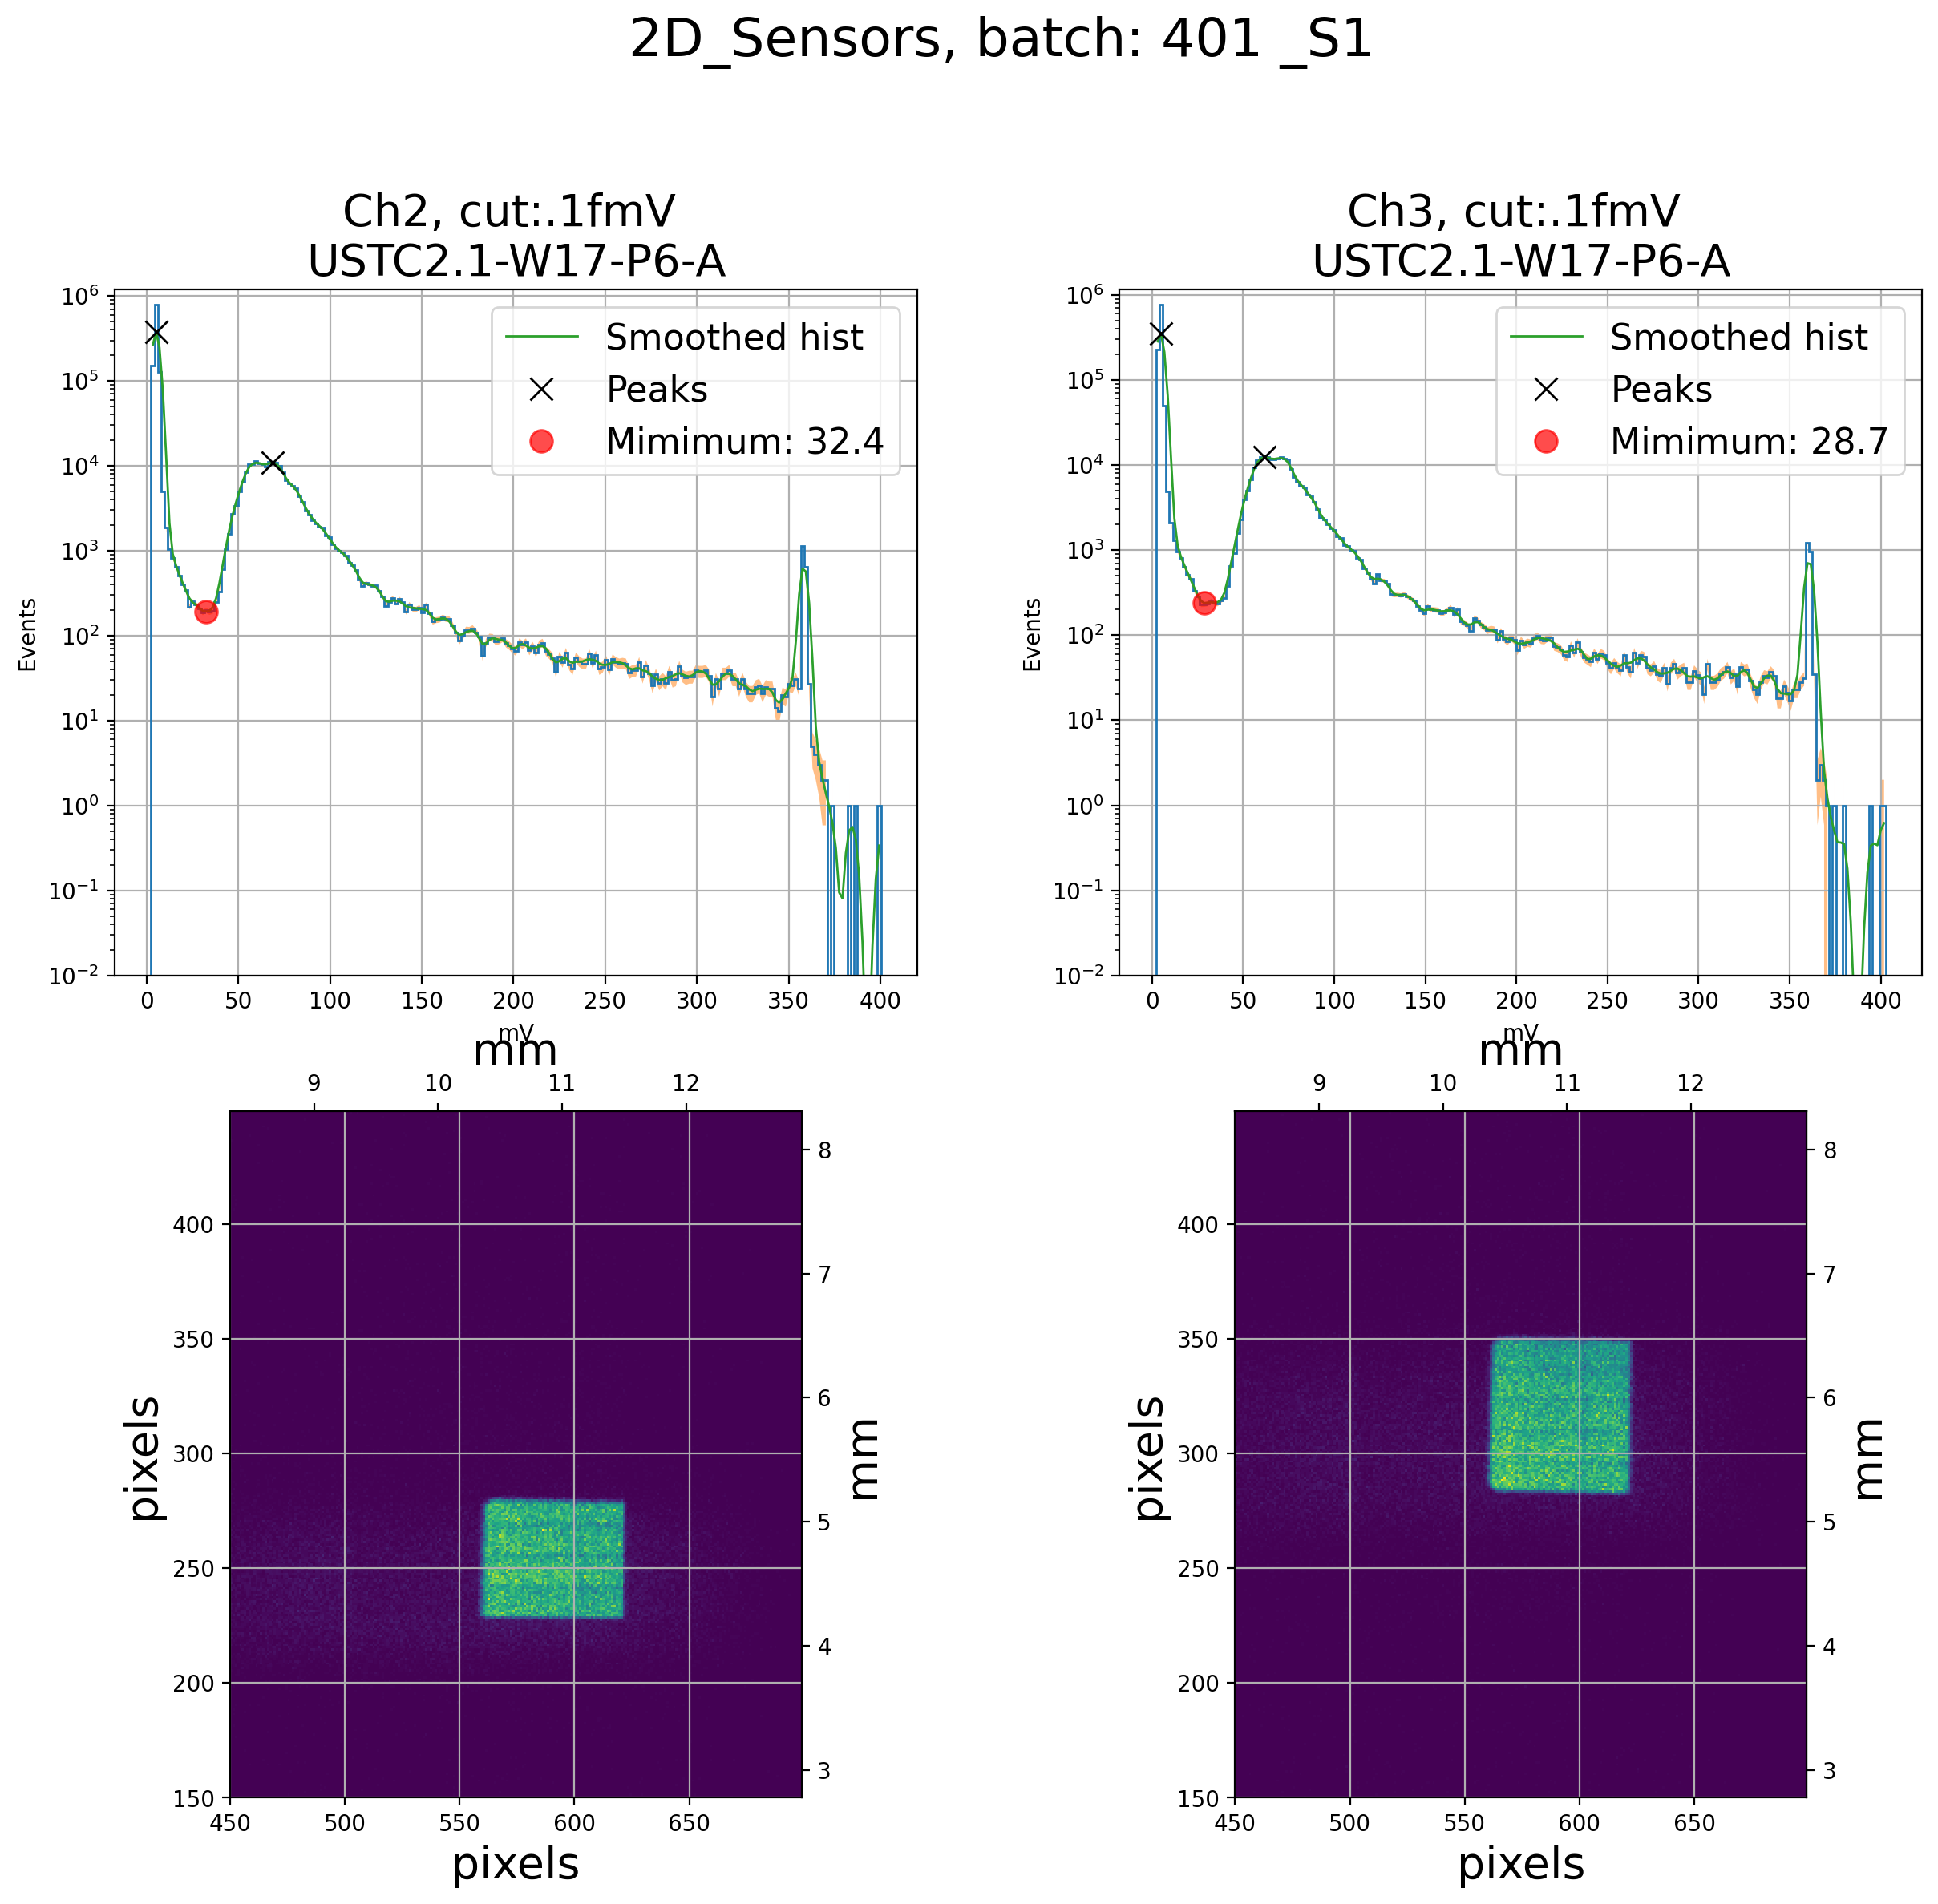

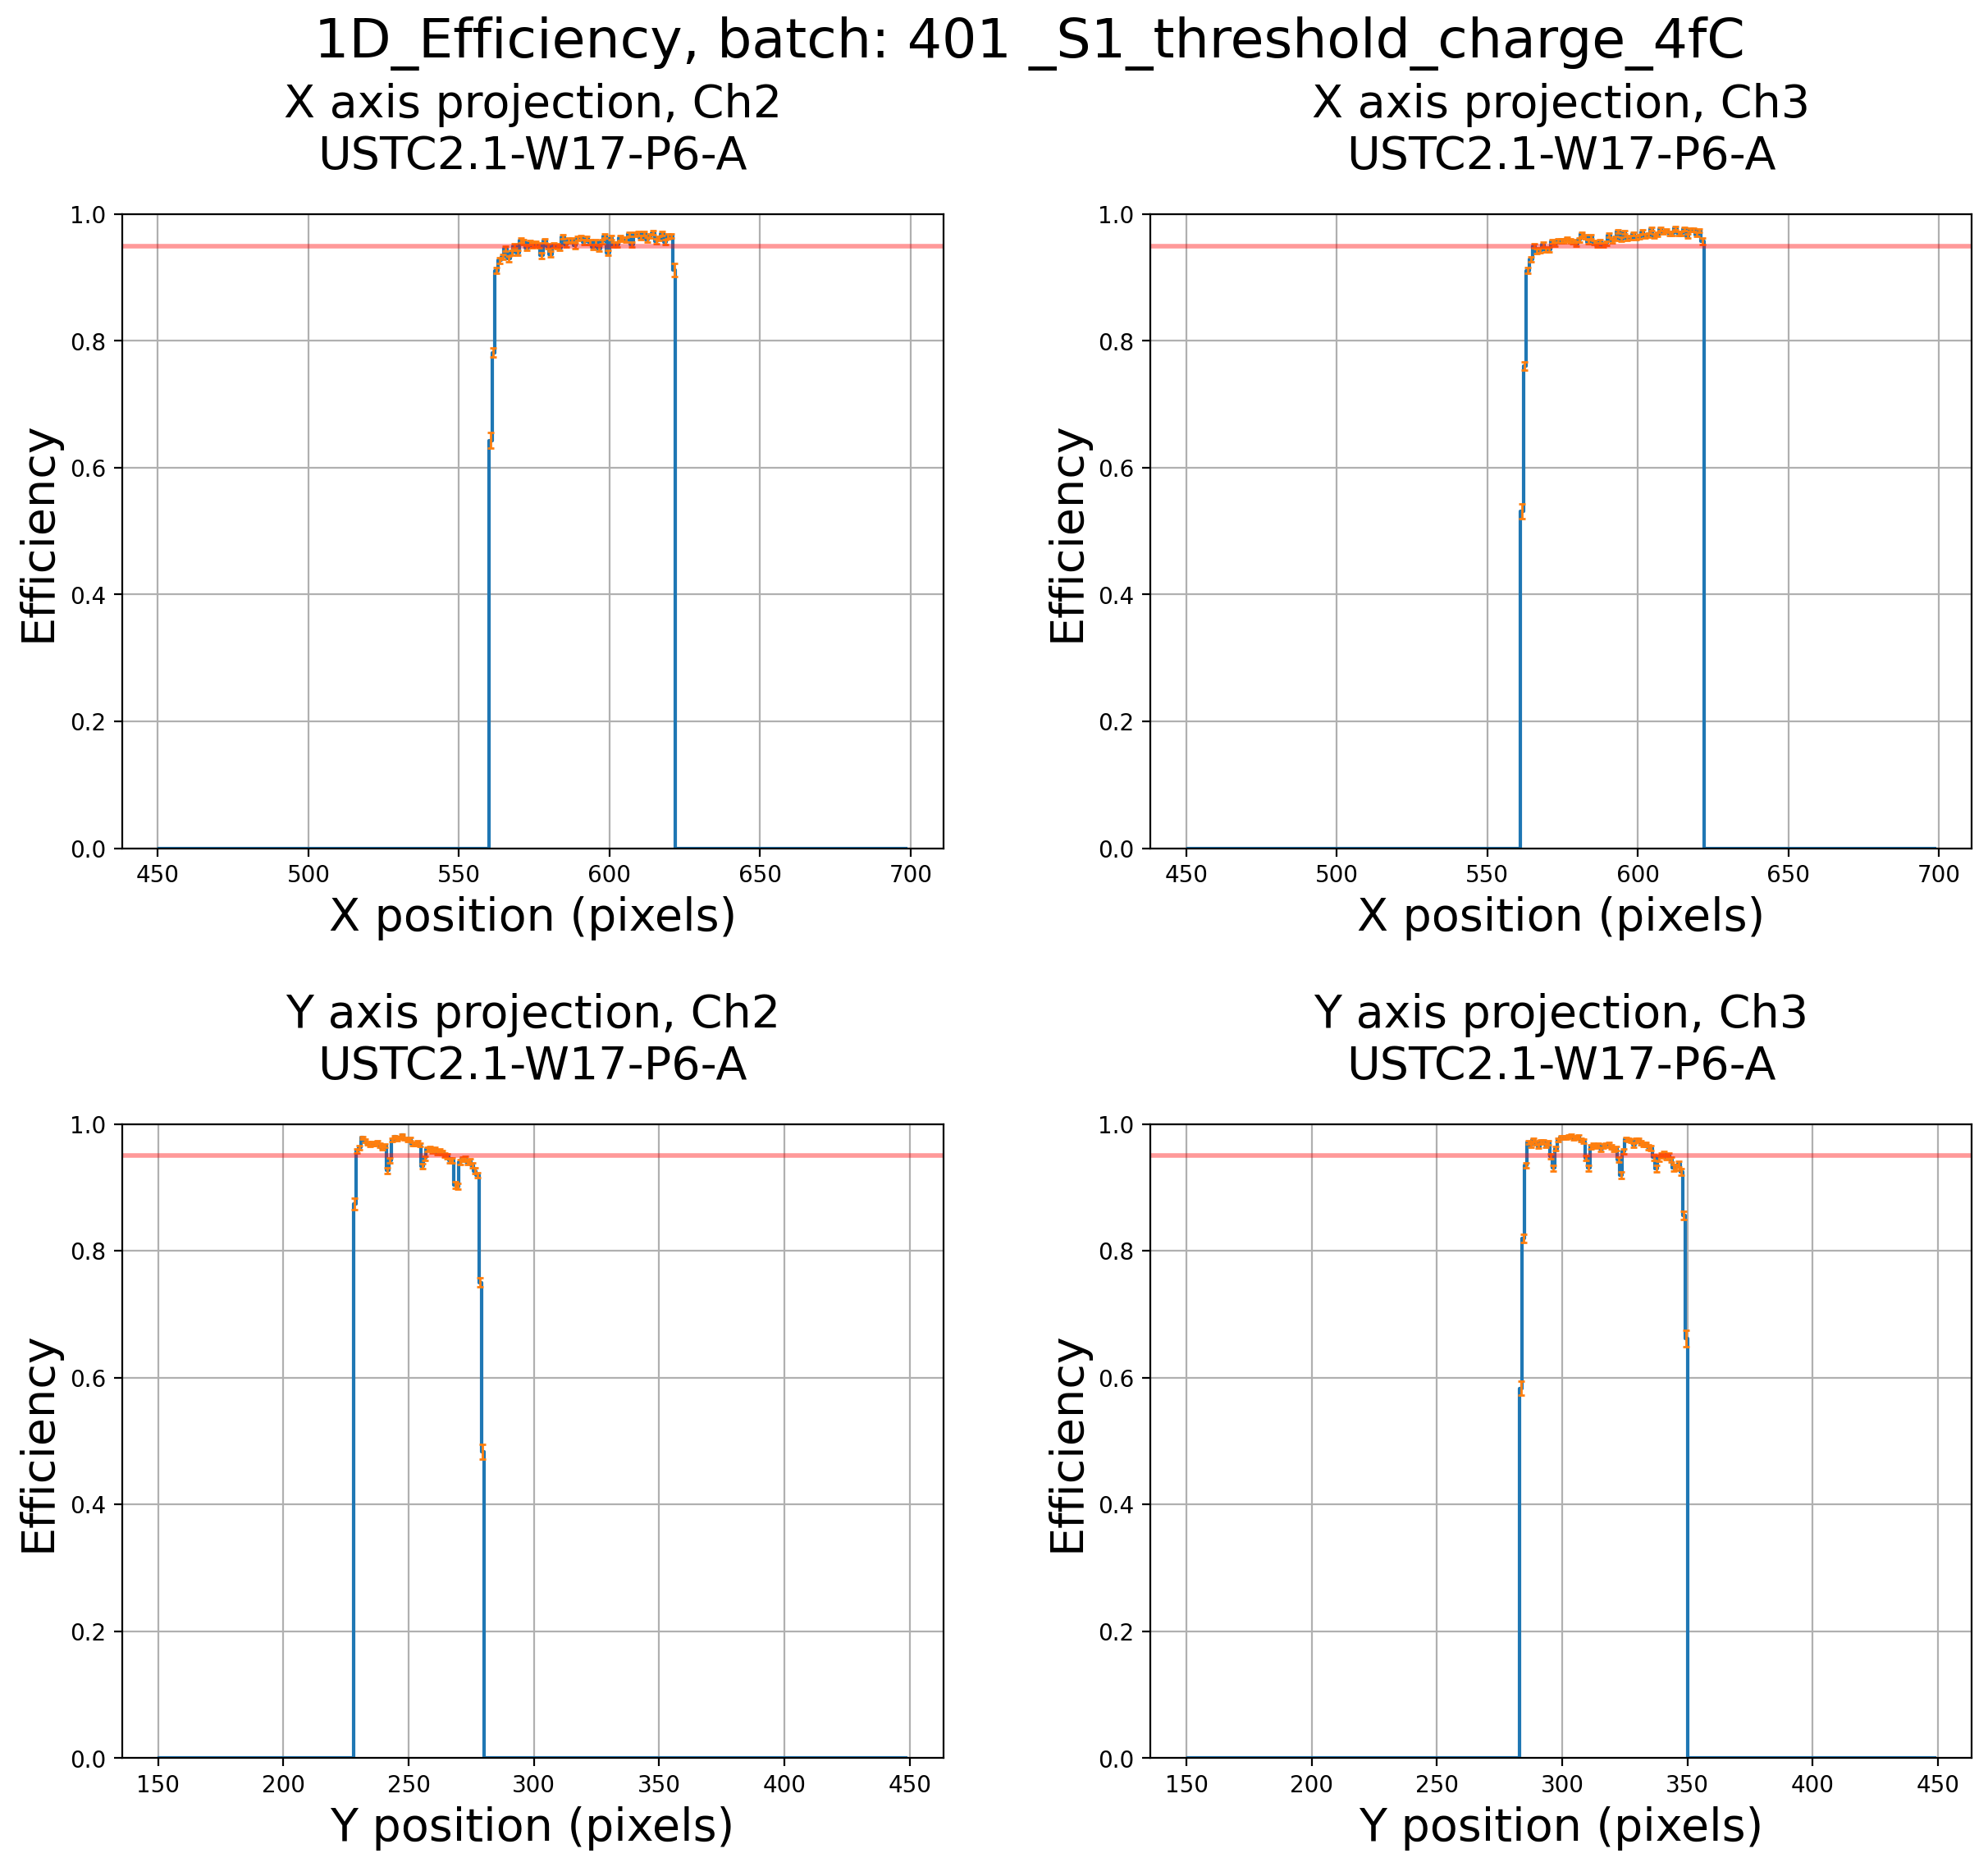

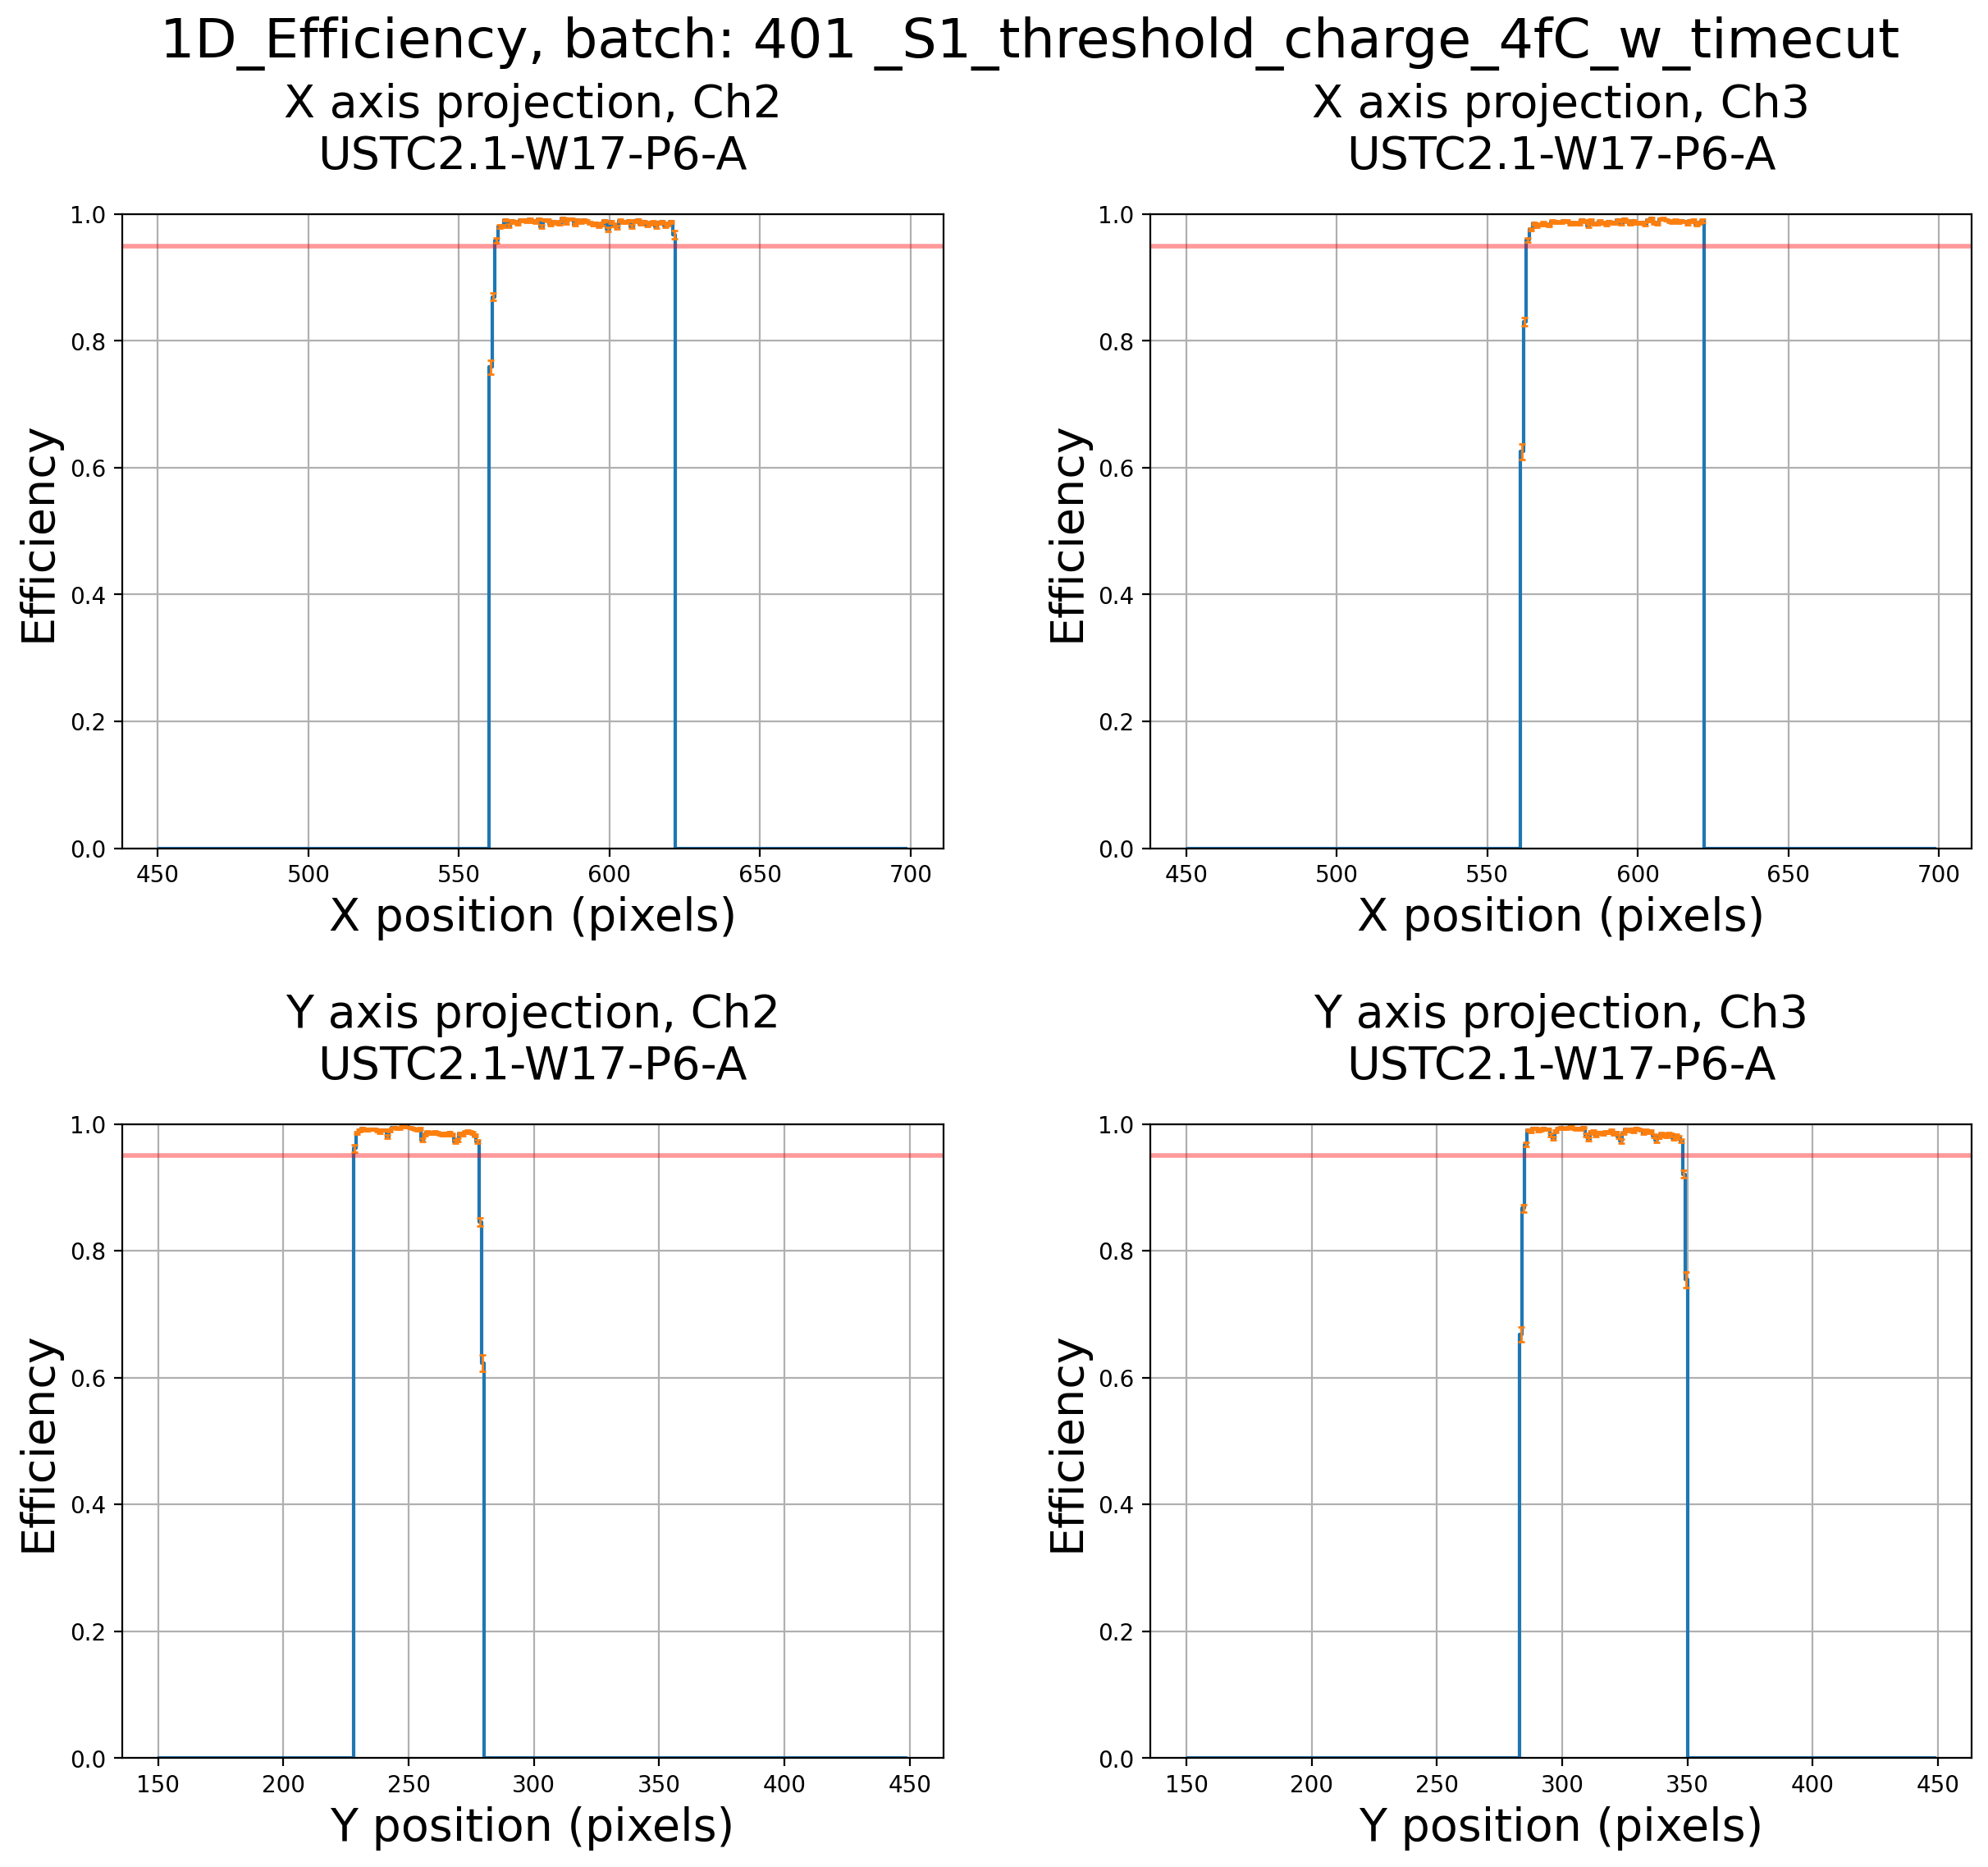

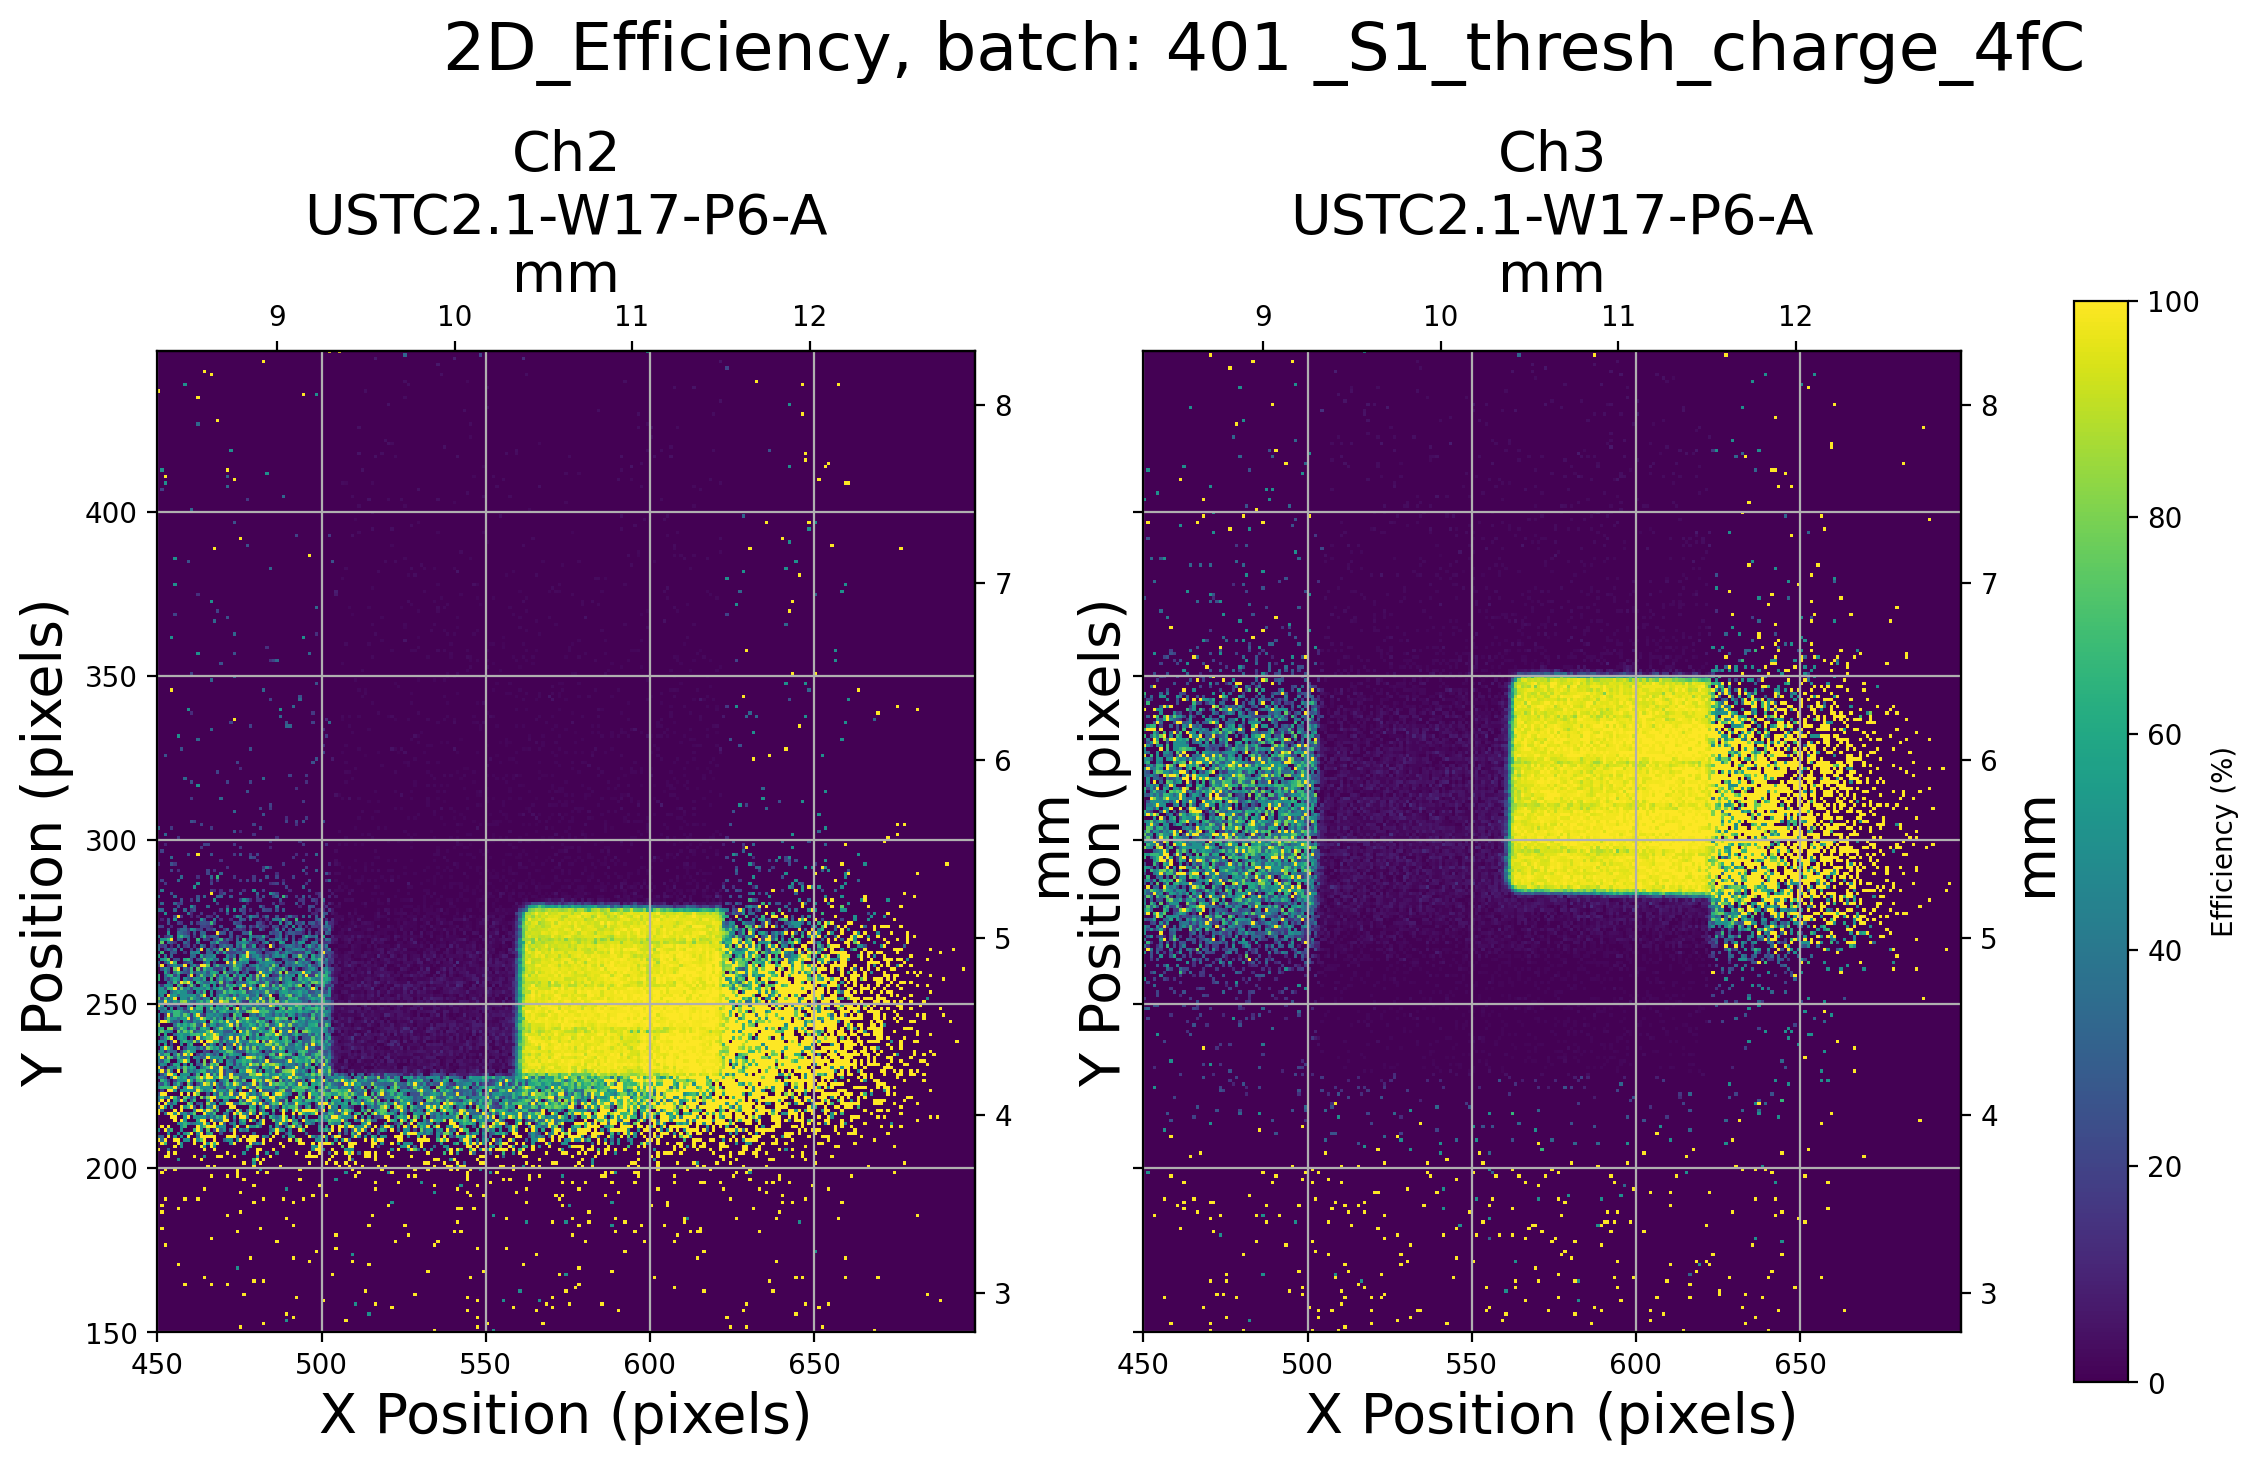

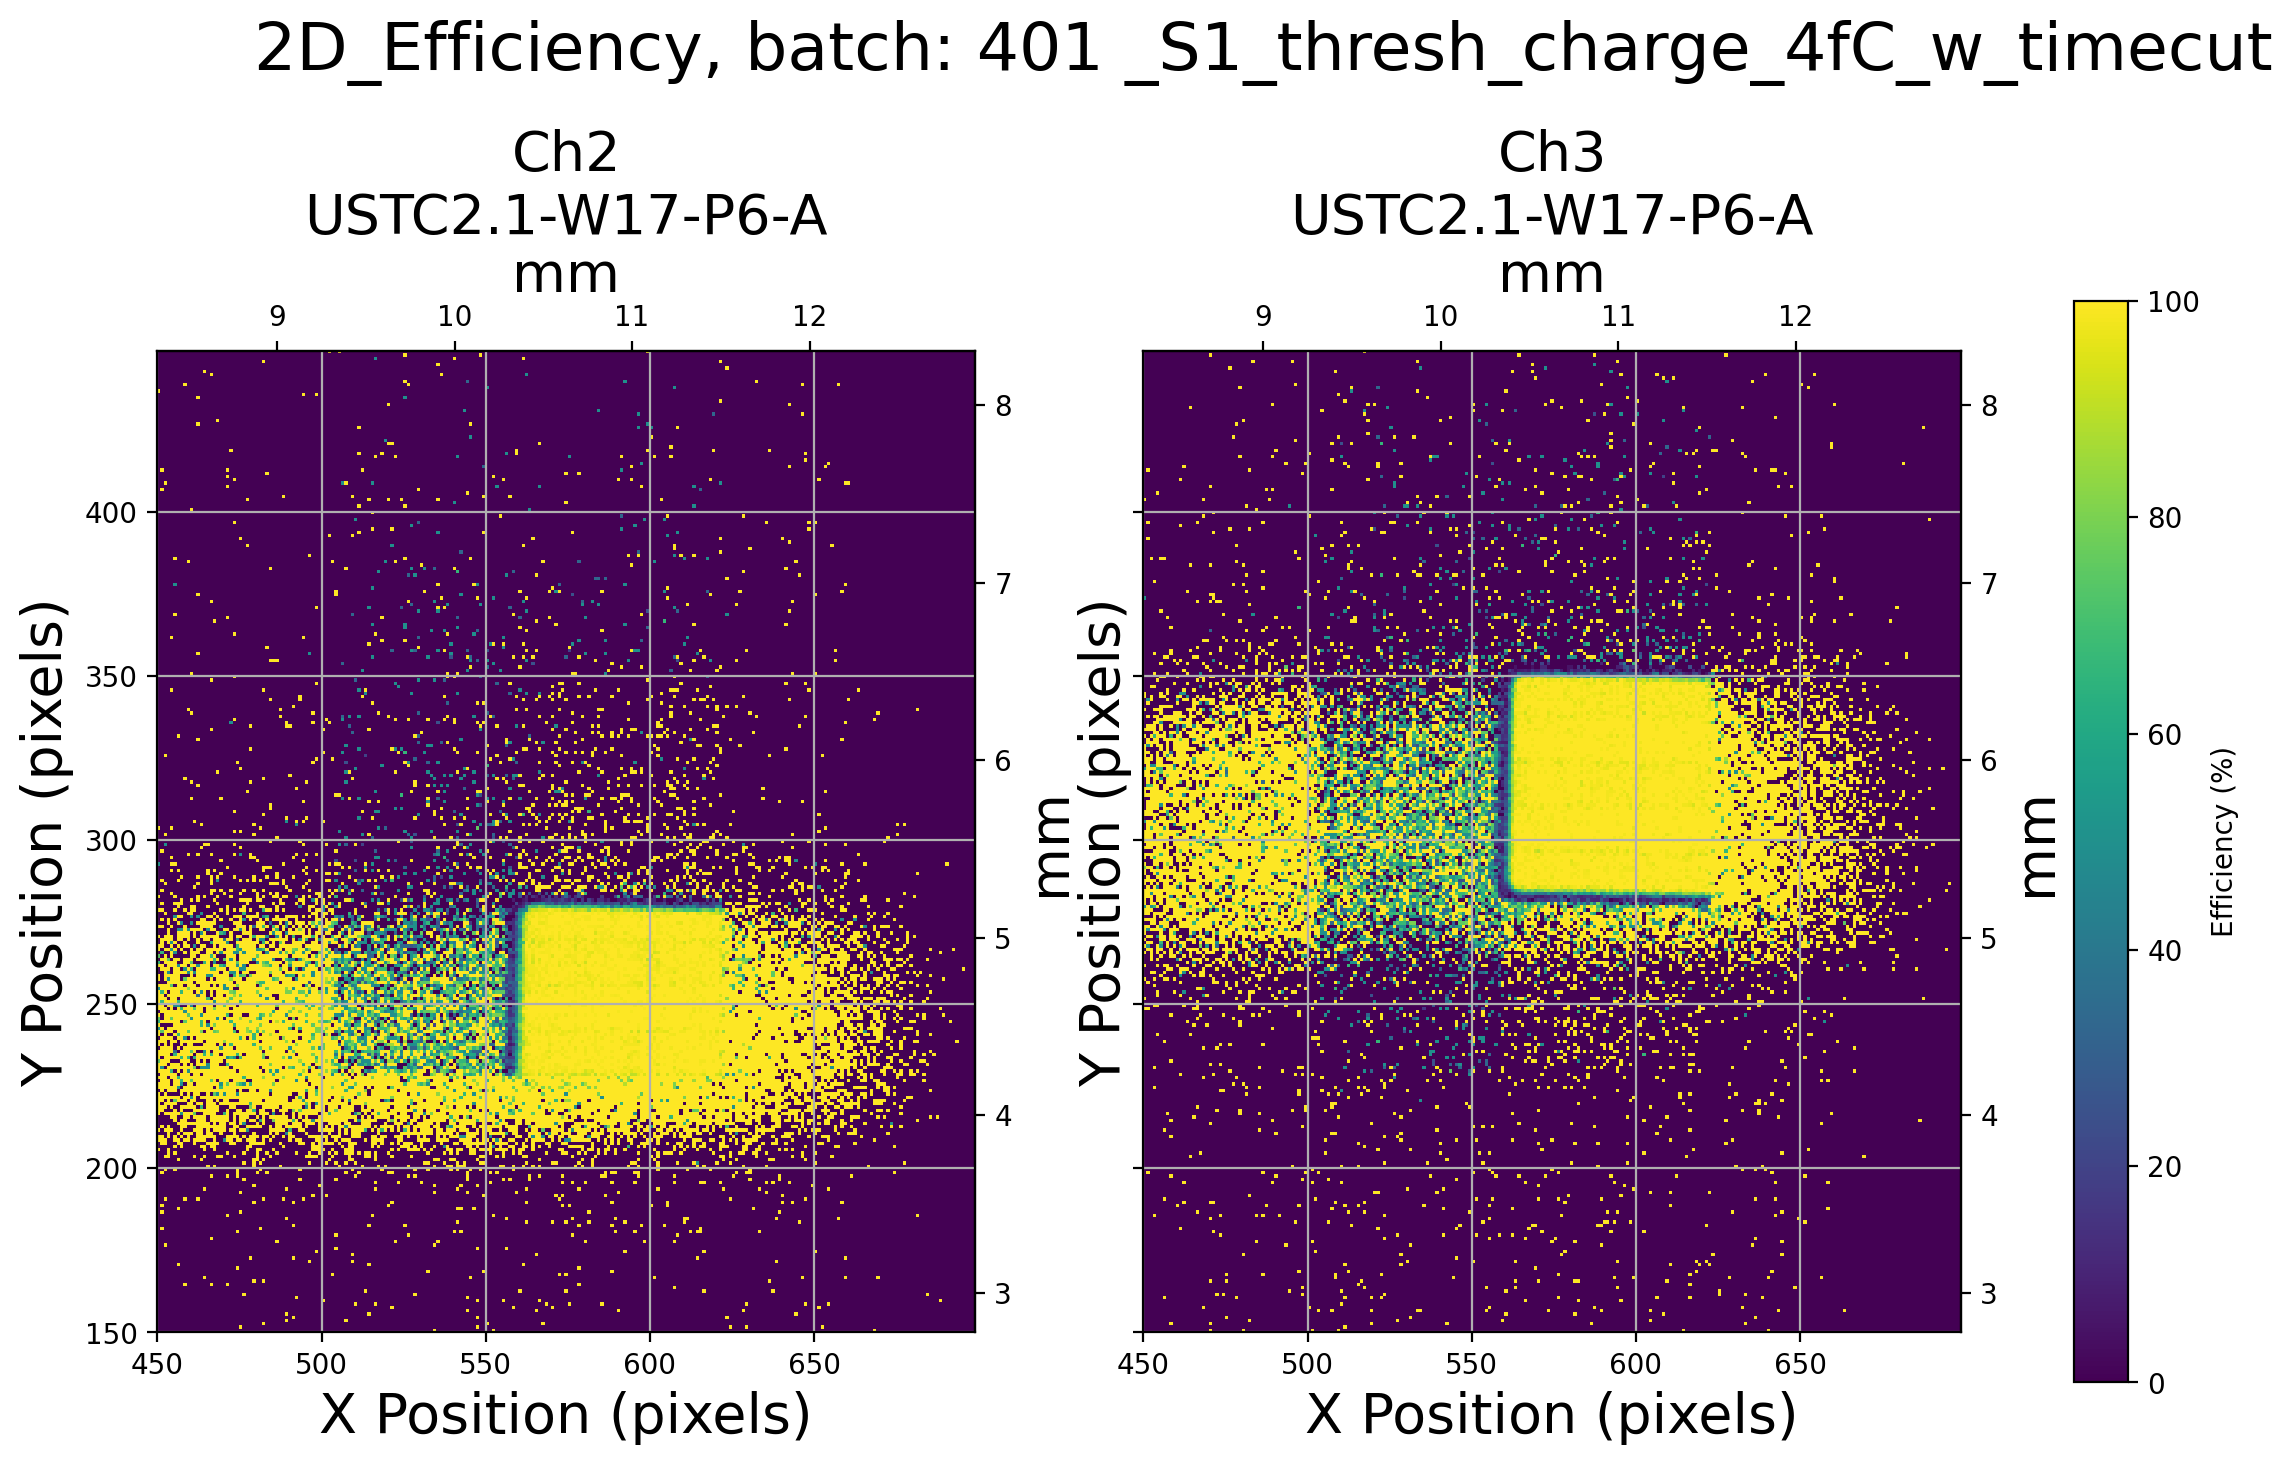

Batch:401, Scope:S1, Channel:Ch2
Batch:401, Scope:S1, Channel:Ch3
DUT_1
DUT_2


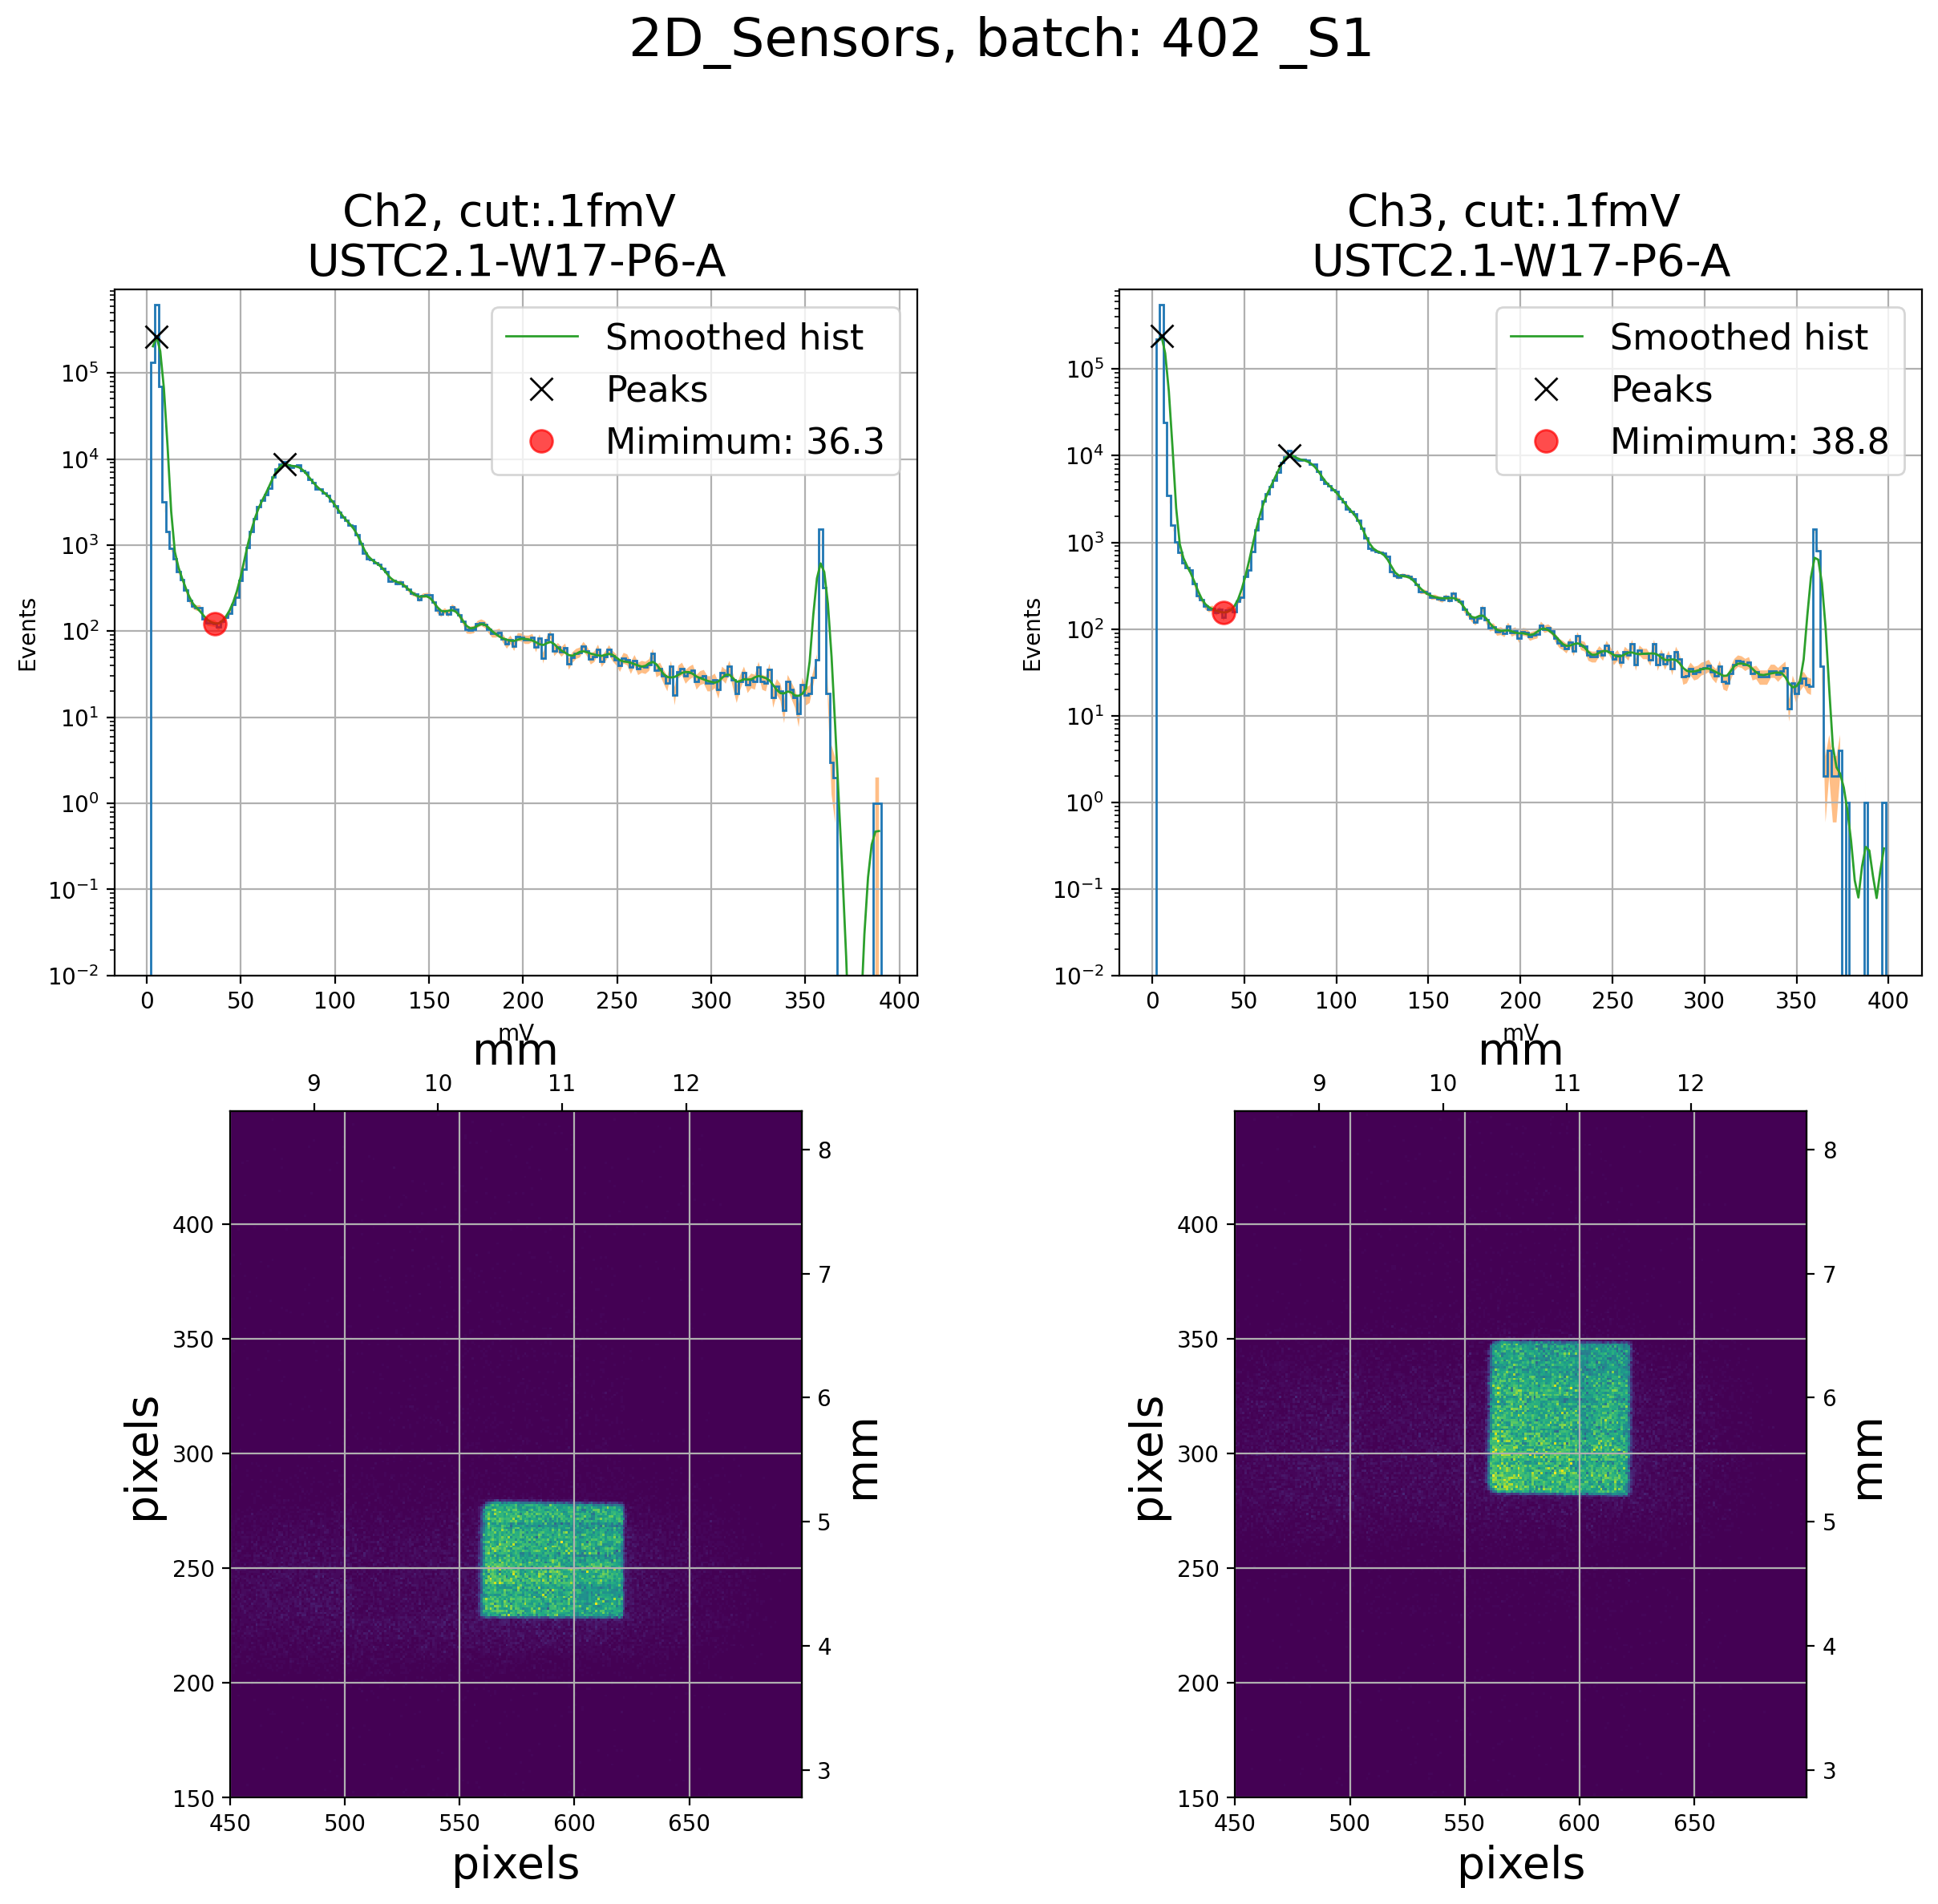

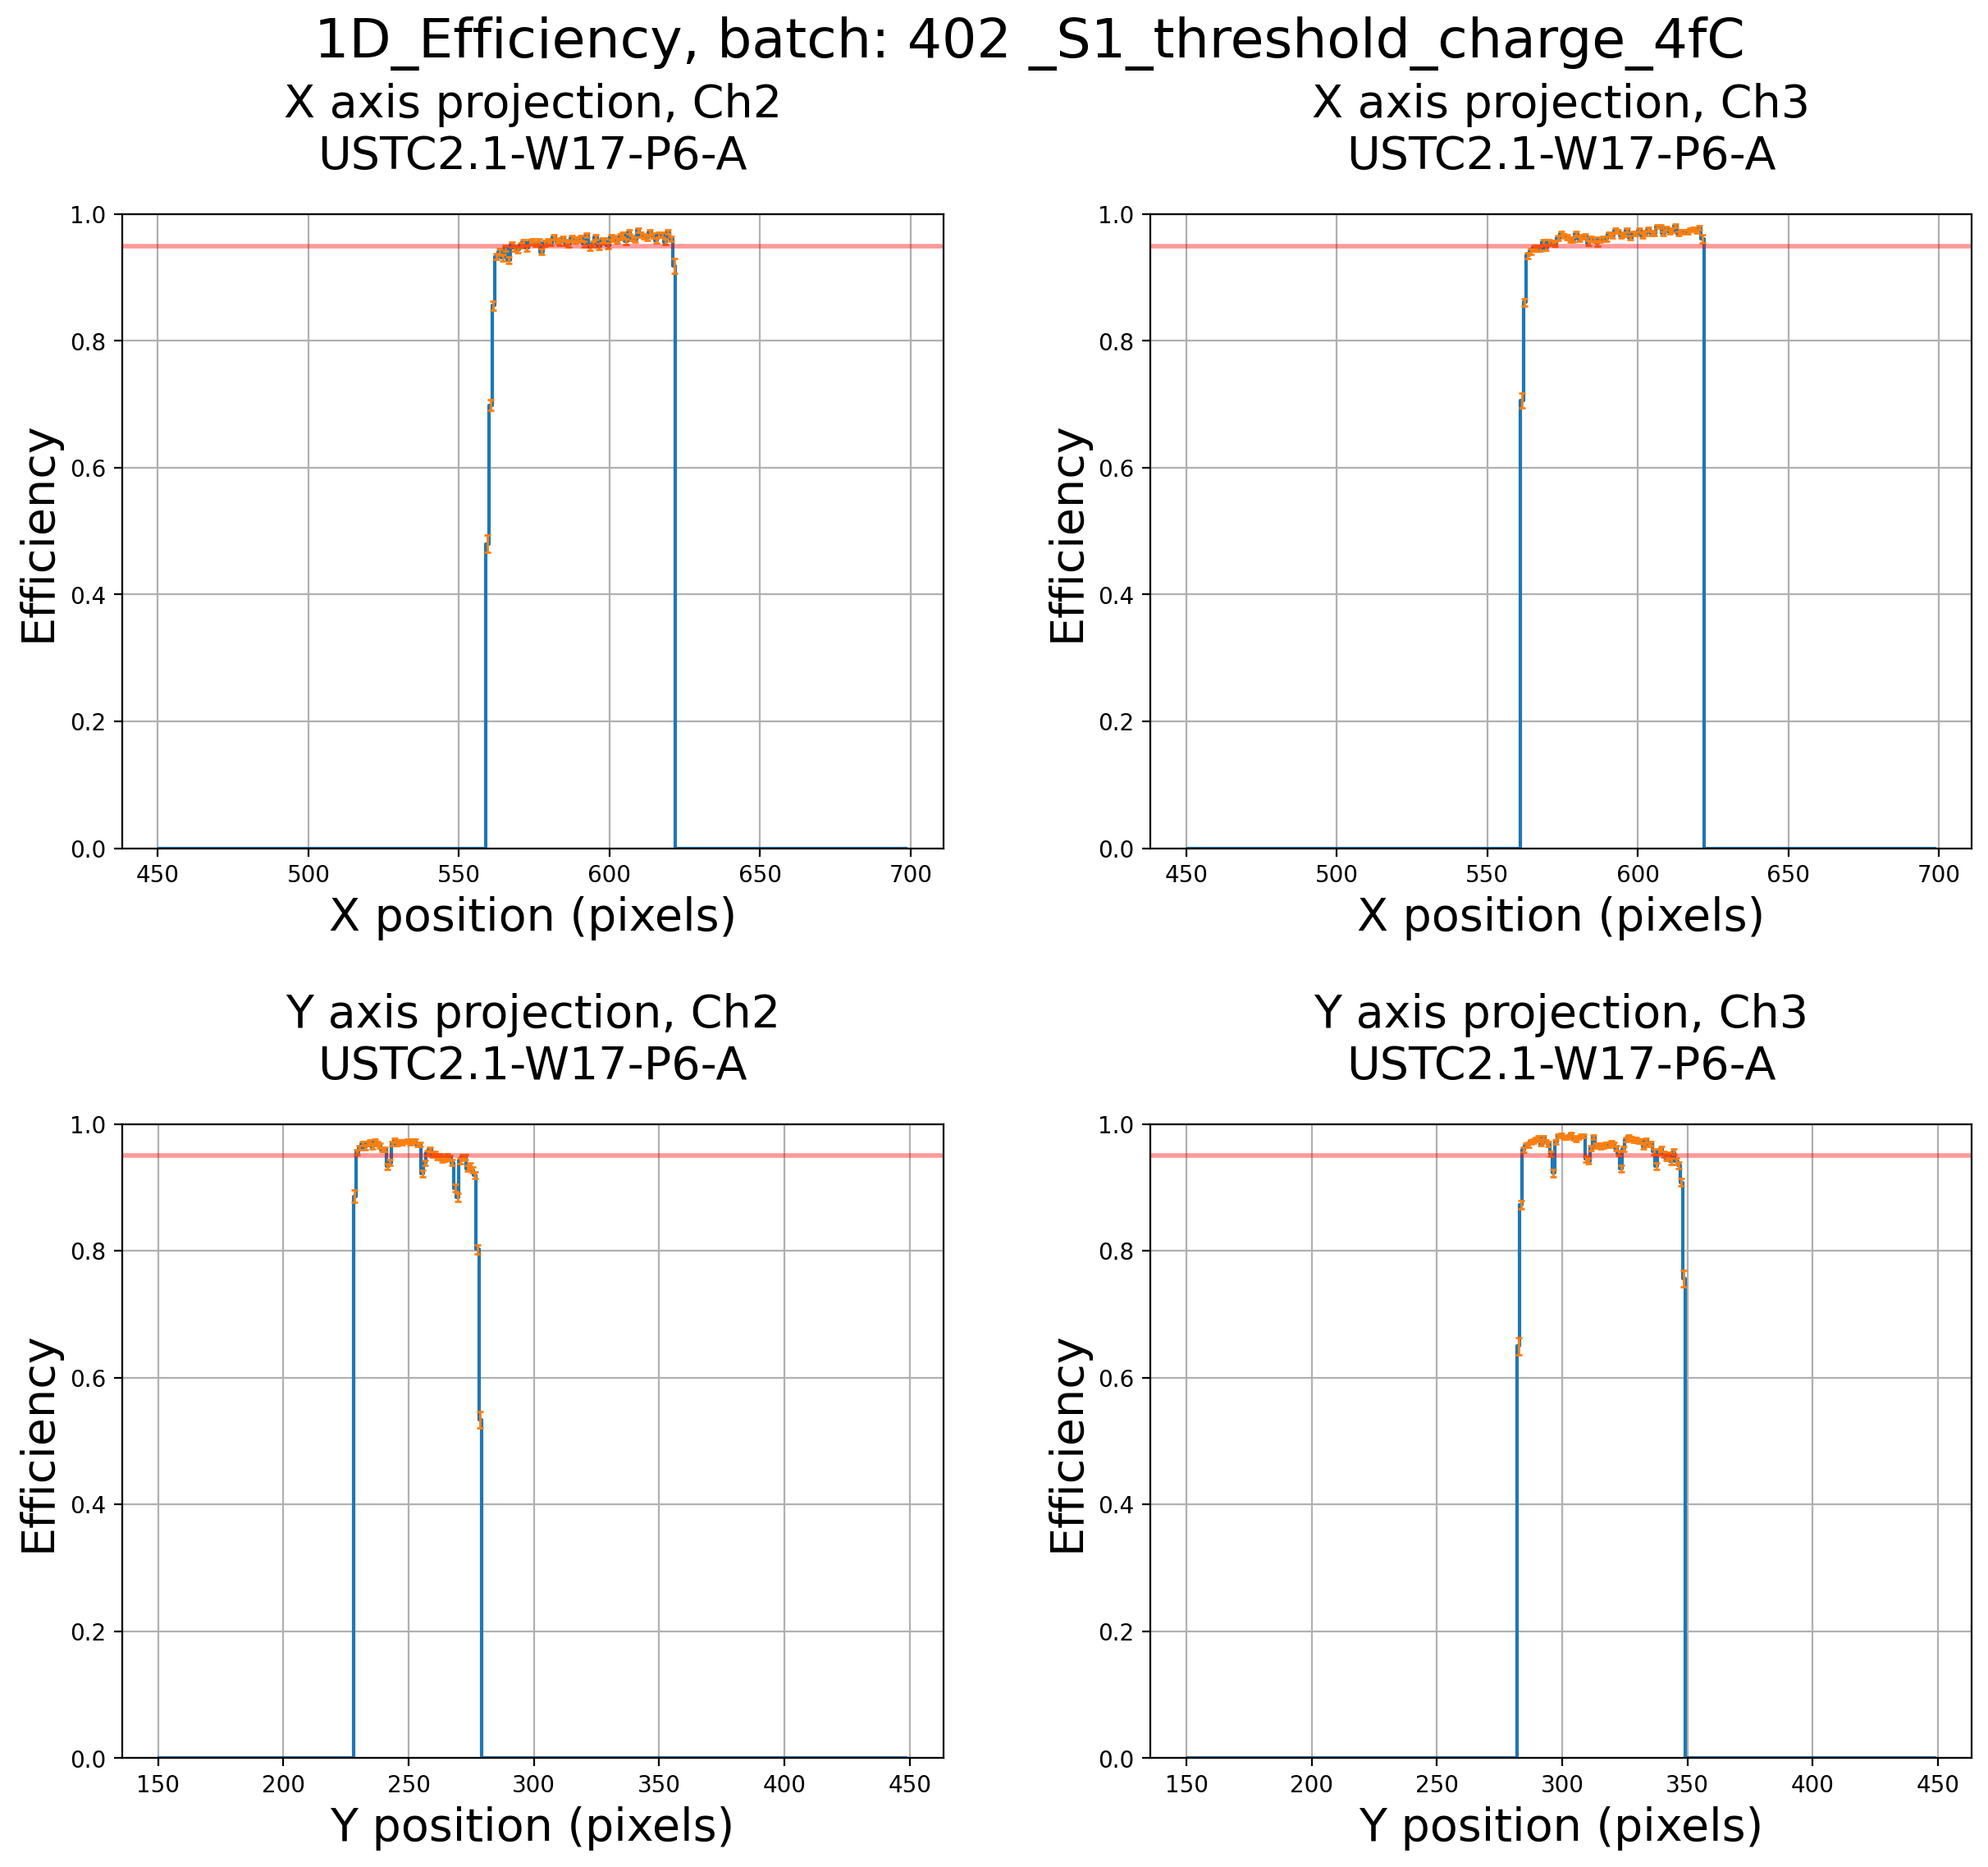

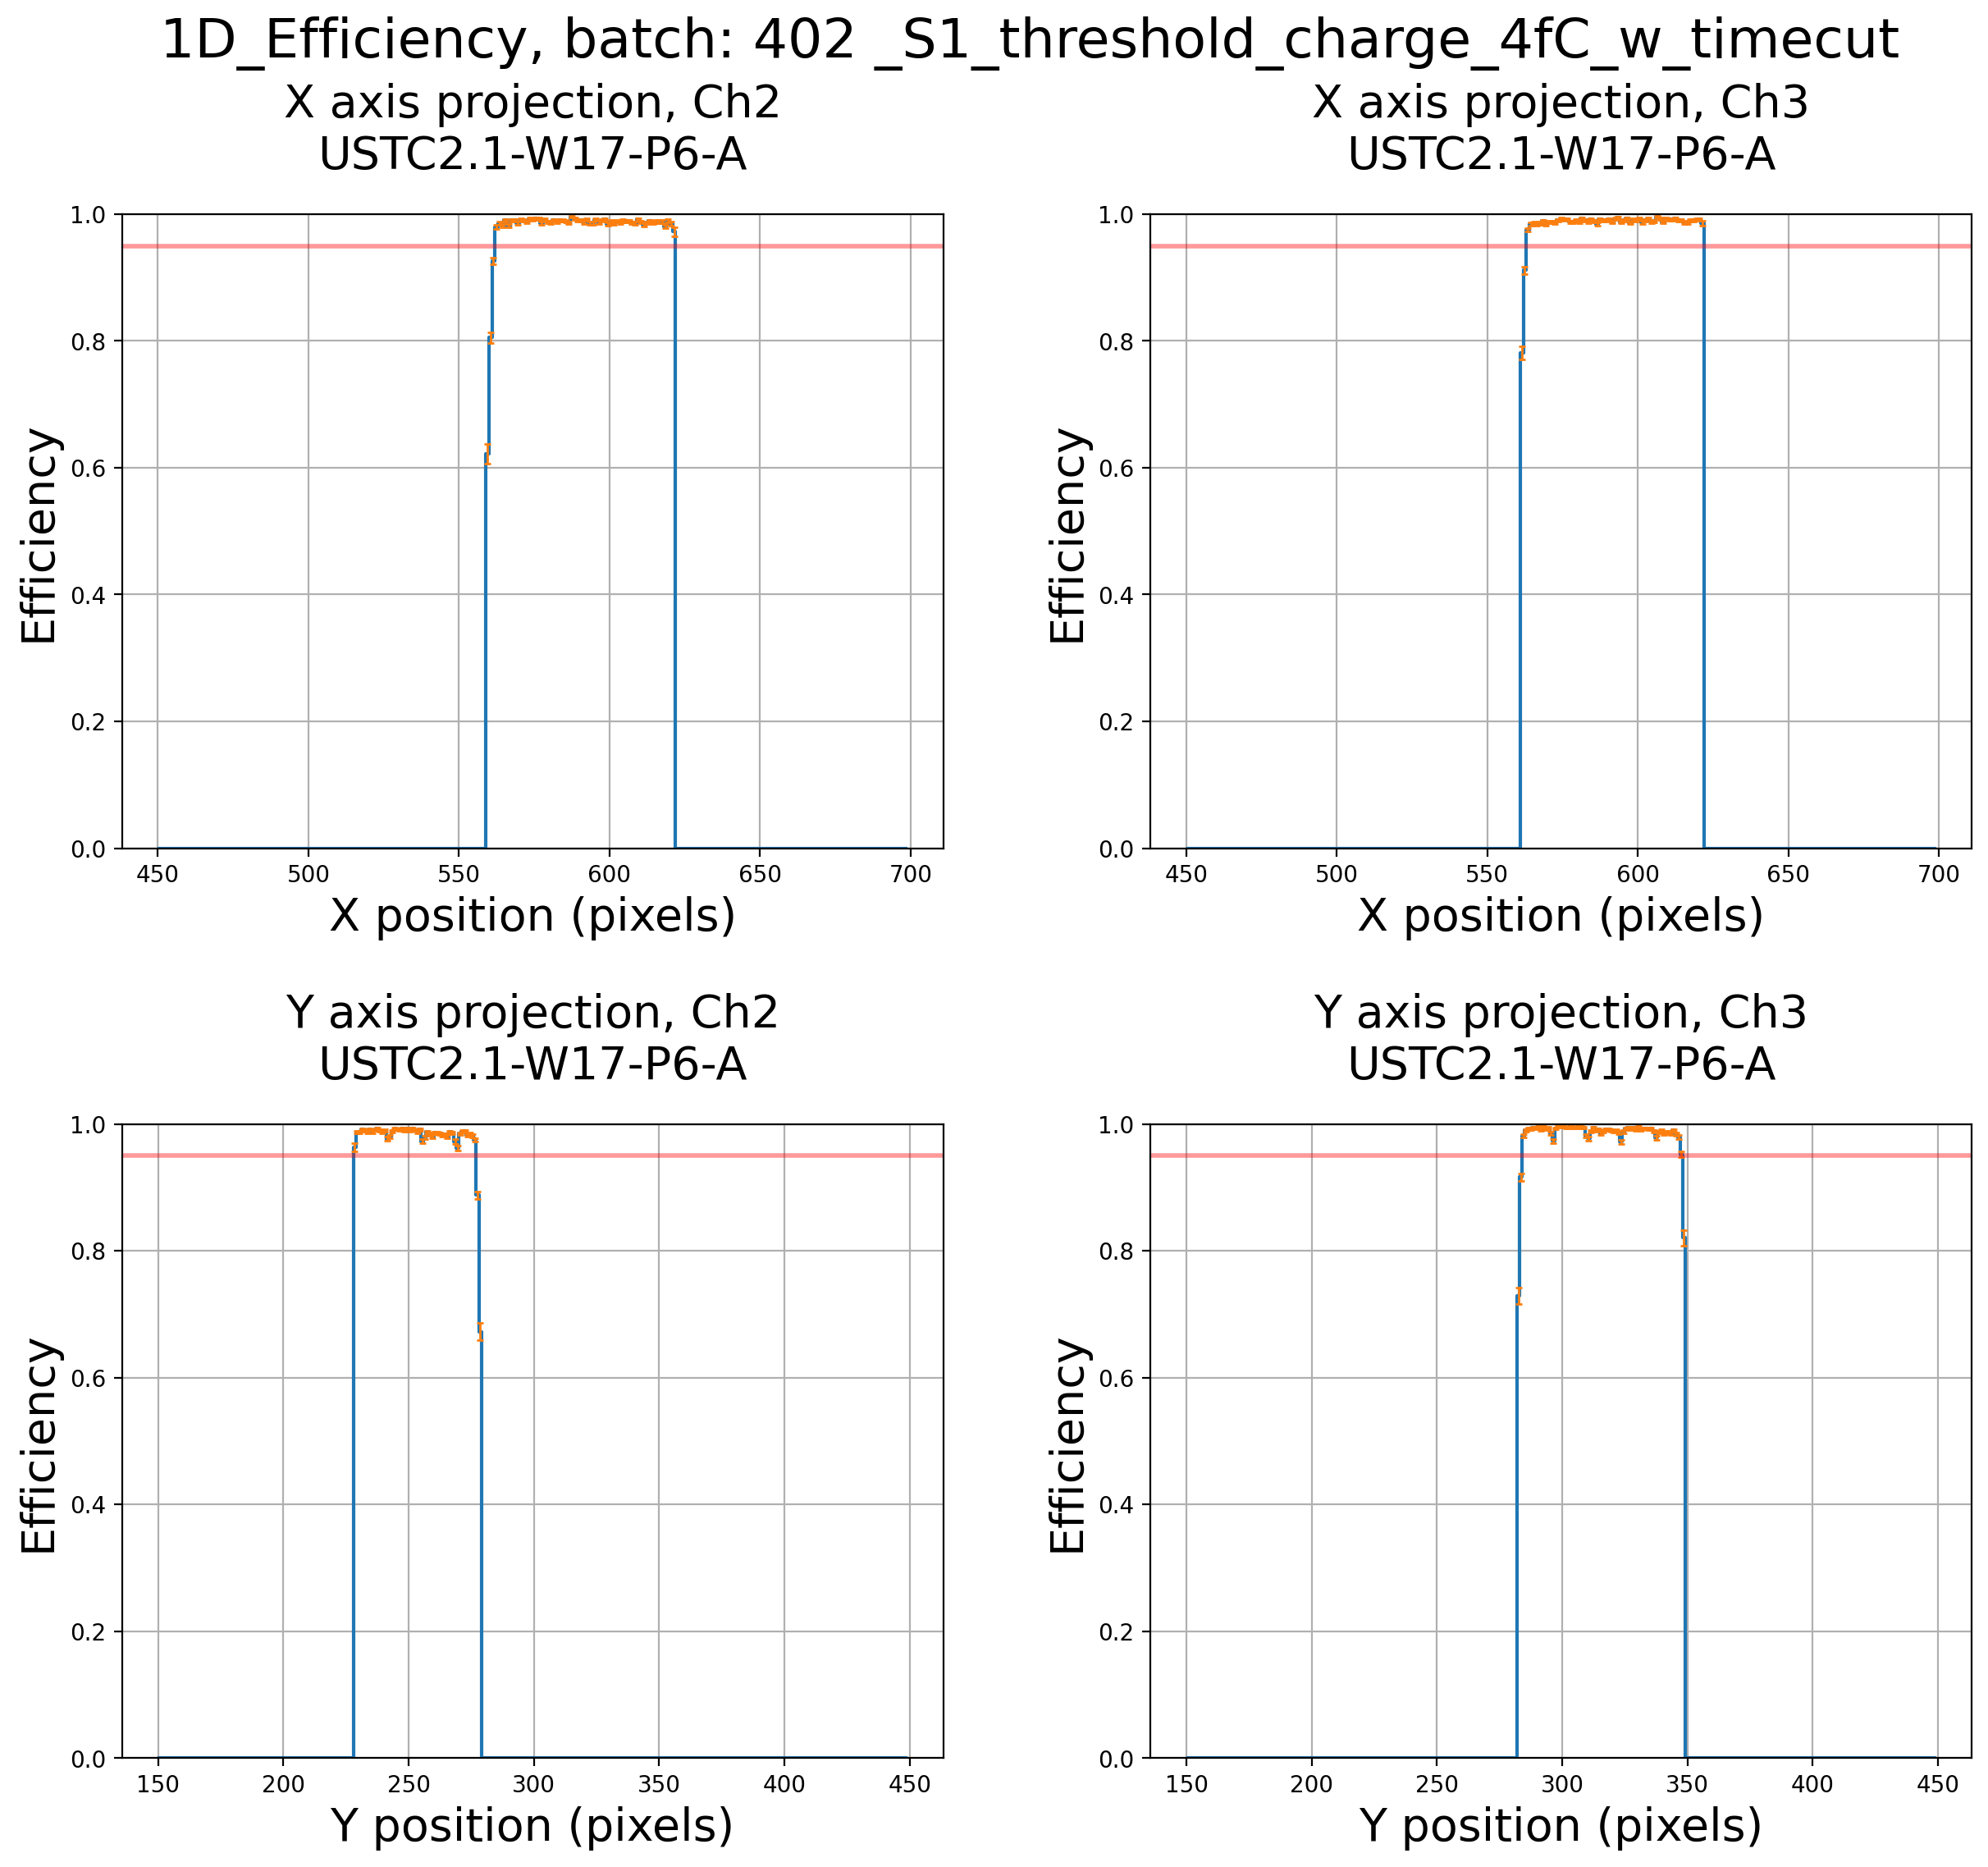

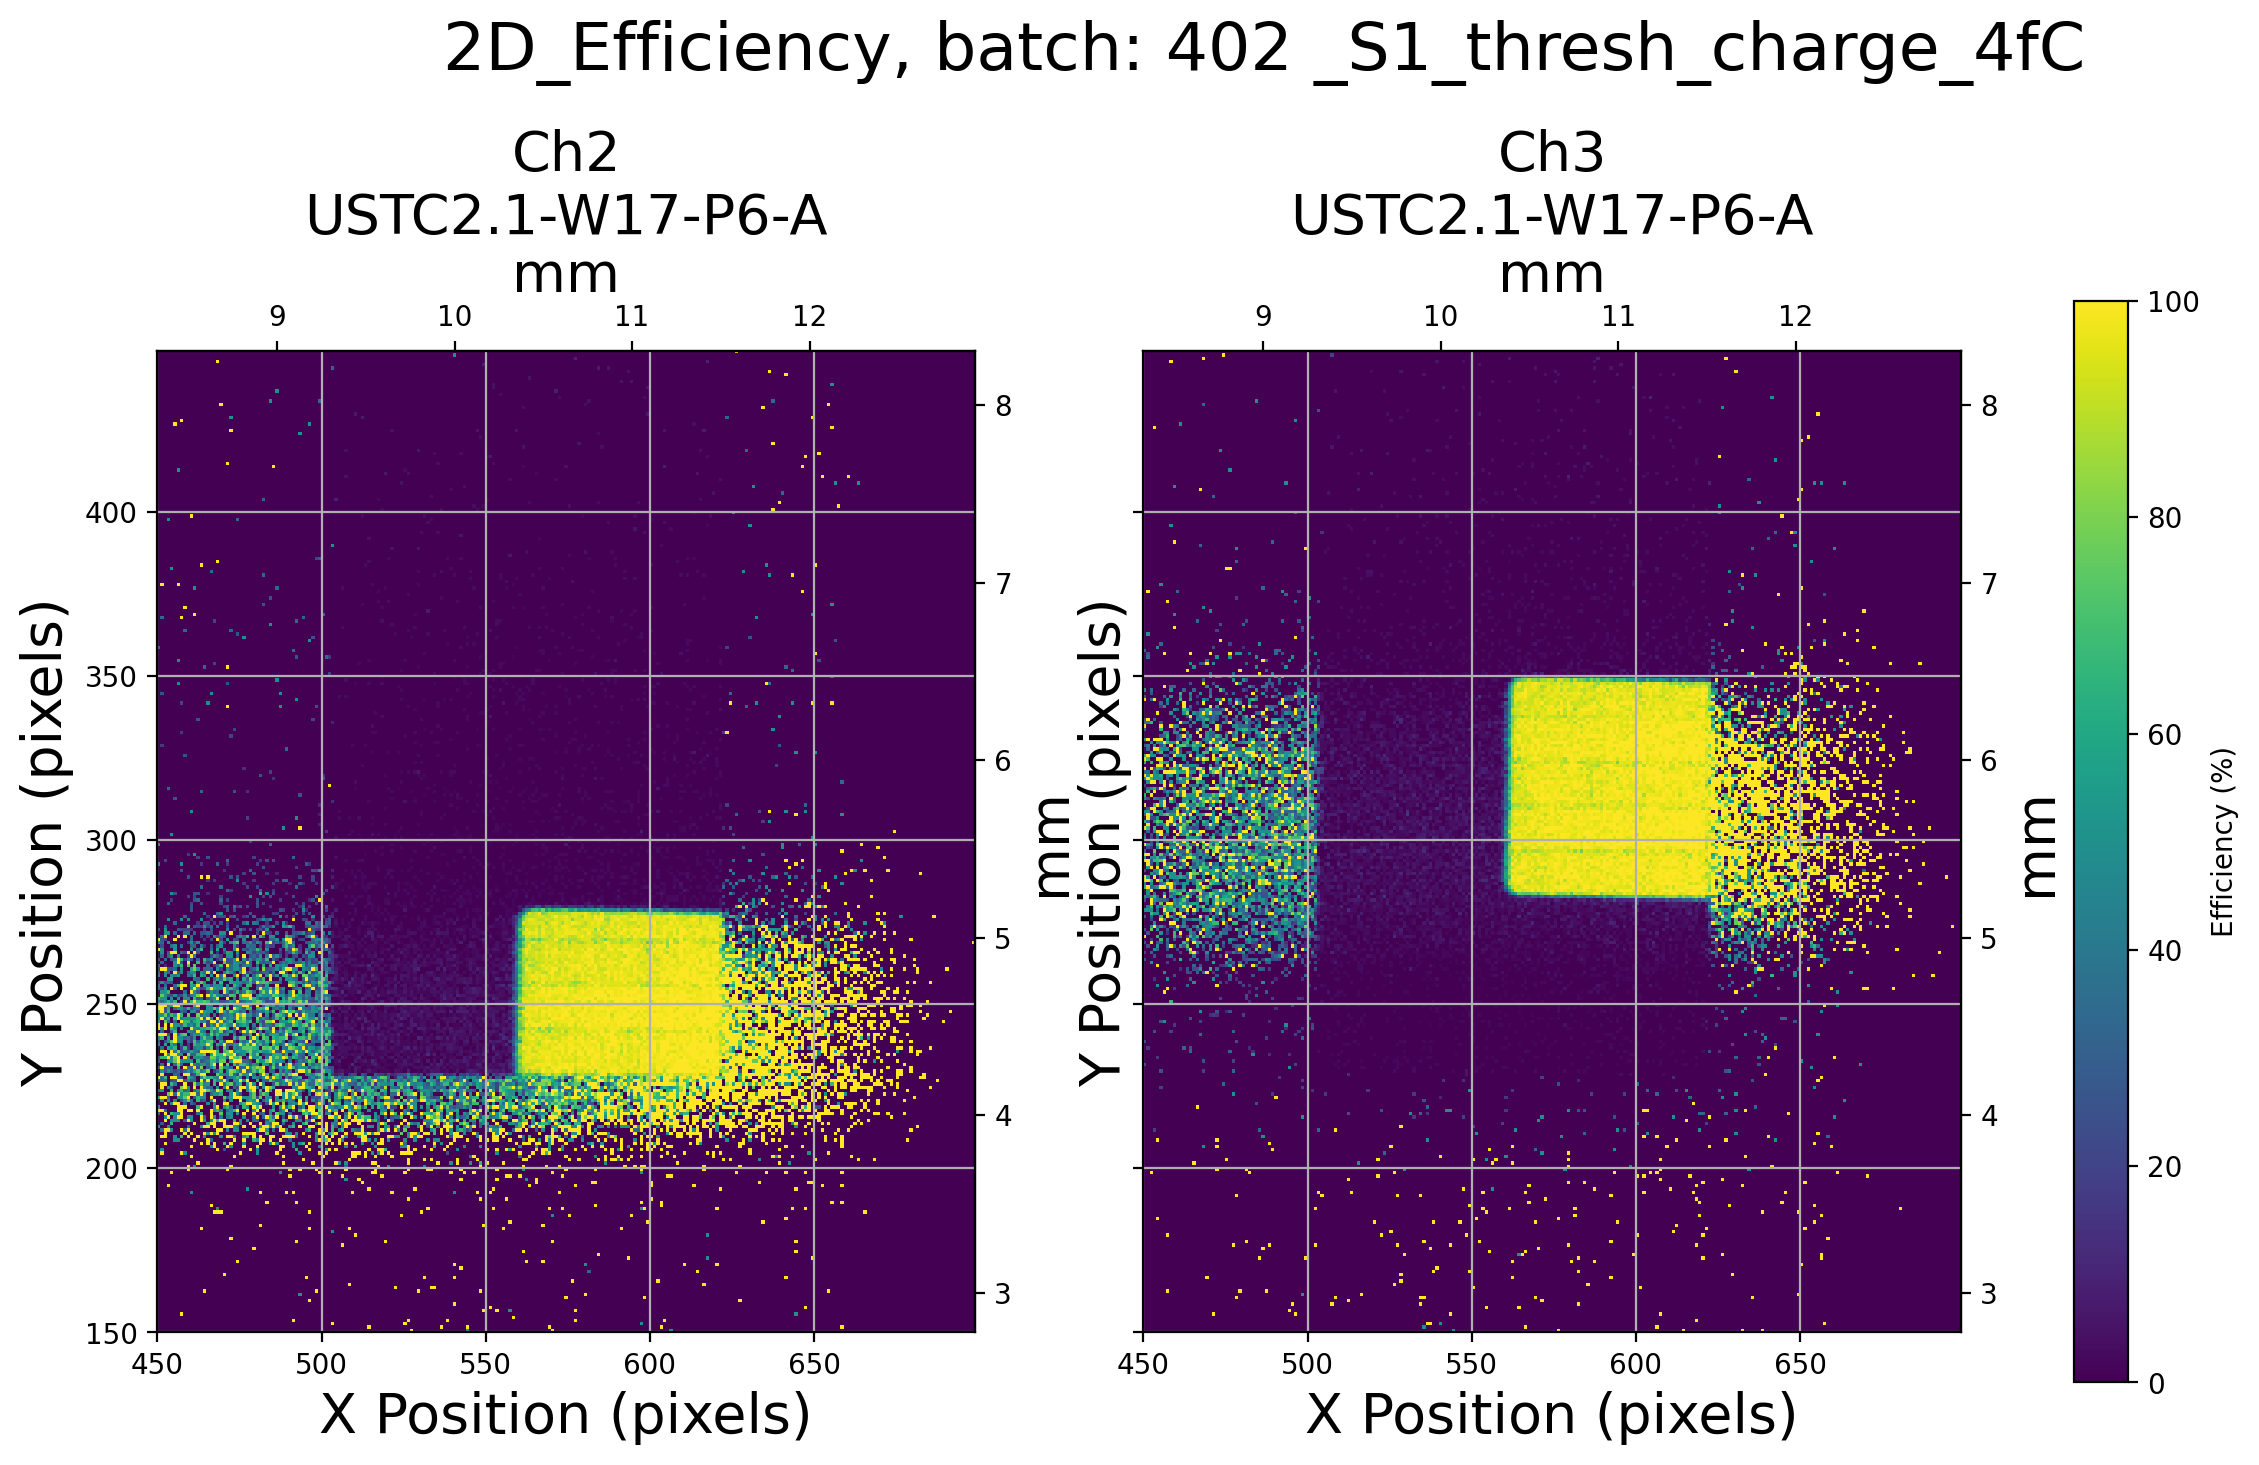

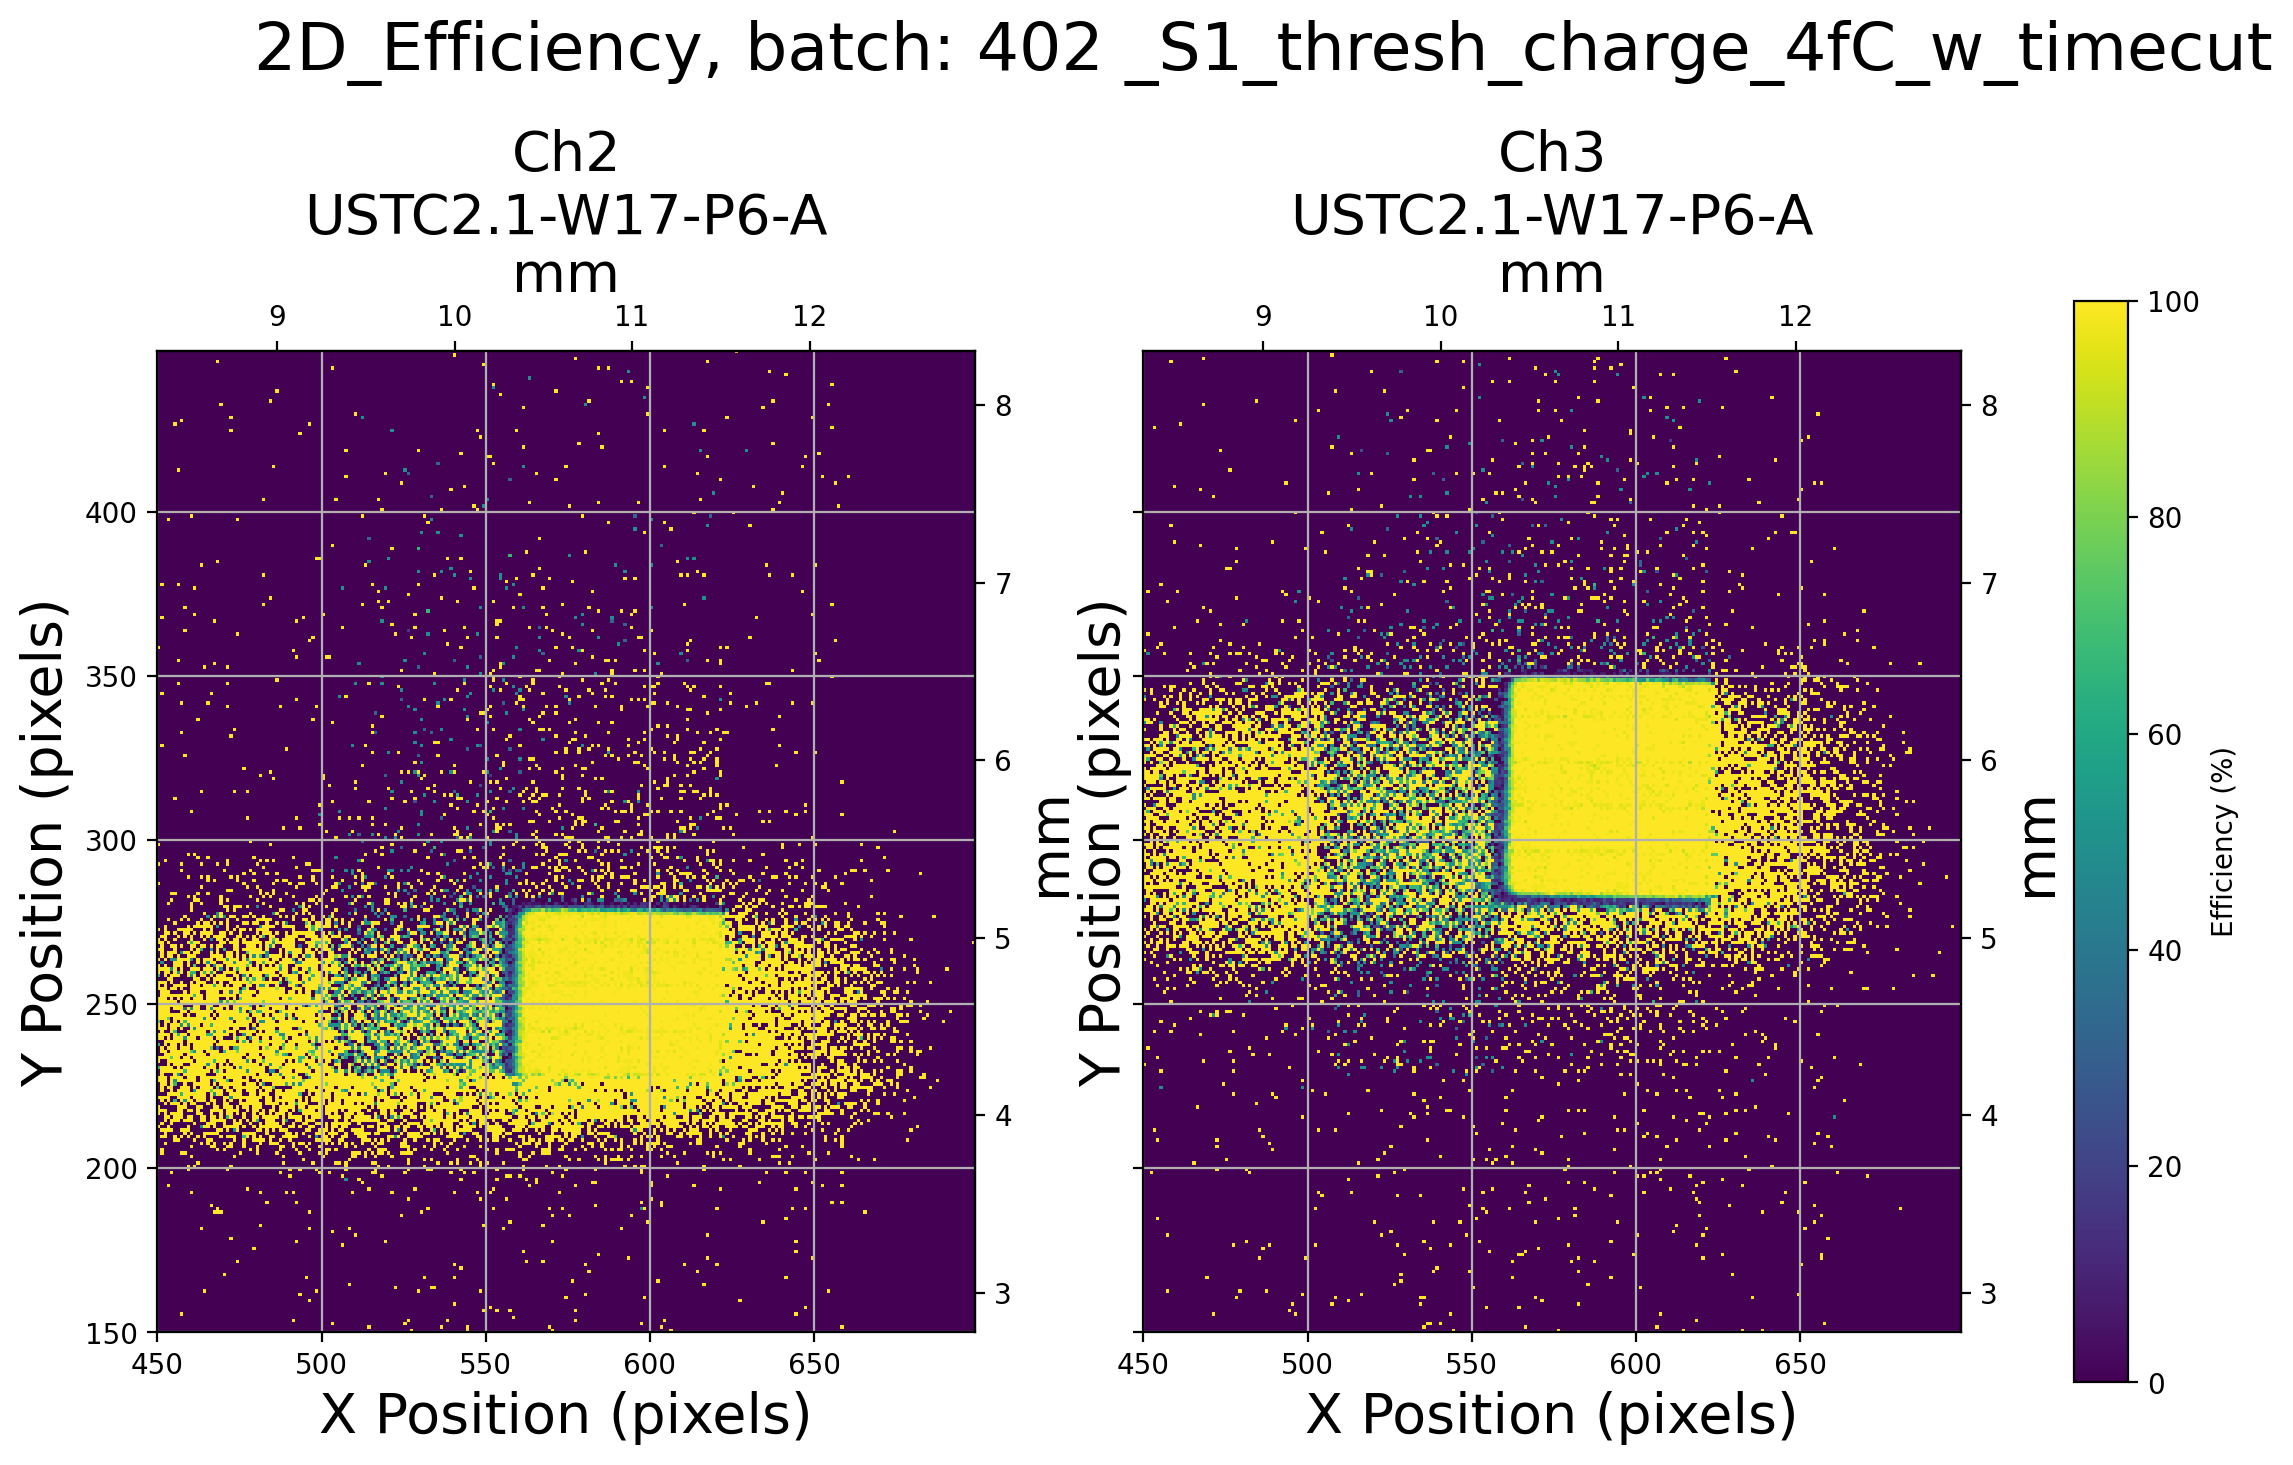

Batch:402, Scope:S1, Channel:Ch2
Batch:402, Scope:S1, Channel:Ch3
DUT_1
DUT_2


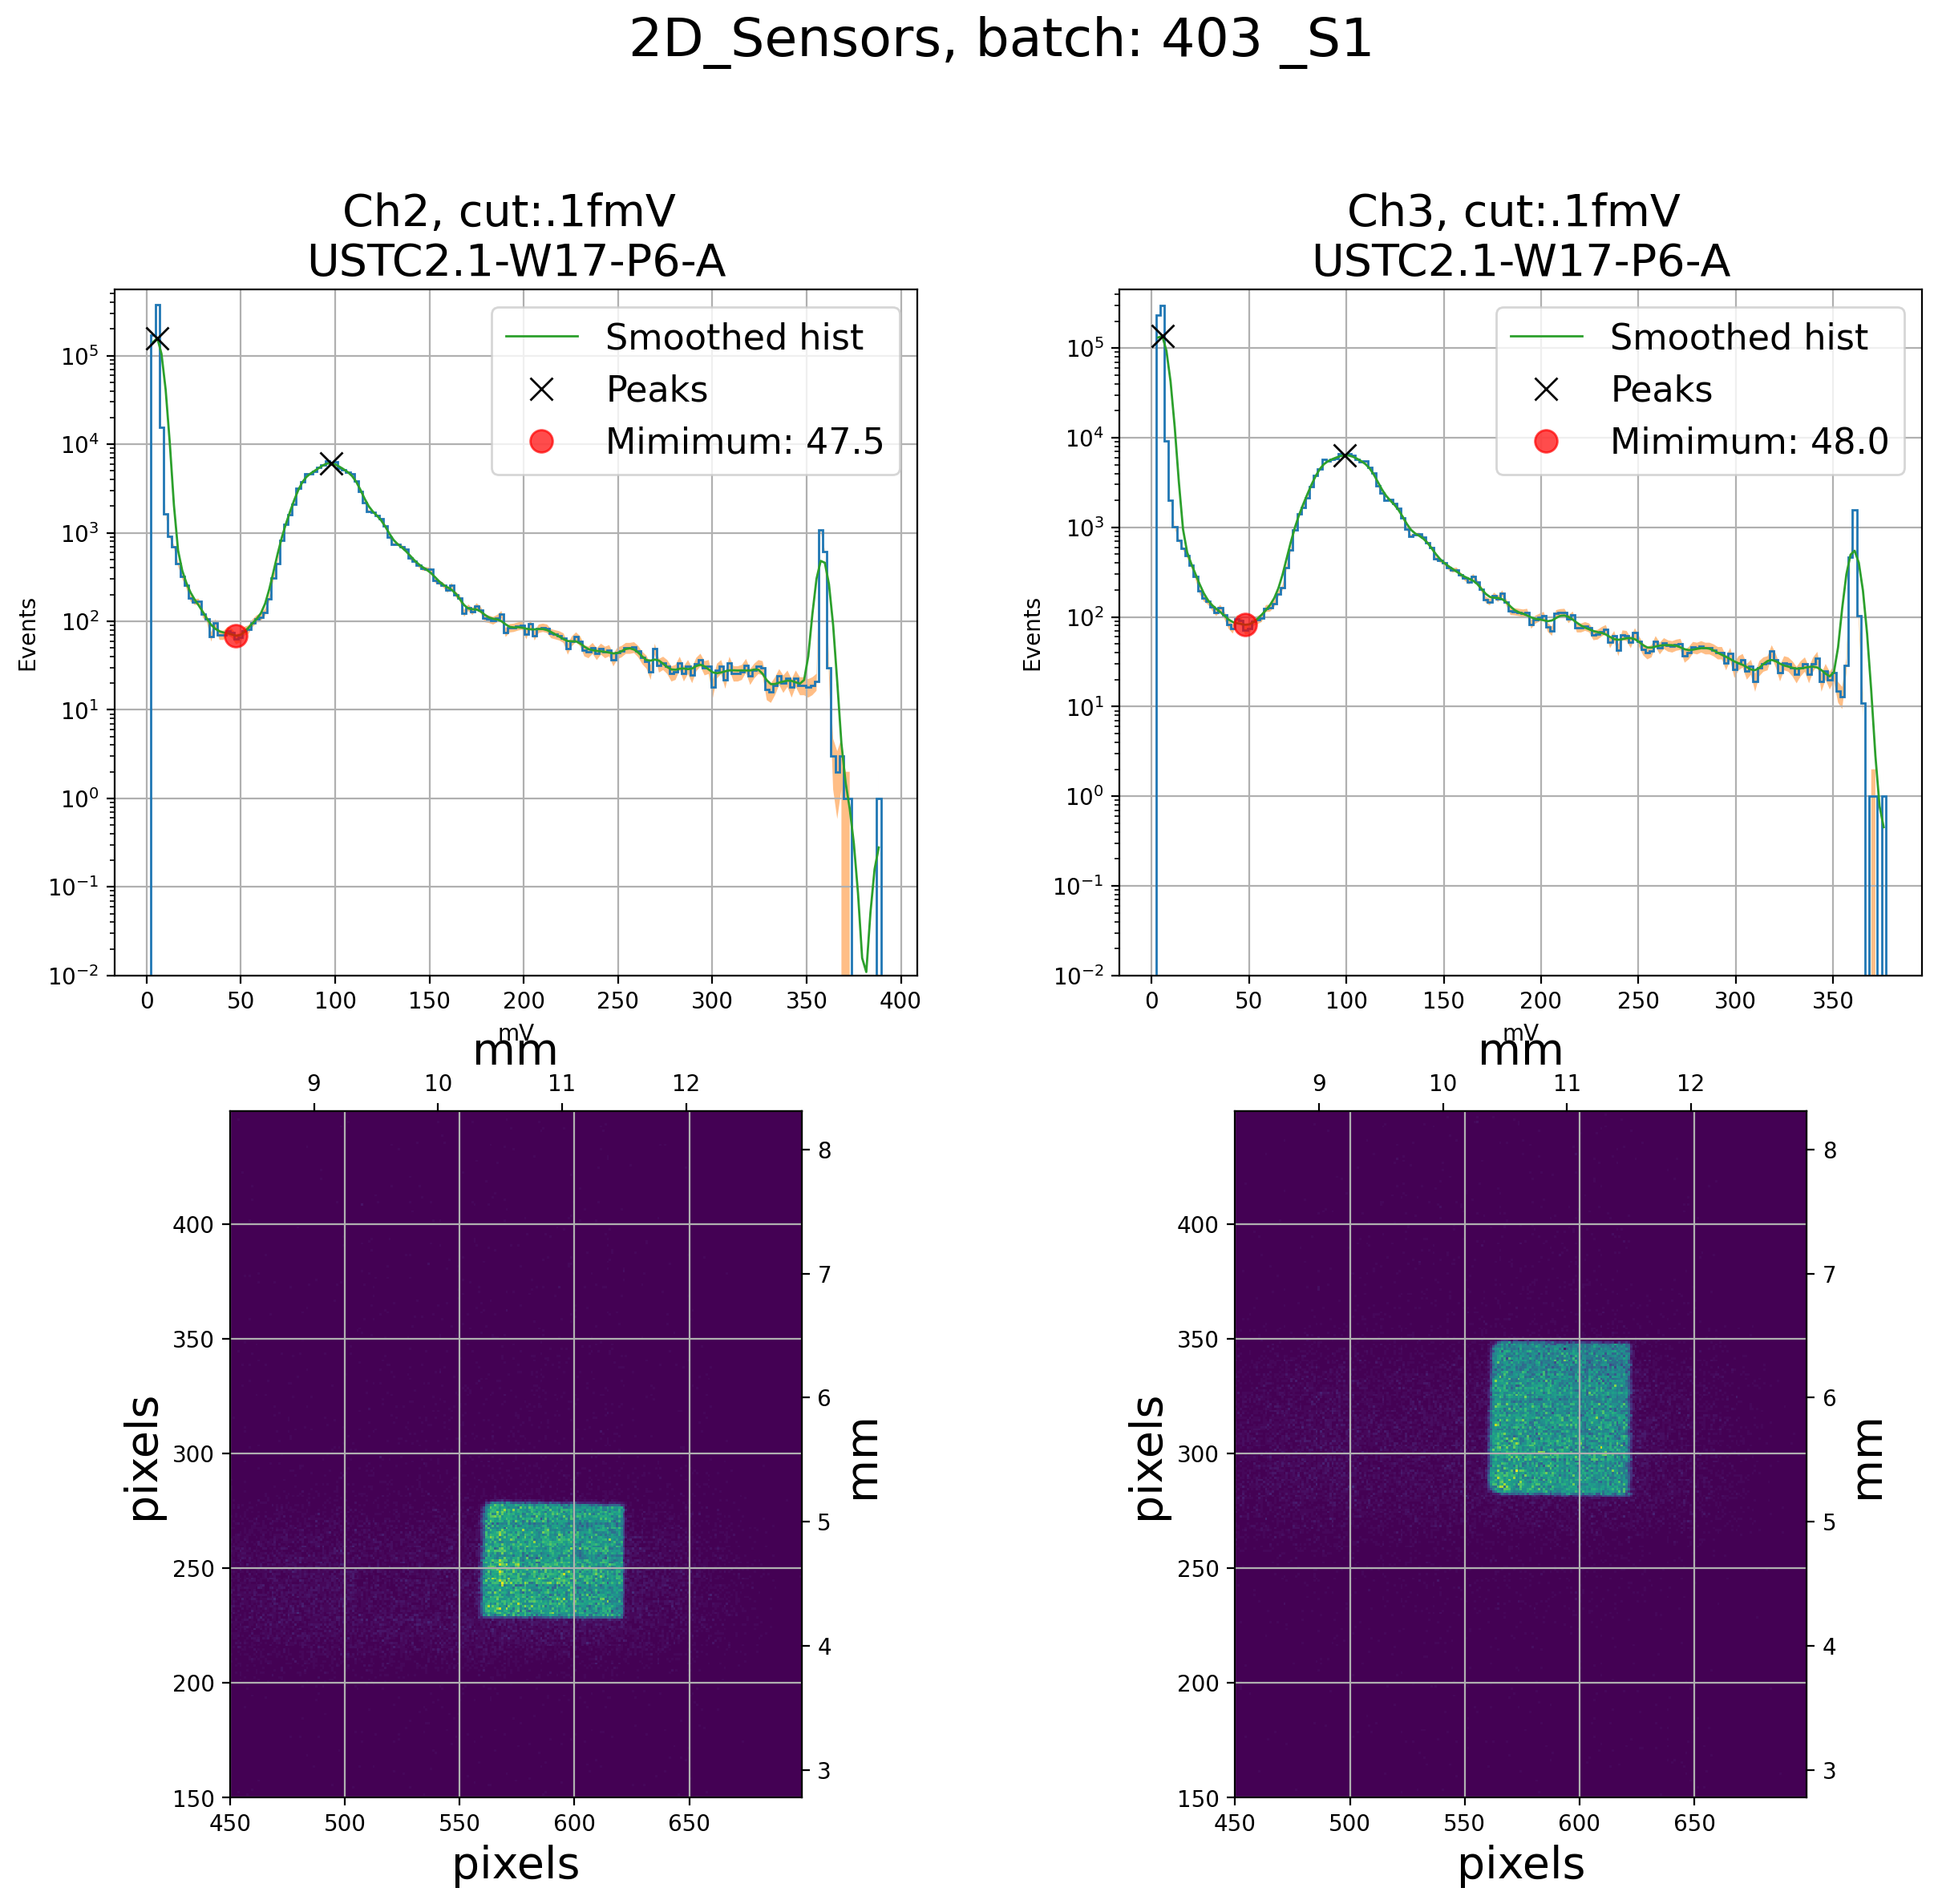

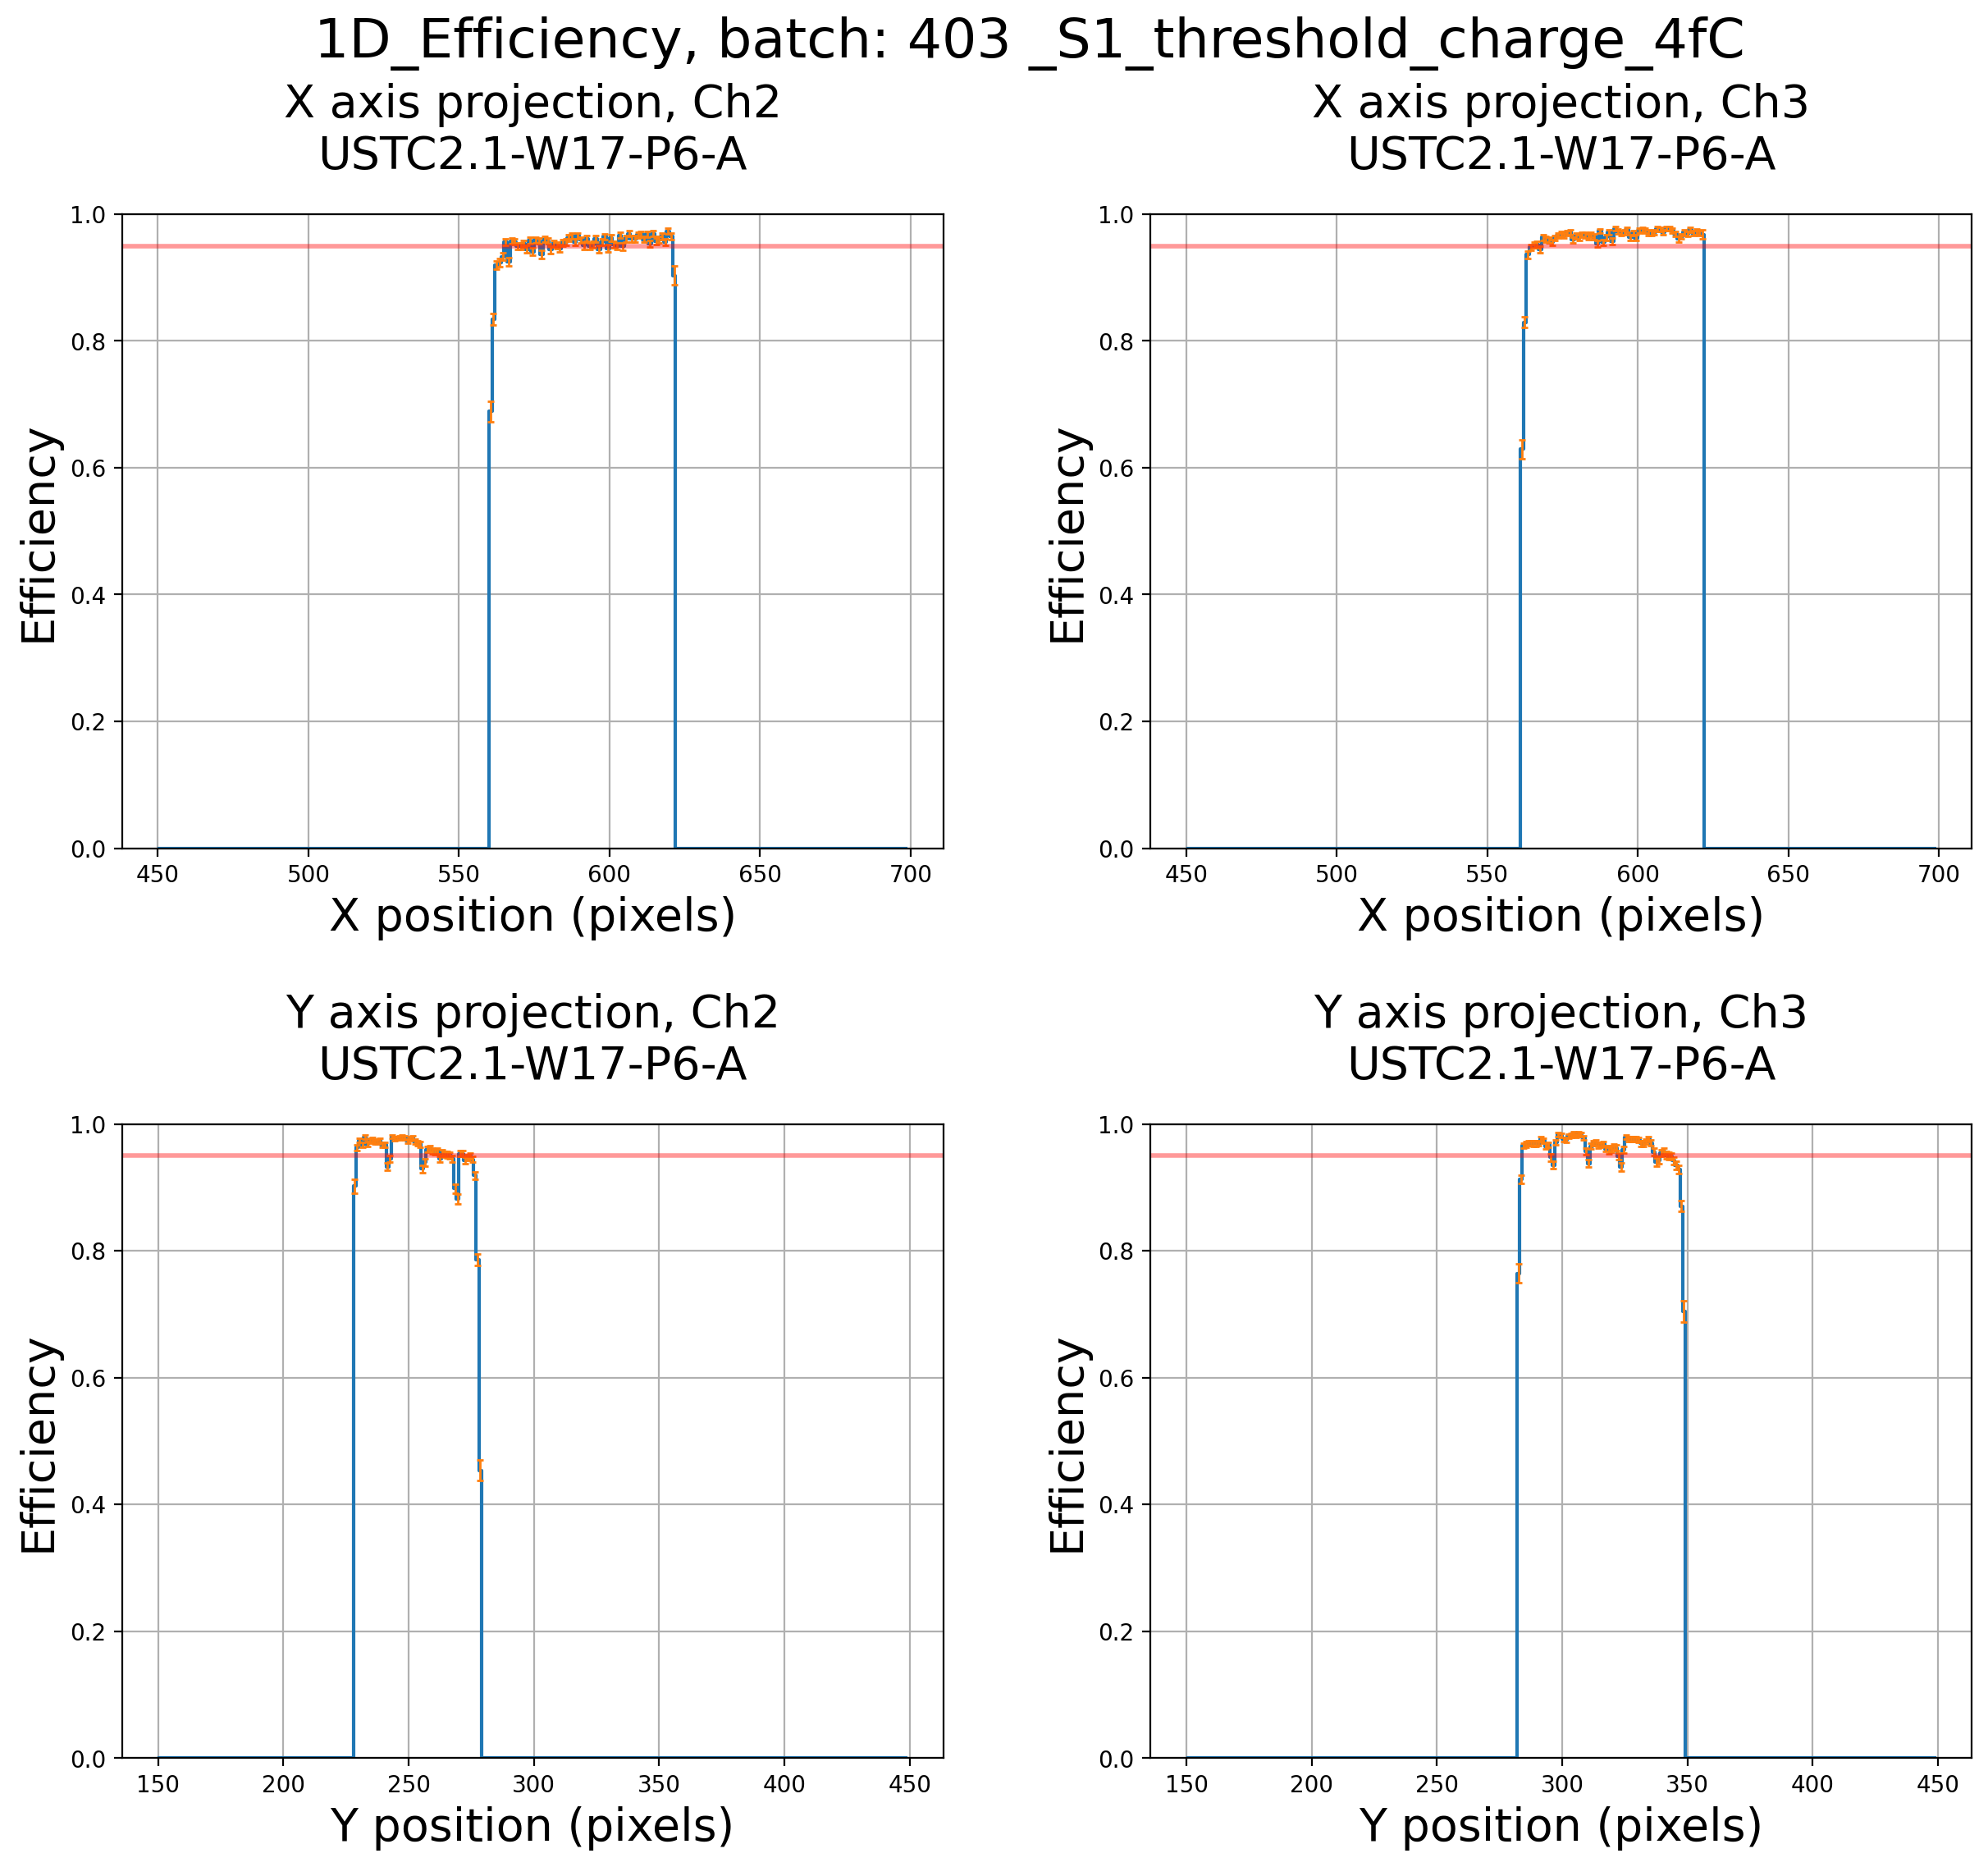

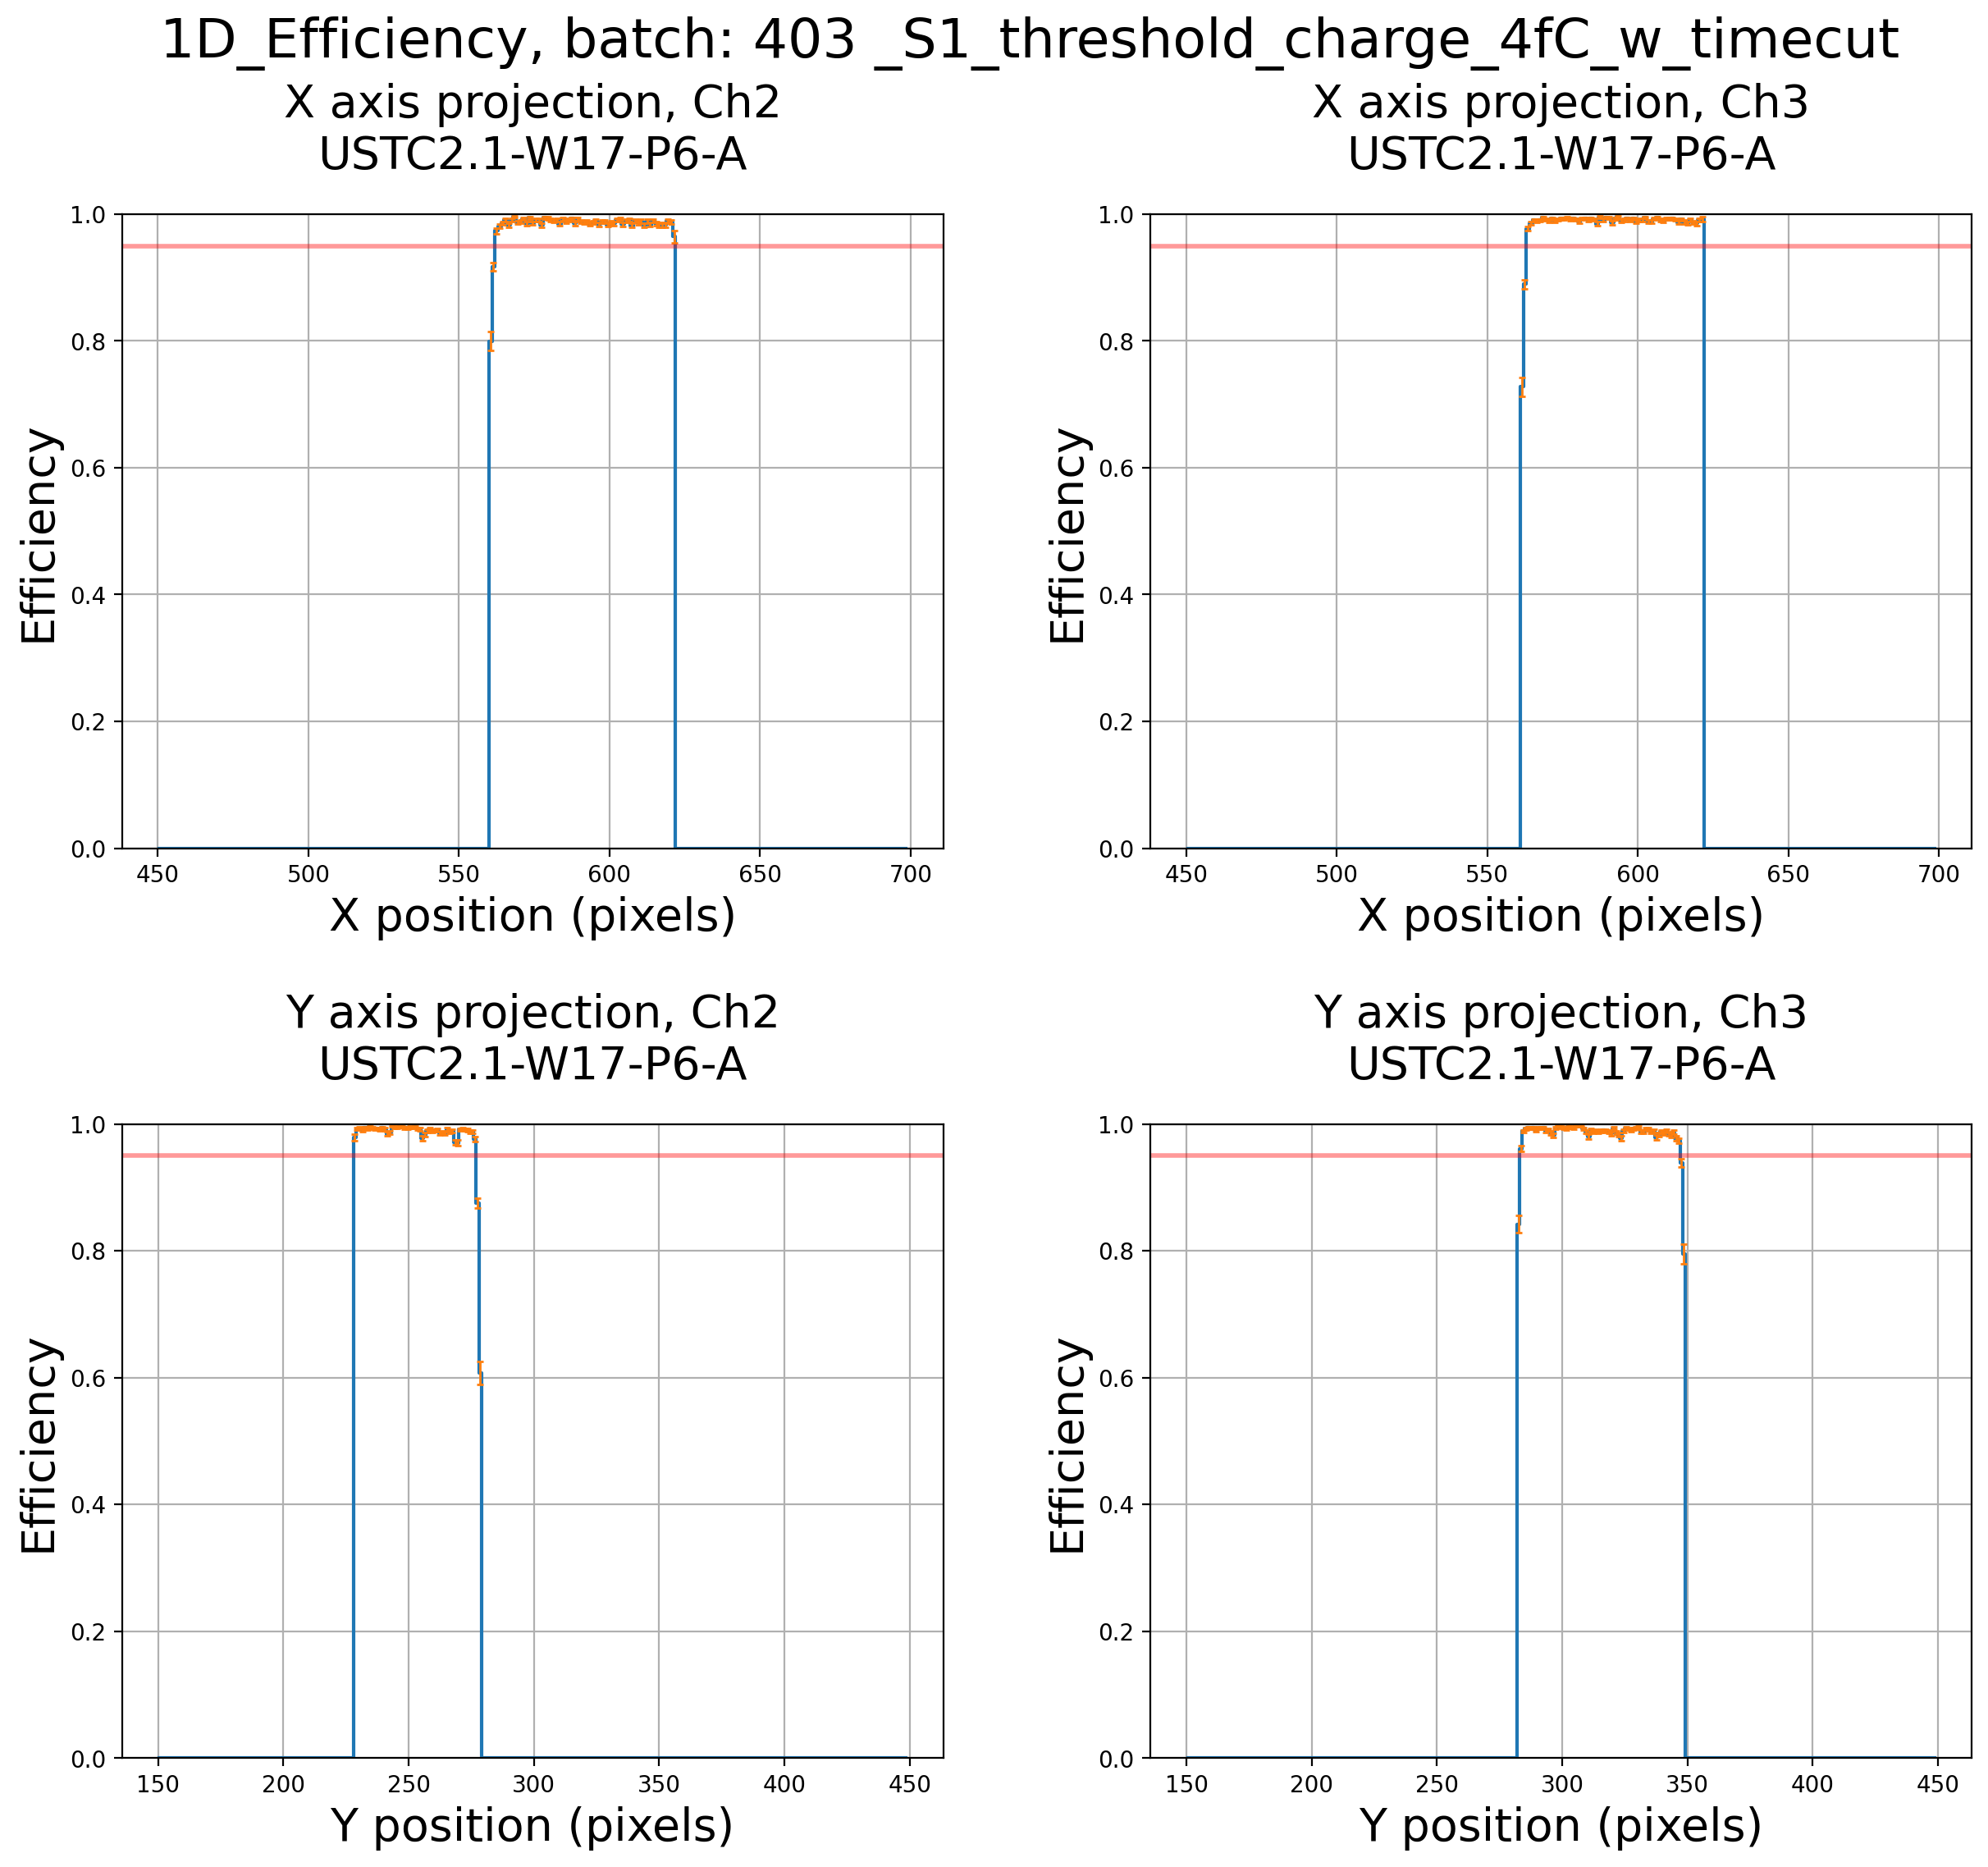

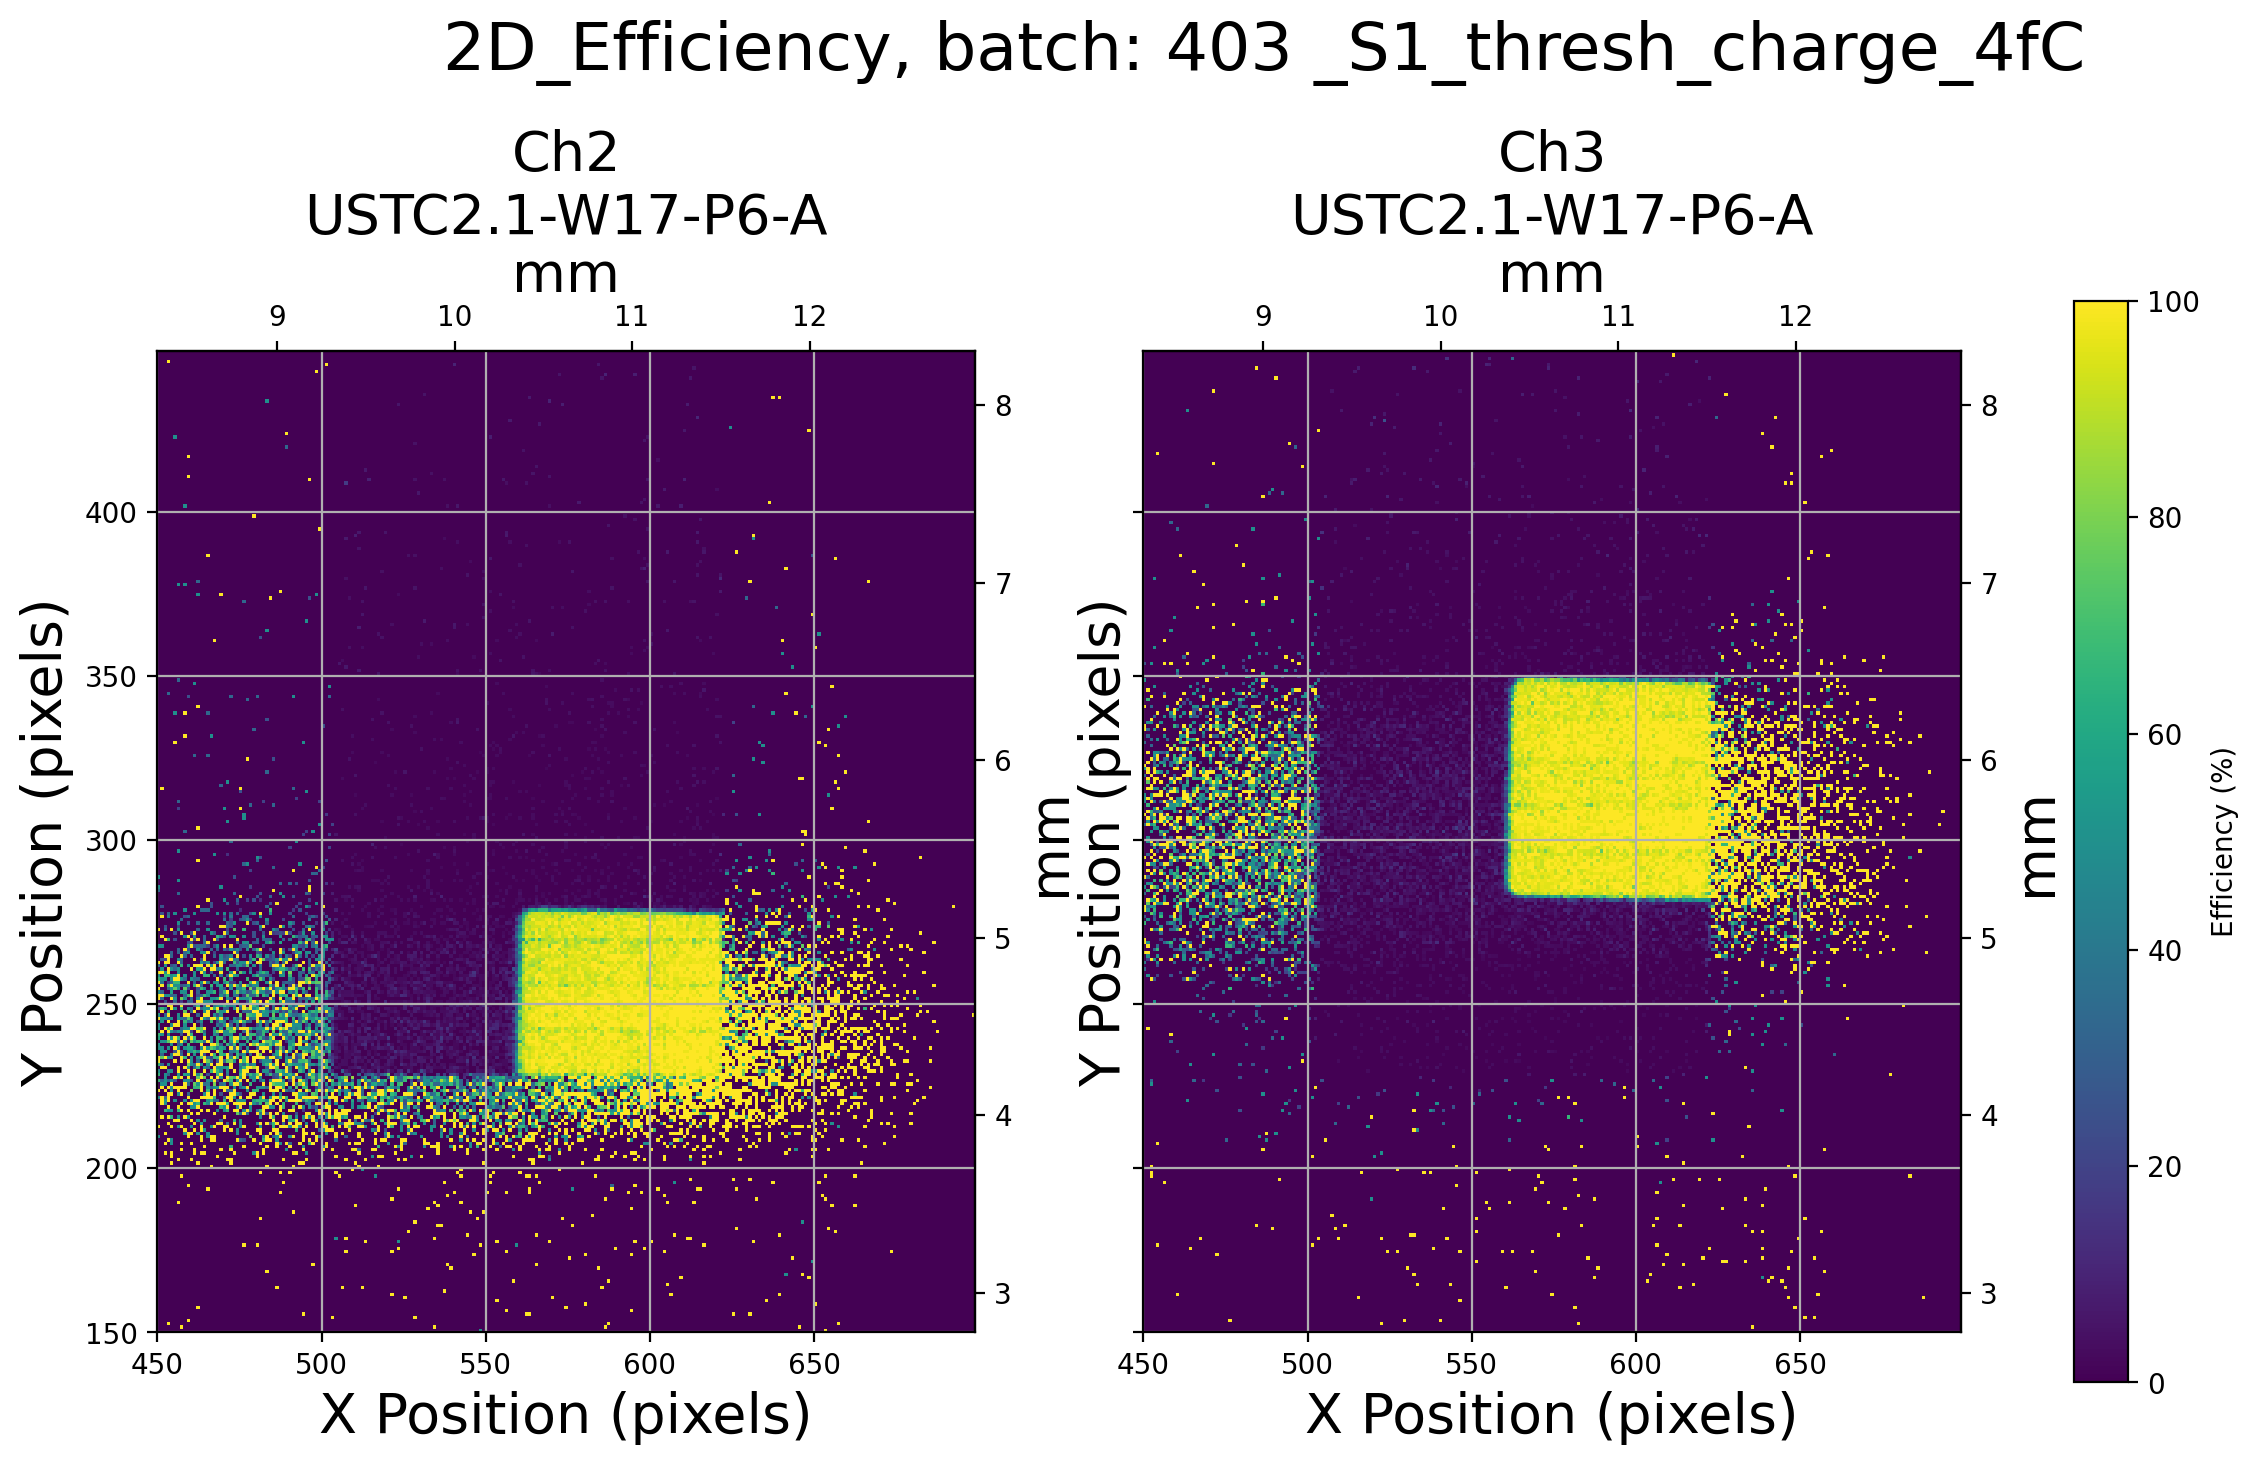

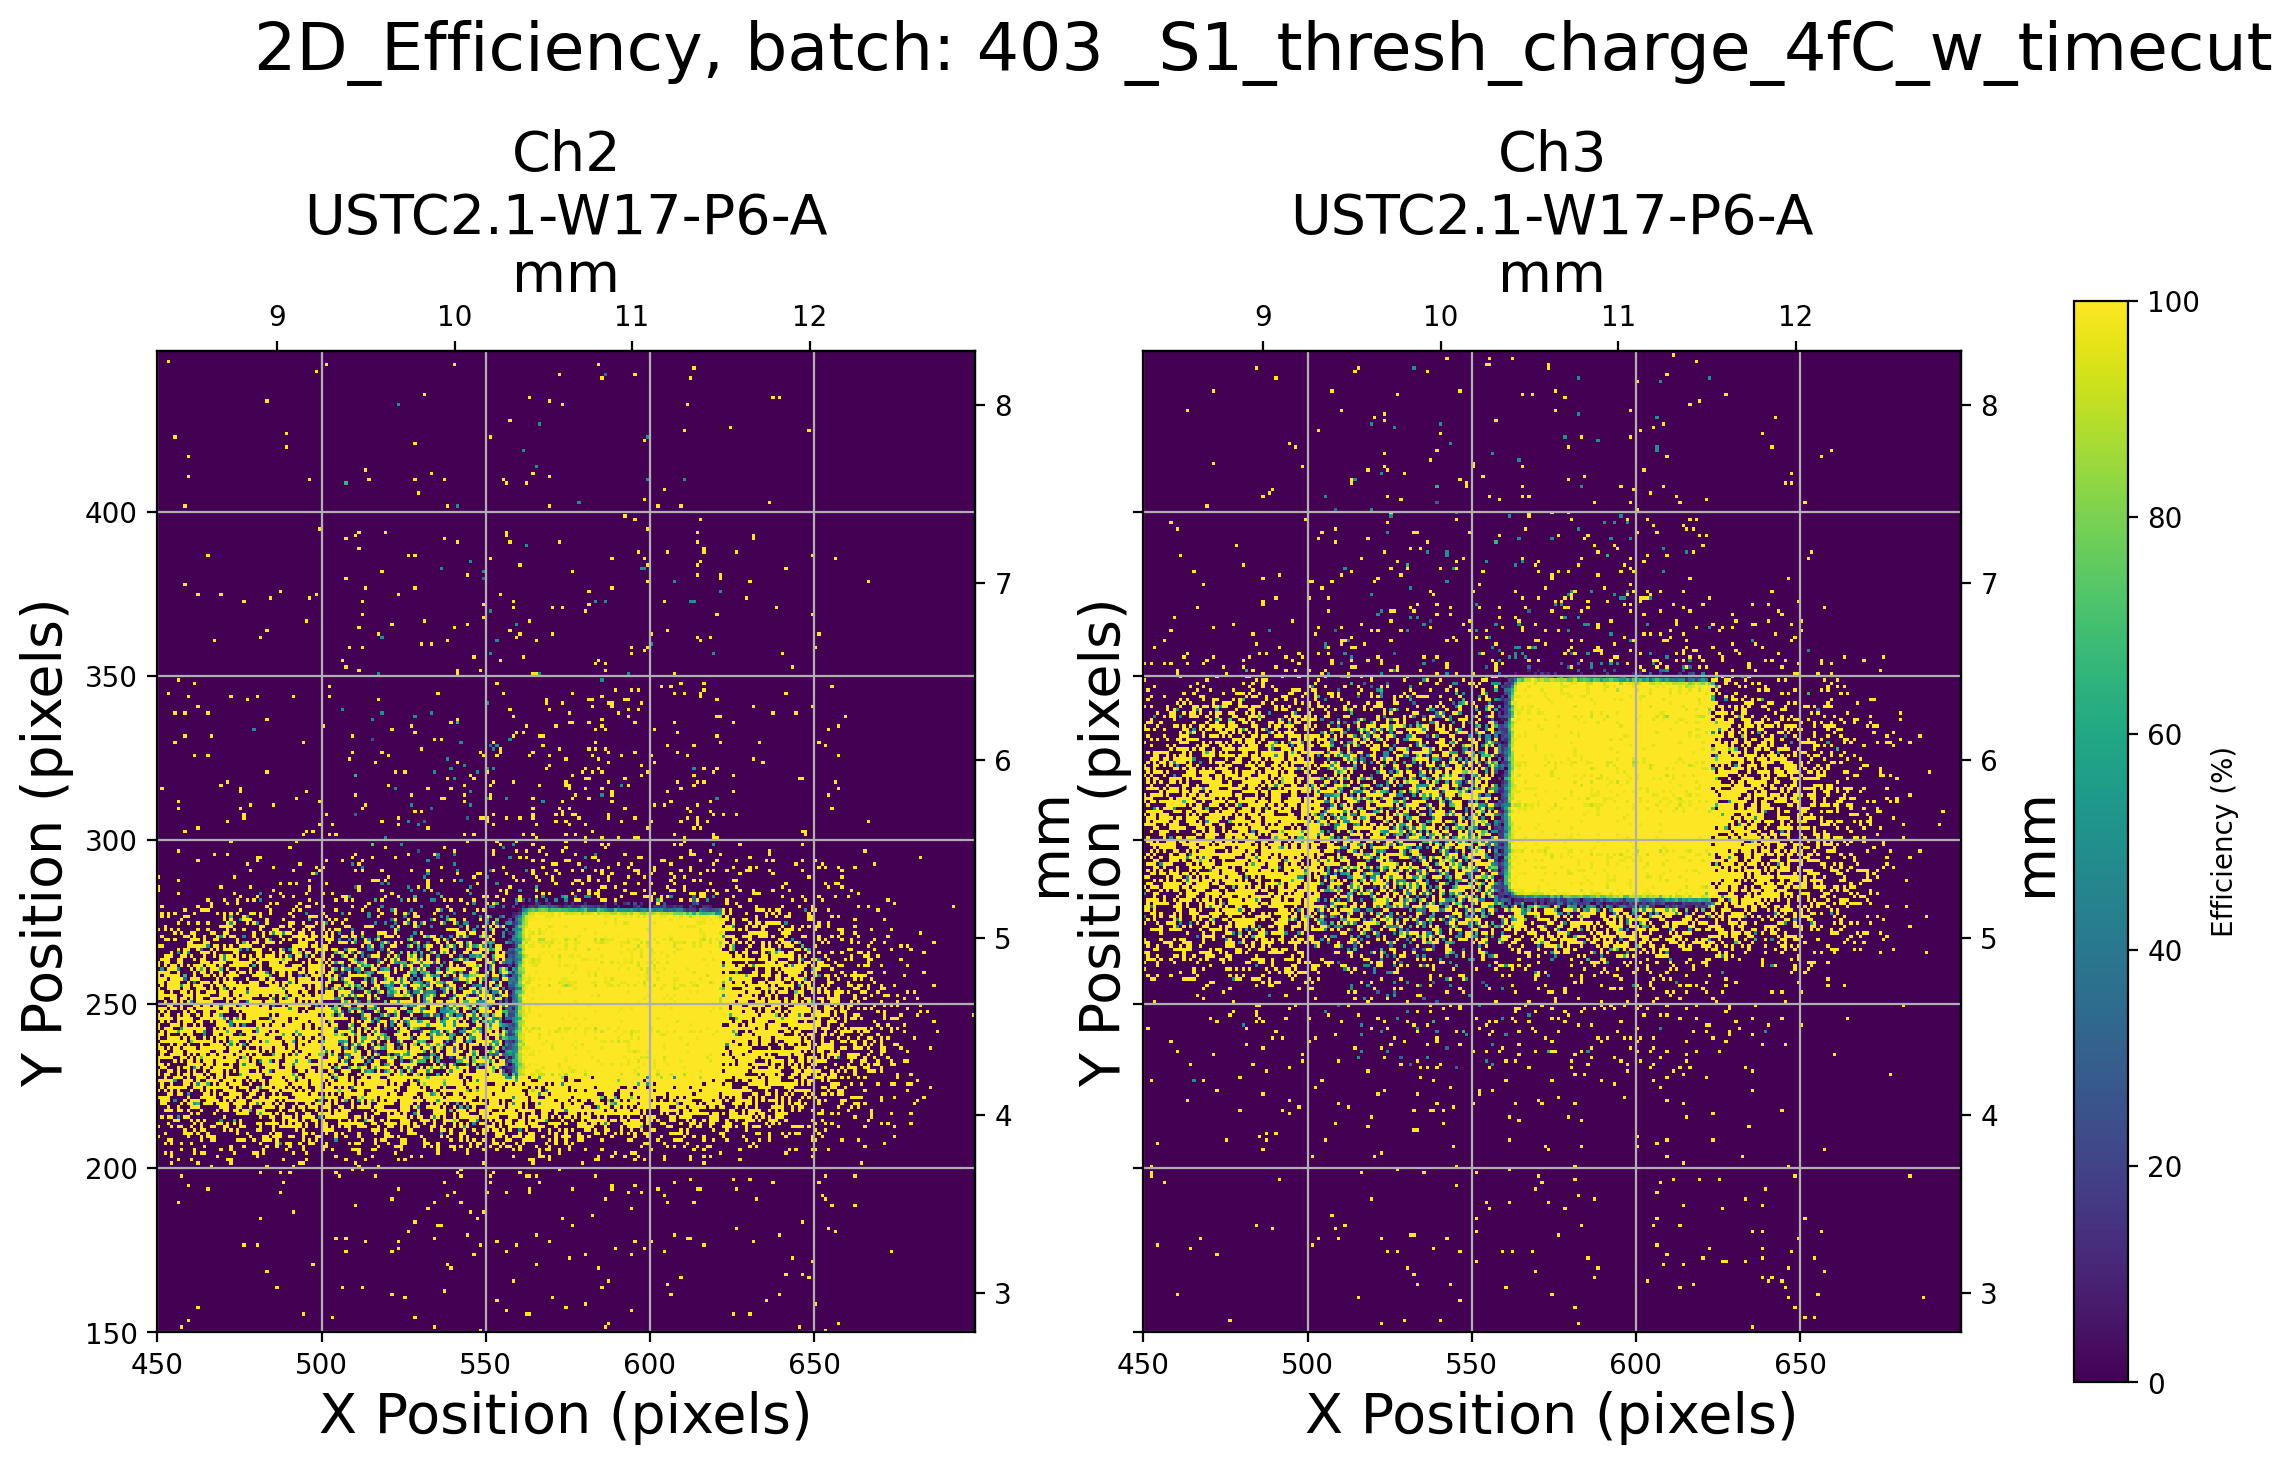

Batch:403, Scope:S1, Channel:Ch2
Batch:403, Scope:S1, Channel:Ch3
DUT_1
DUT_2


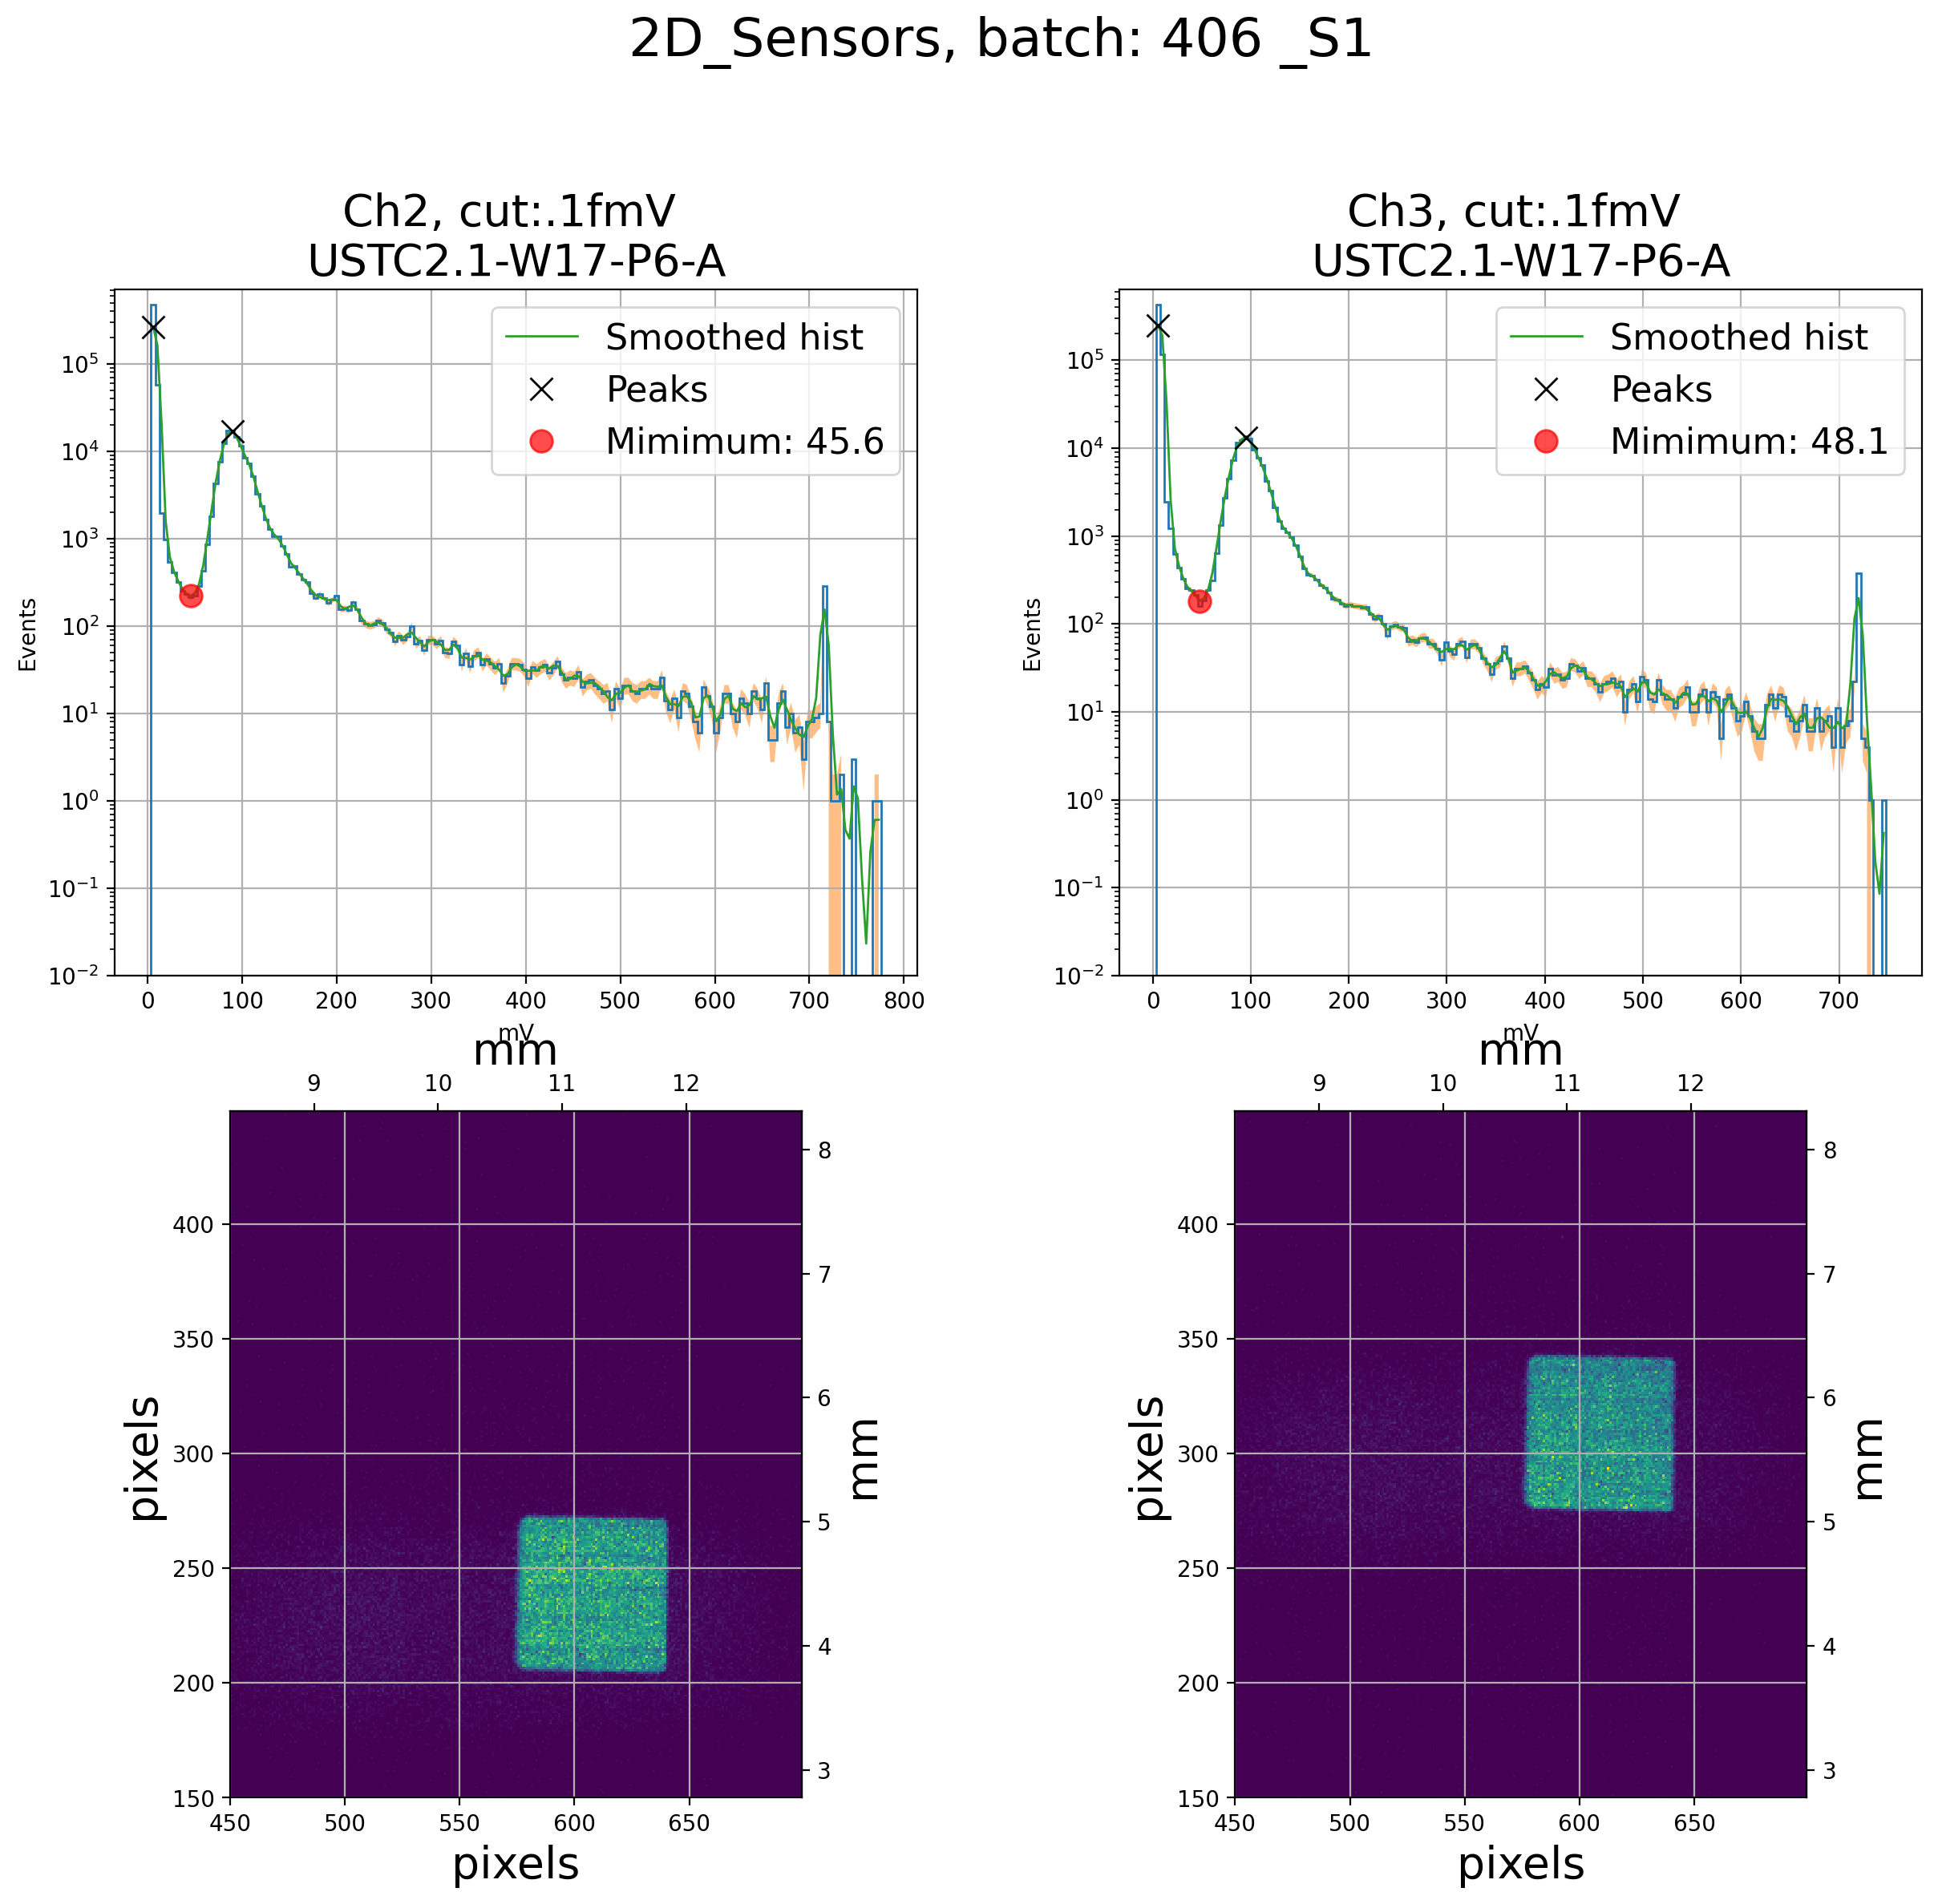

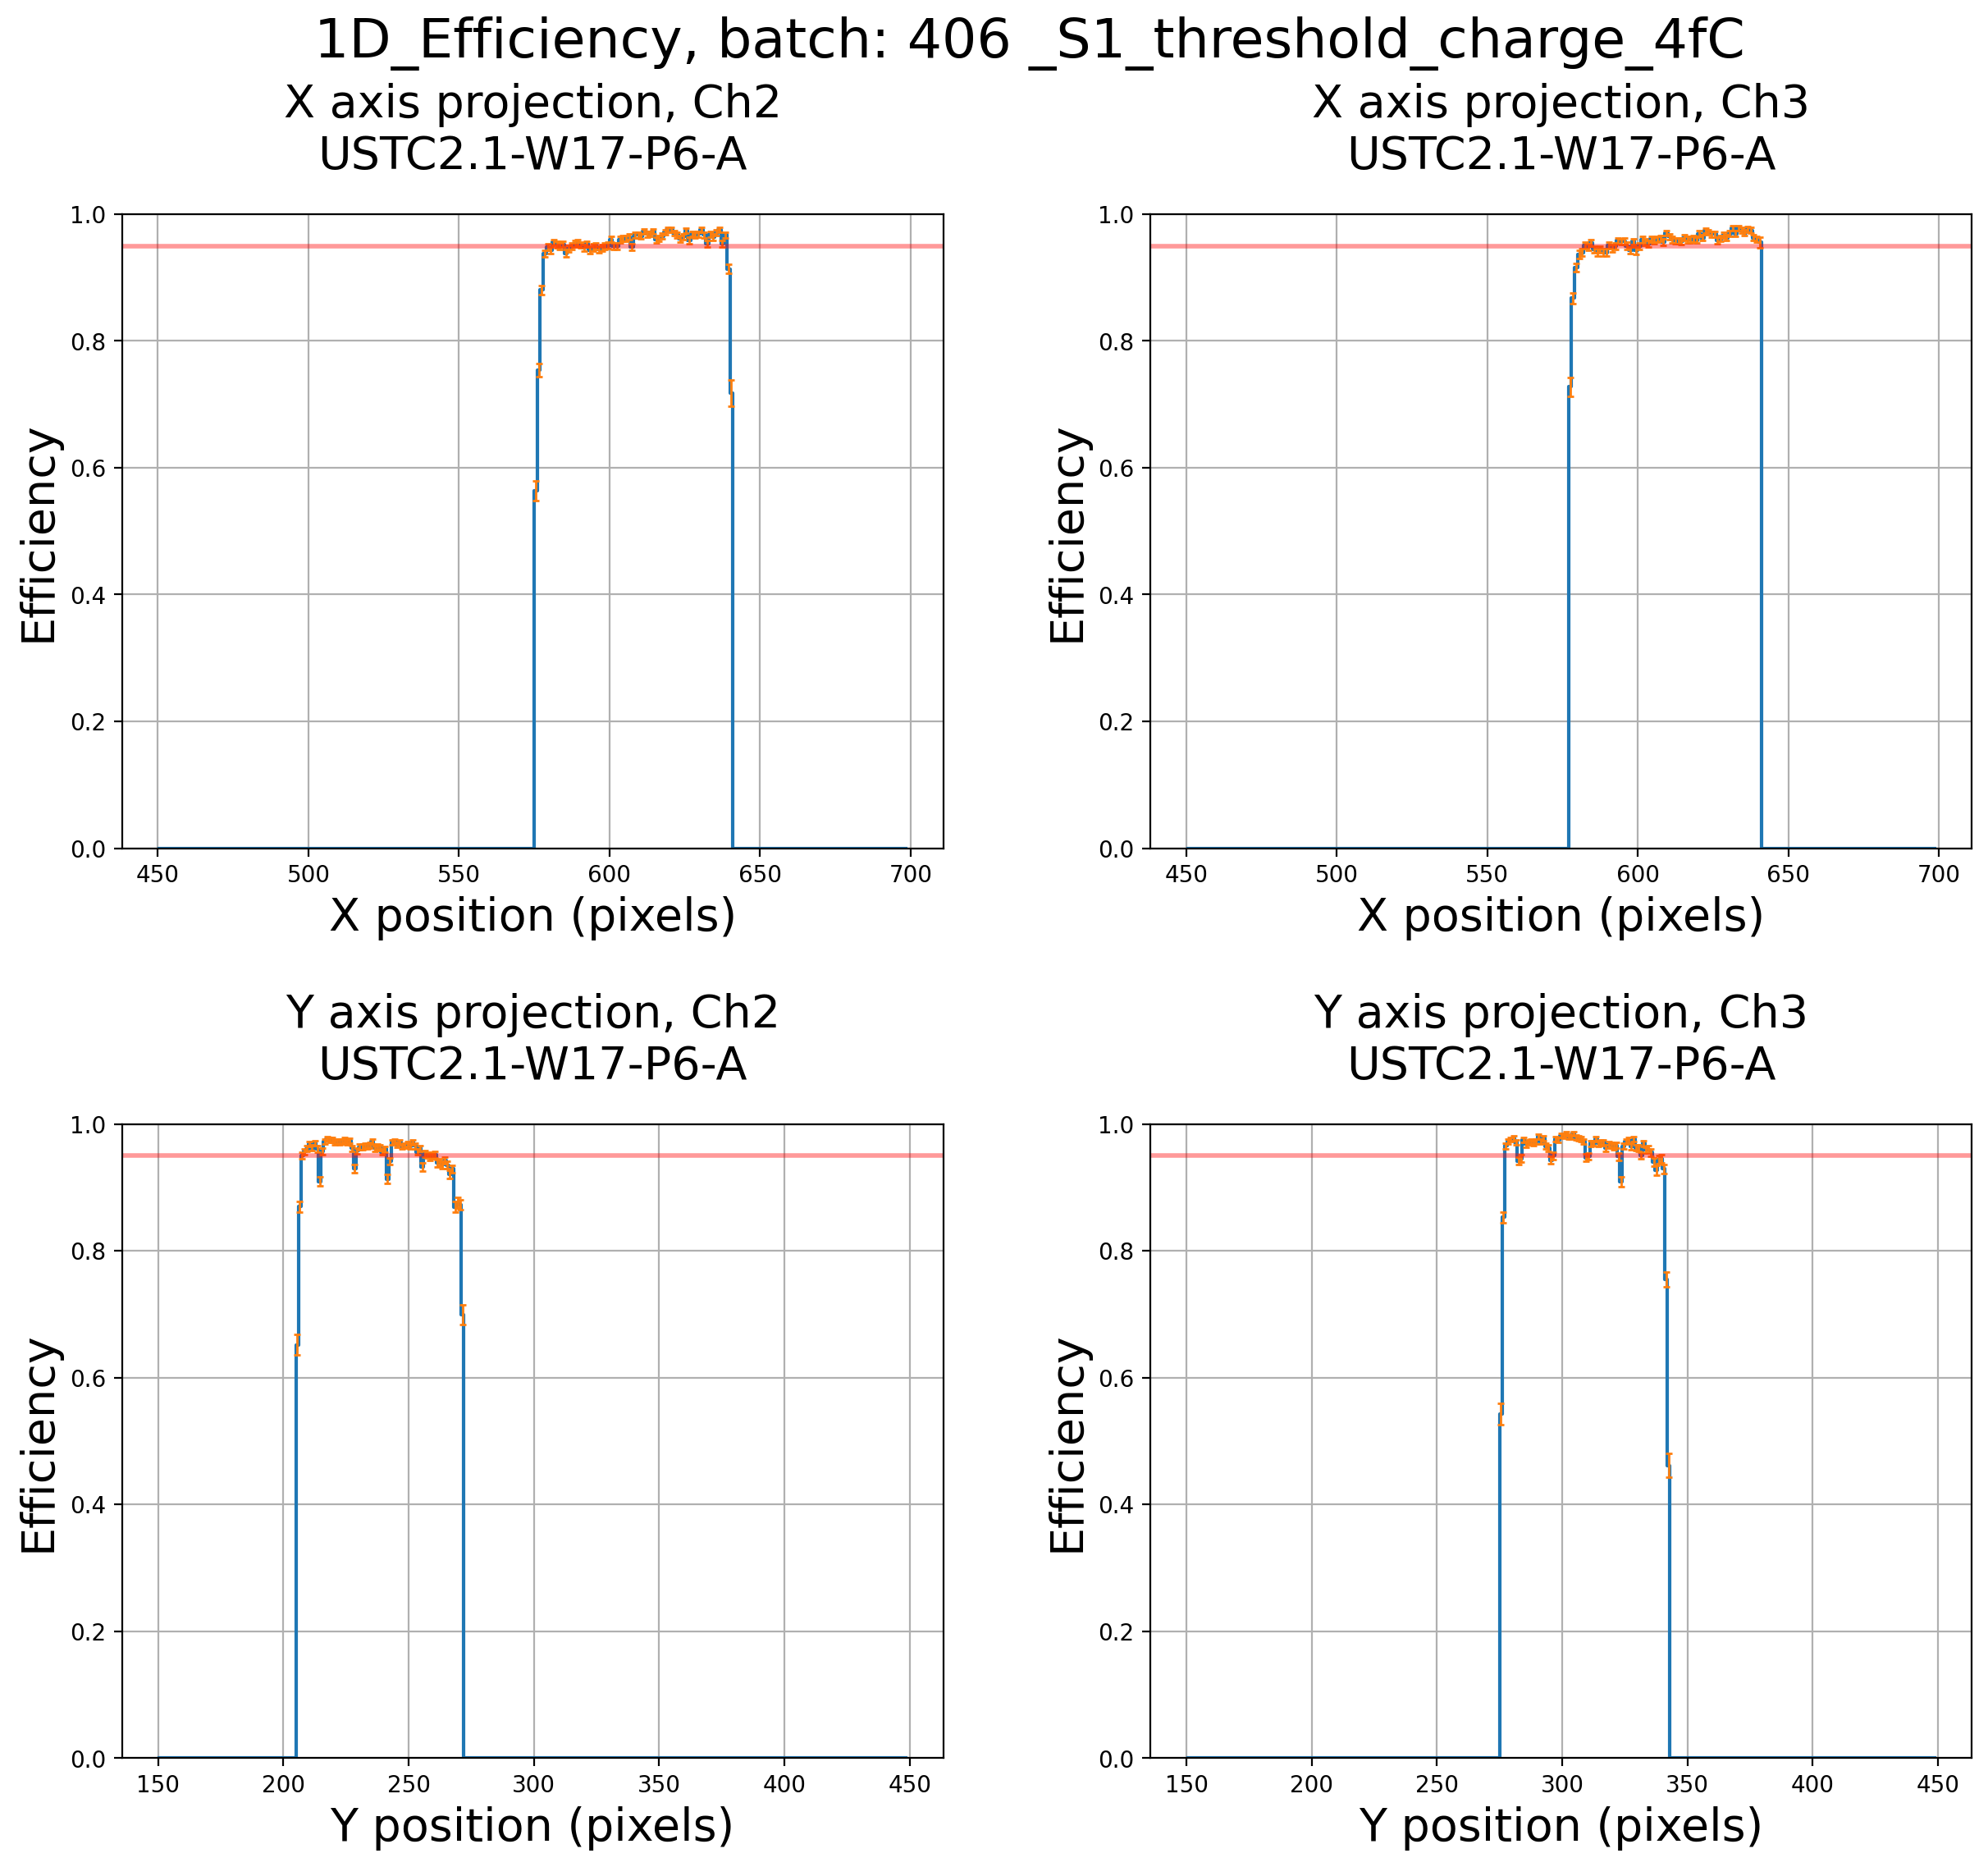

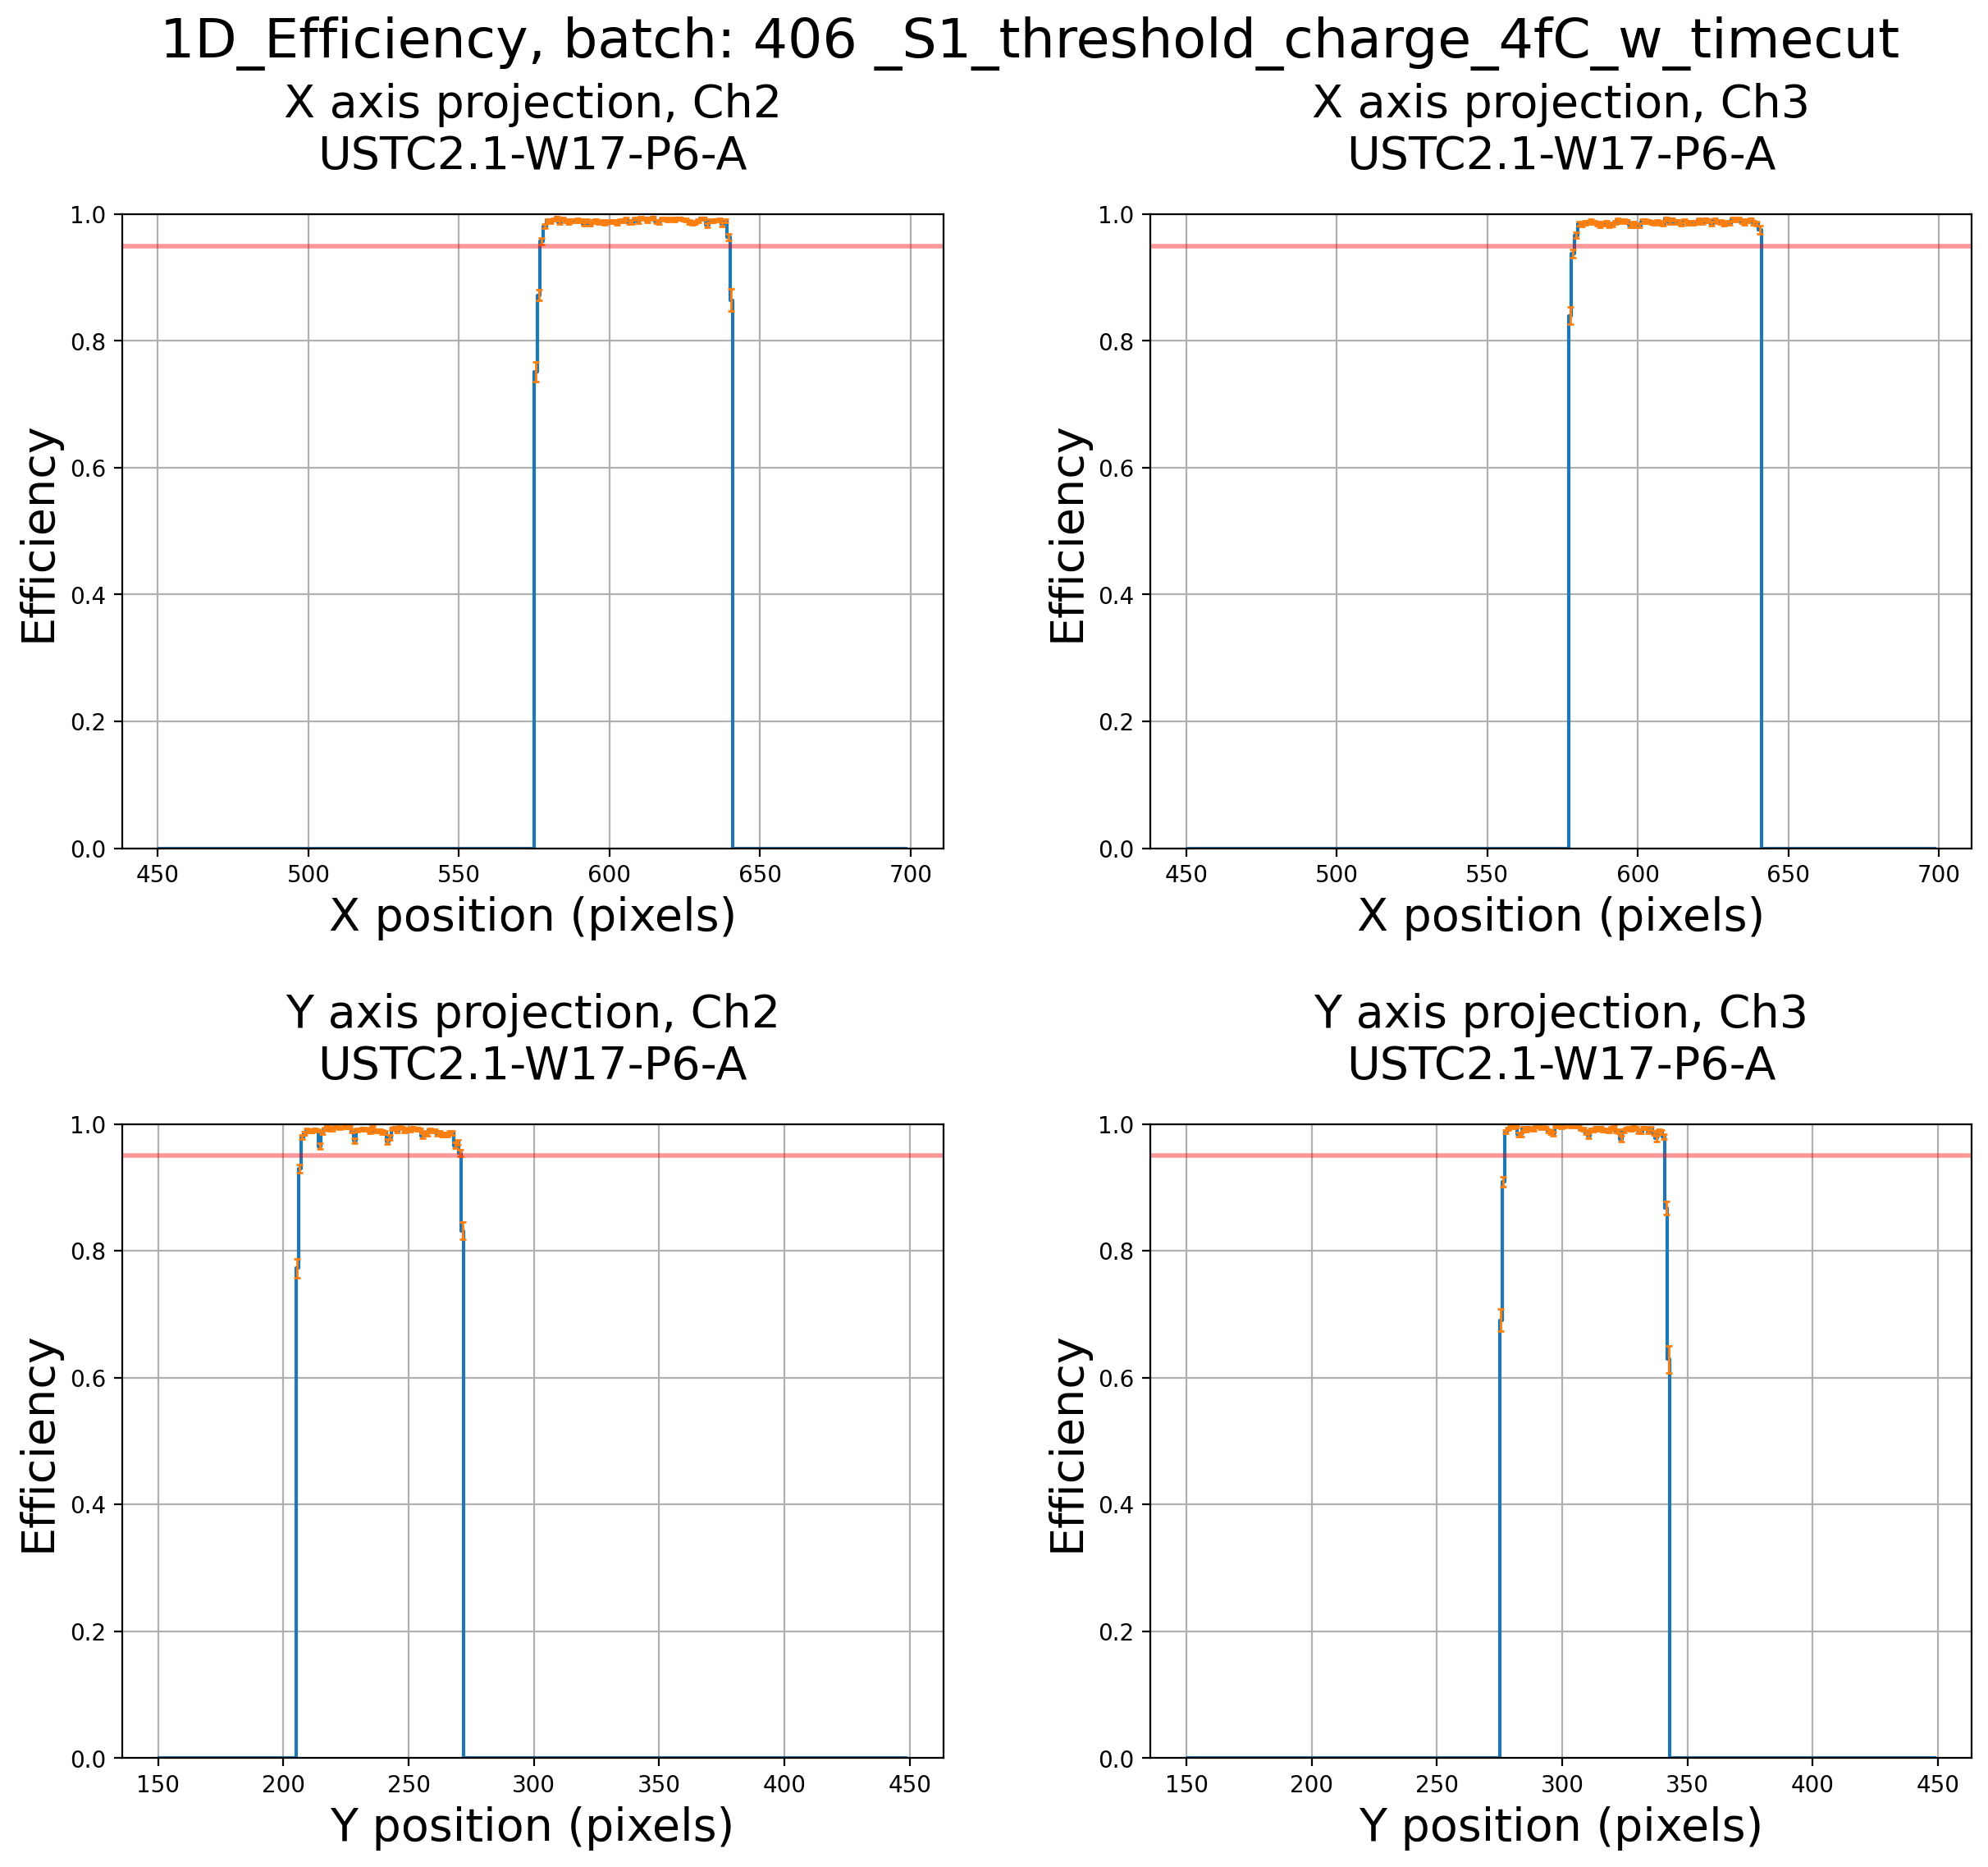

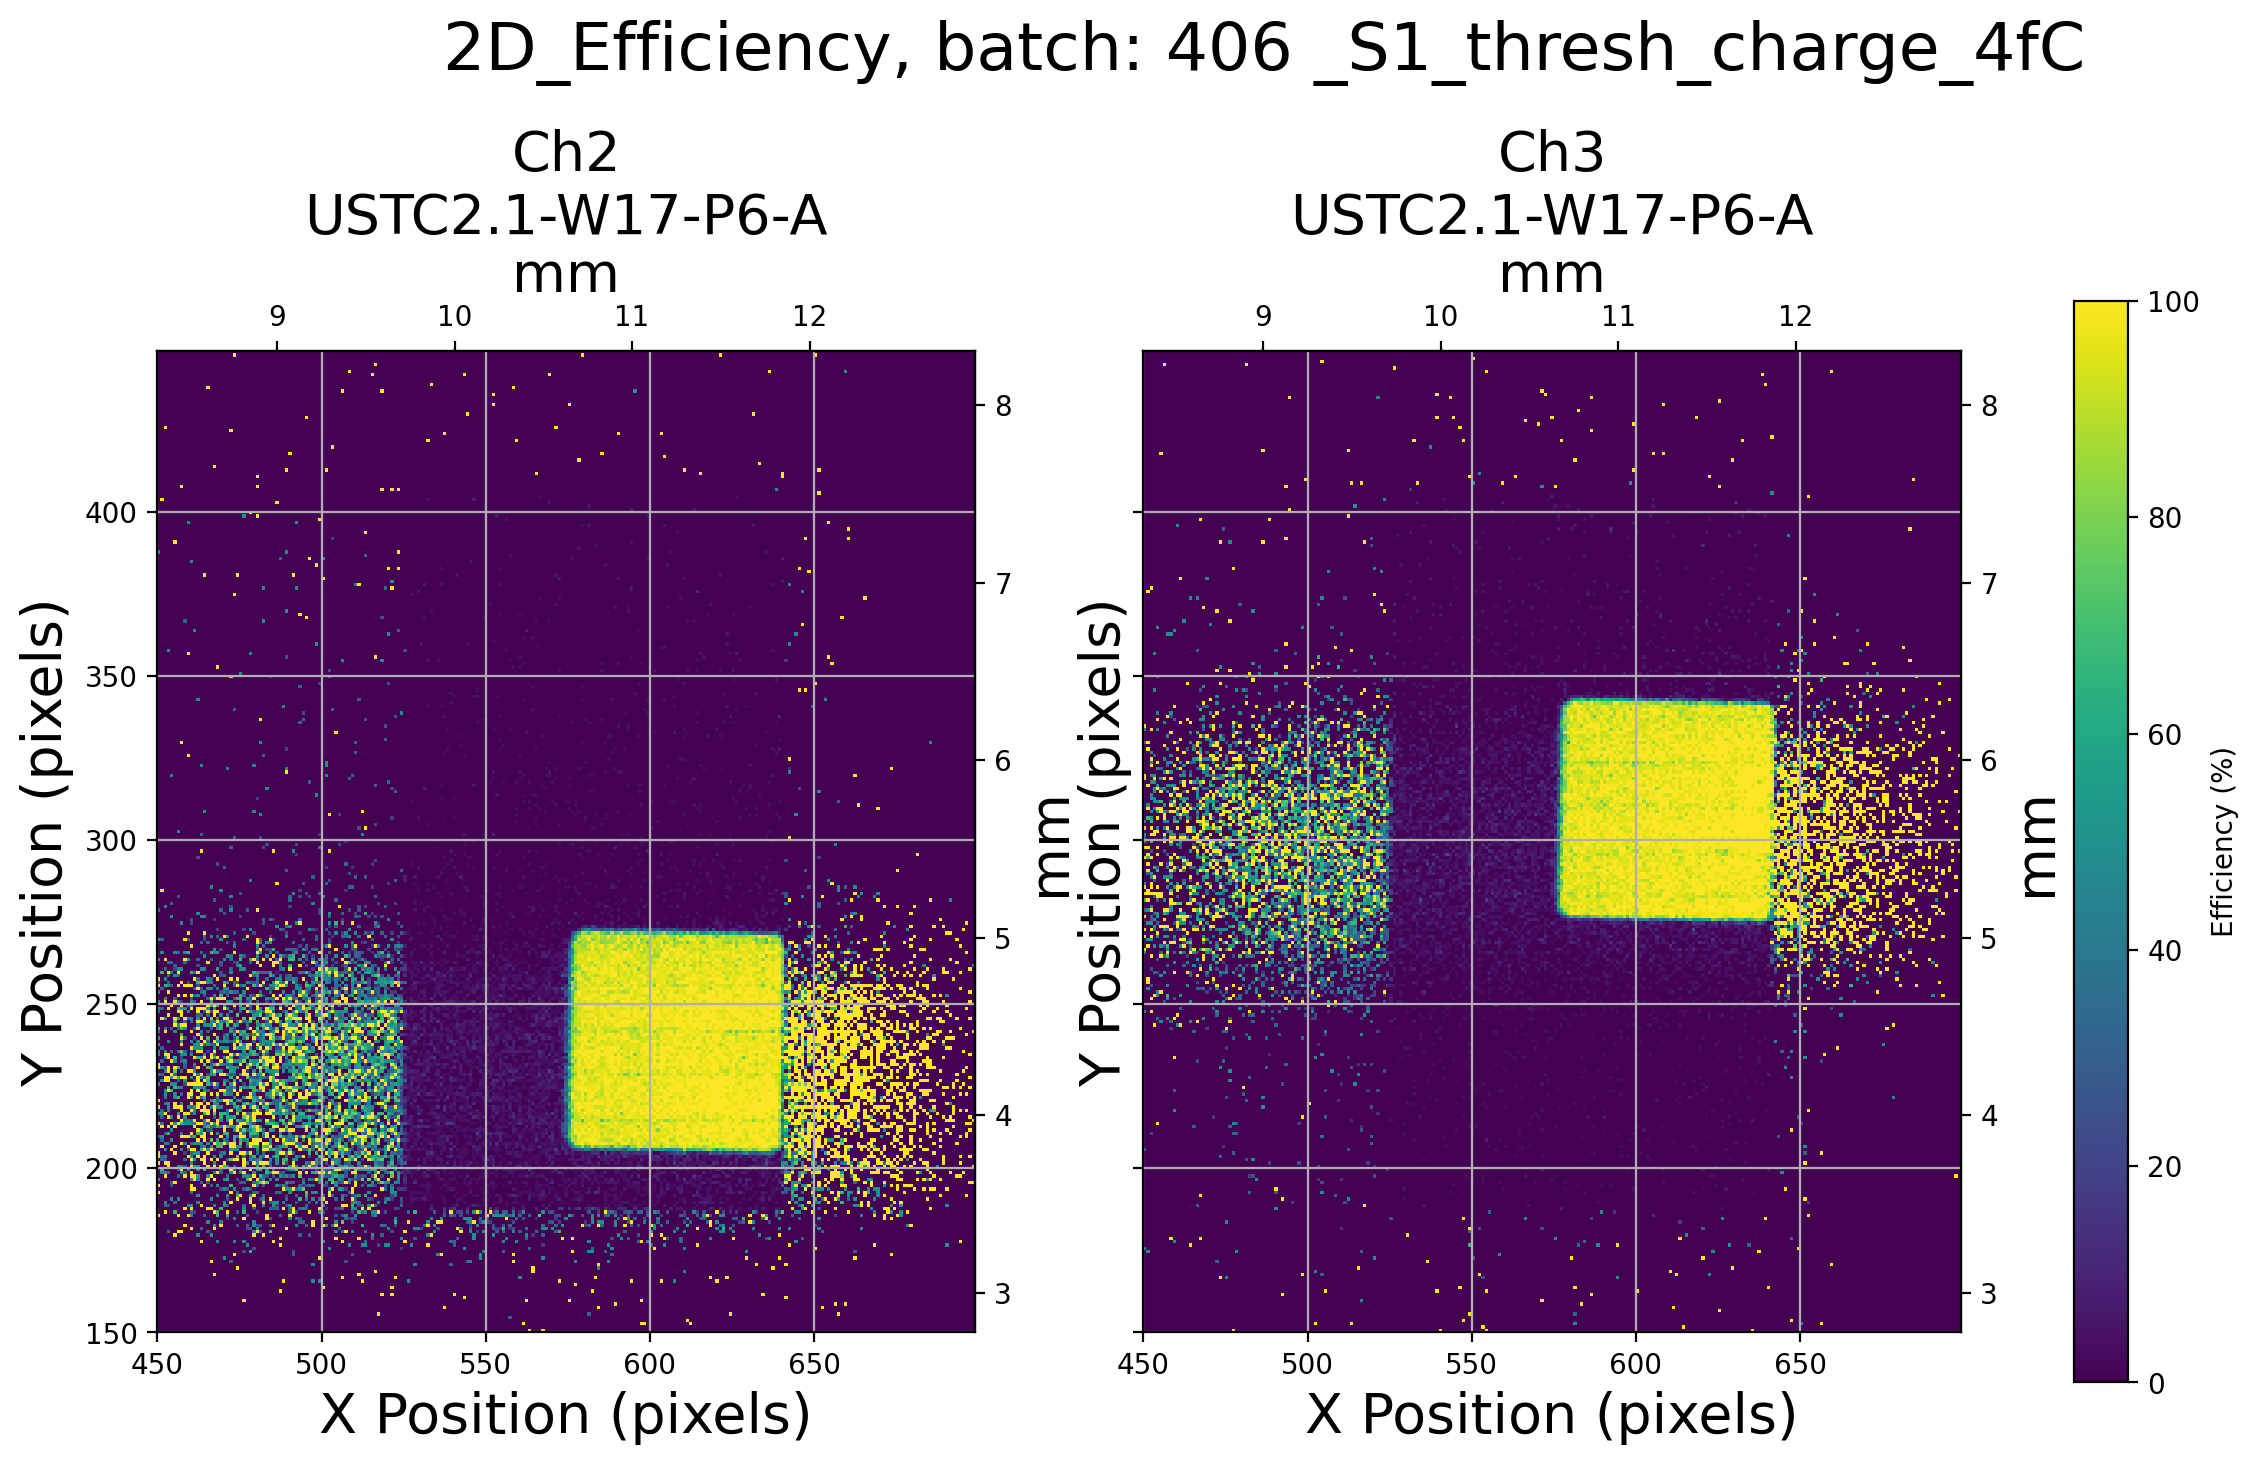

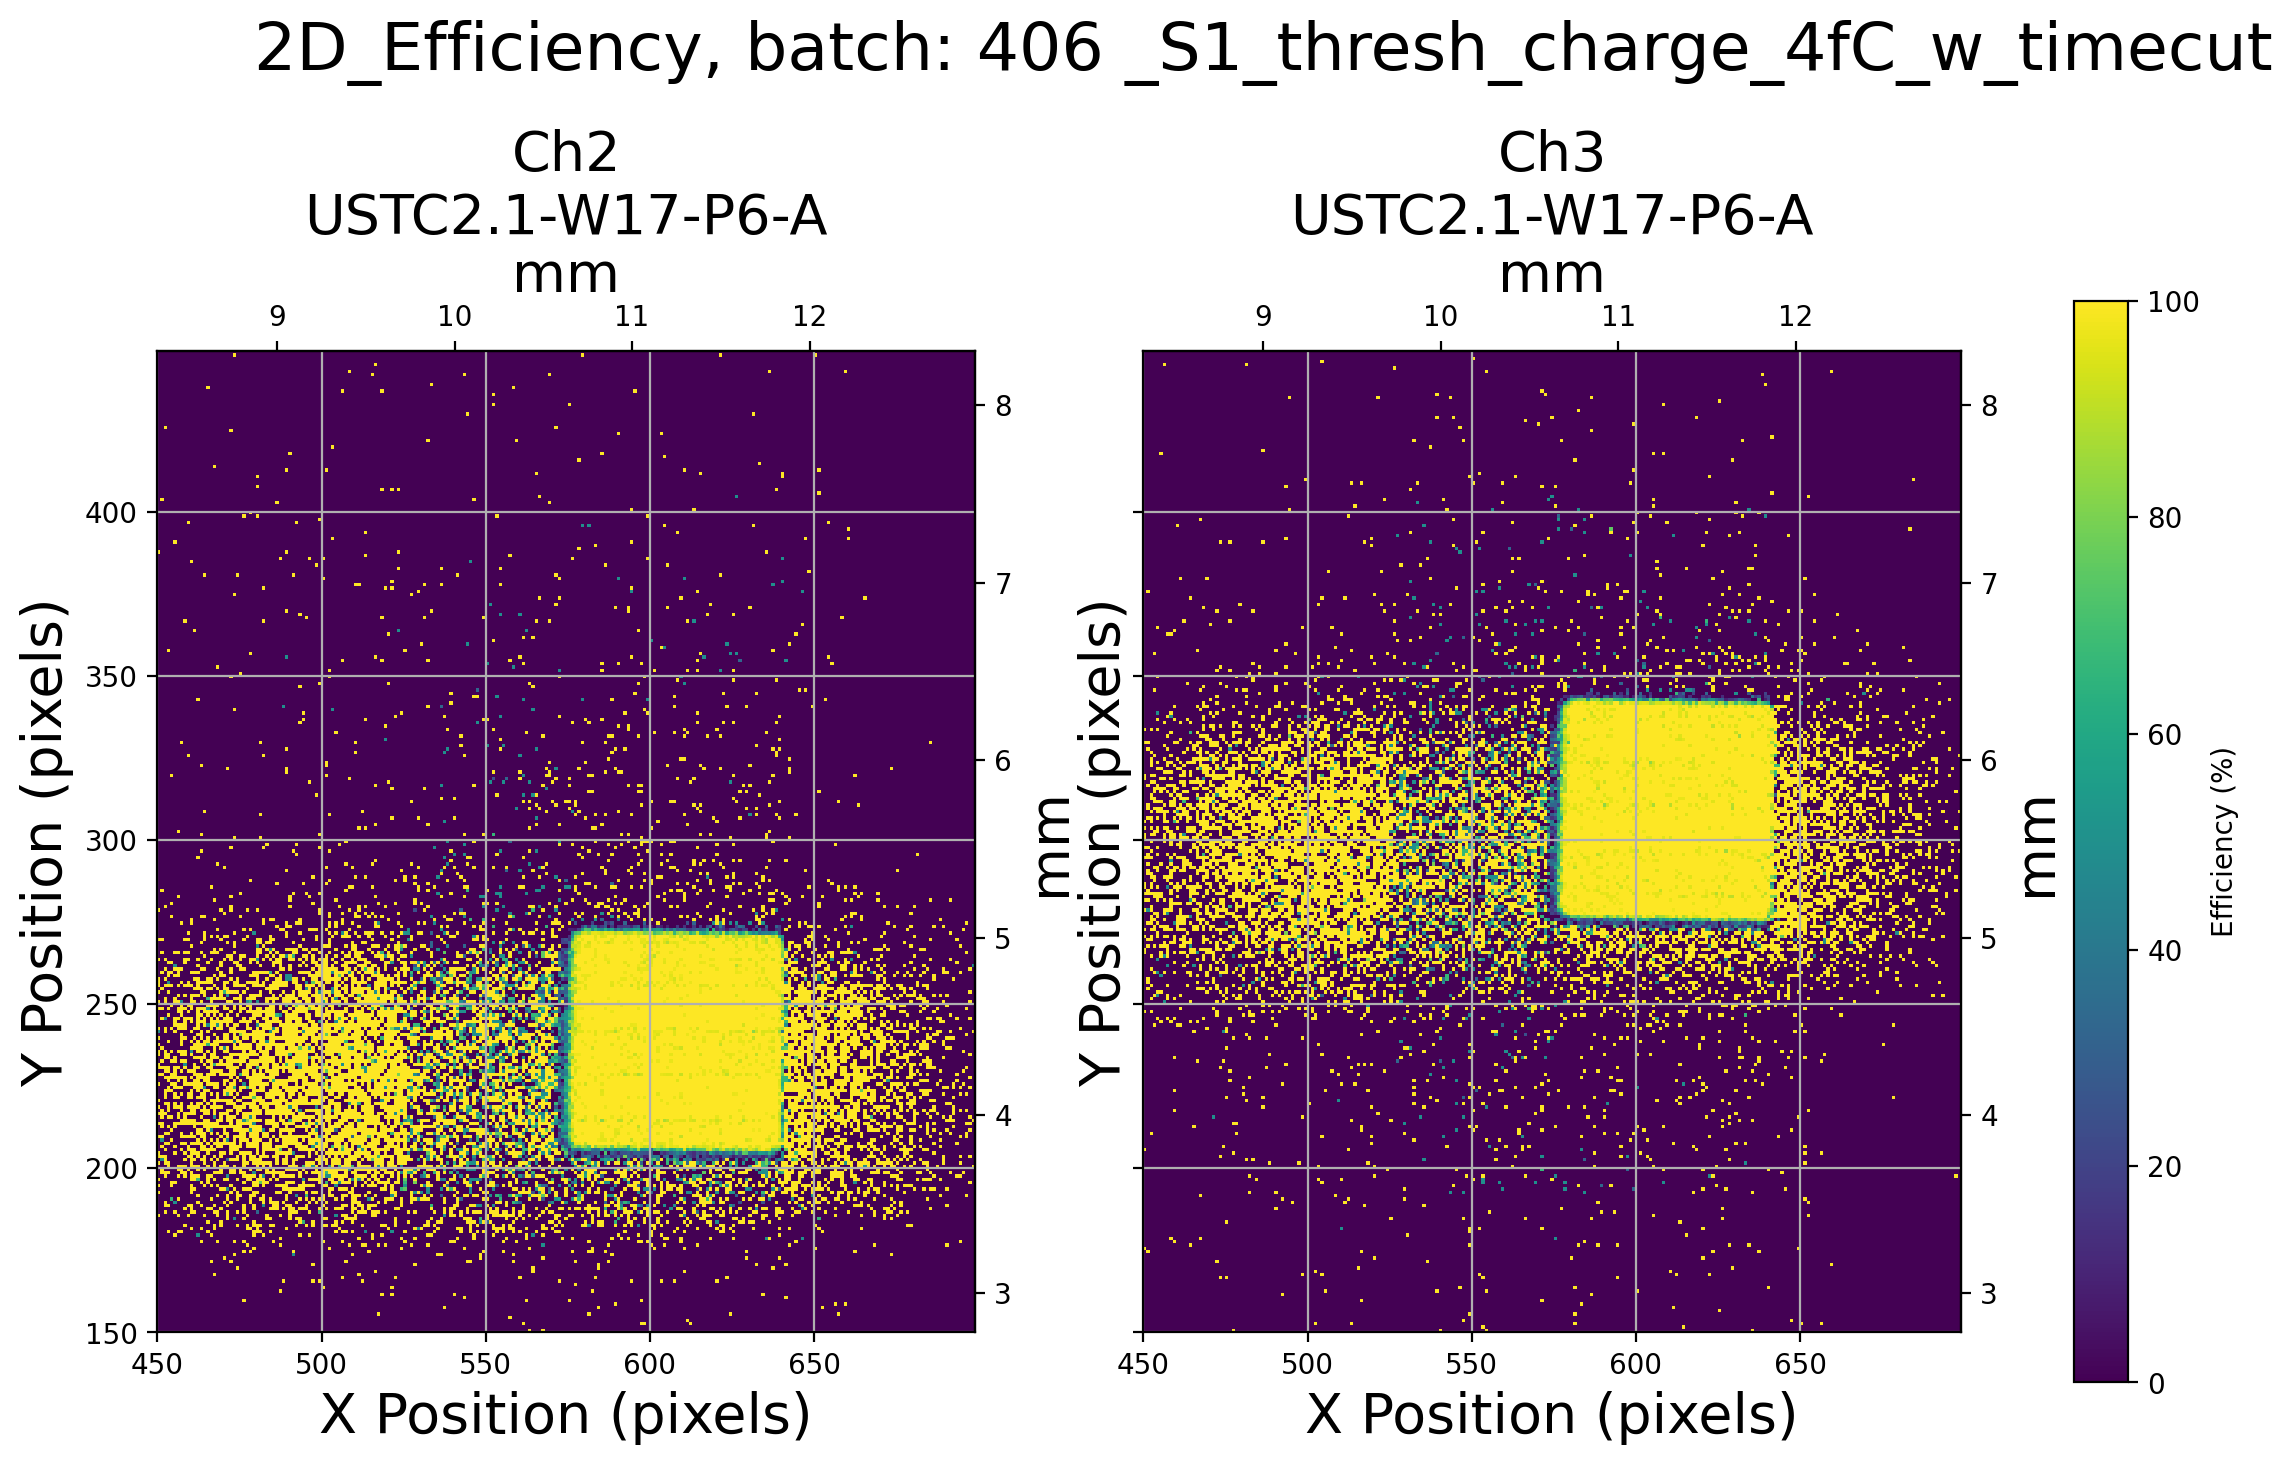

Batch:406, Scope:S1, Channel:Ch2
Batch:406, Scope:S1, Channel:Ch3
DUT_1
DUT_2


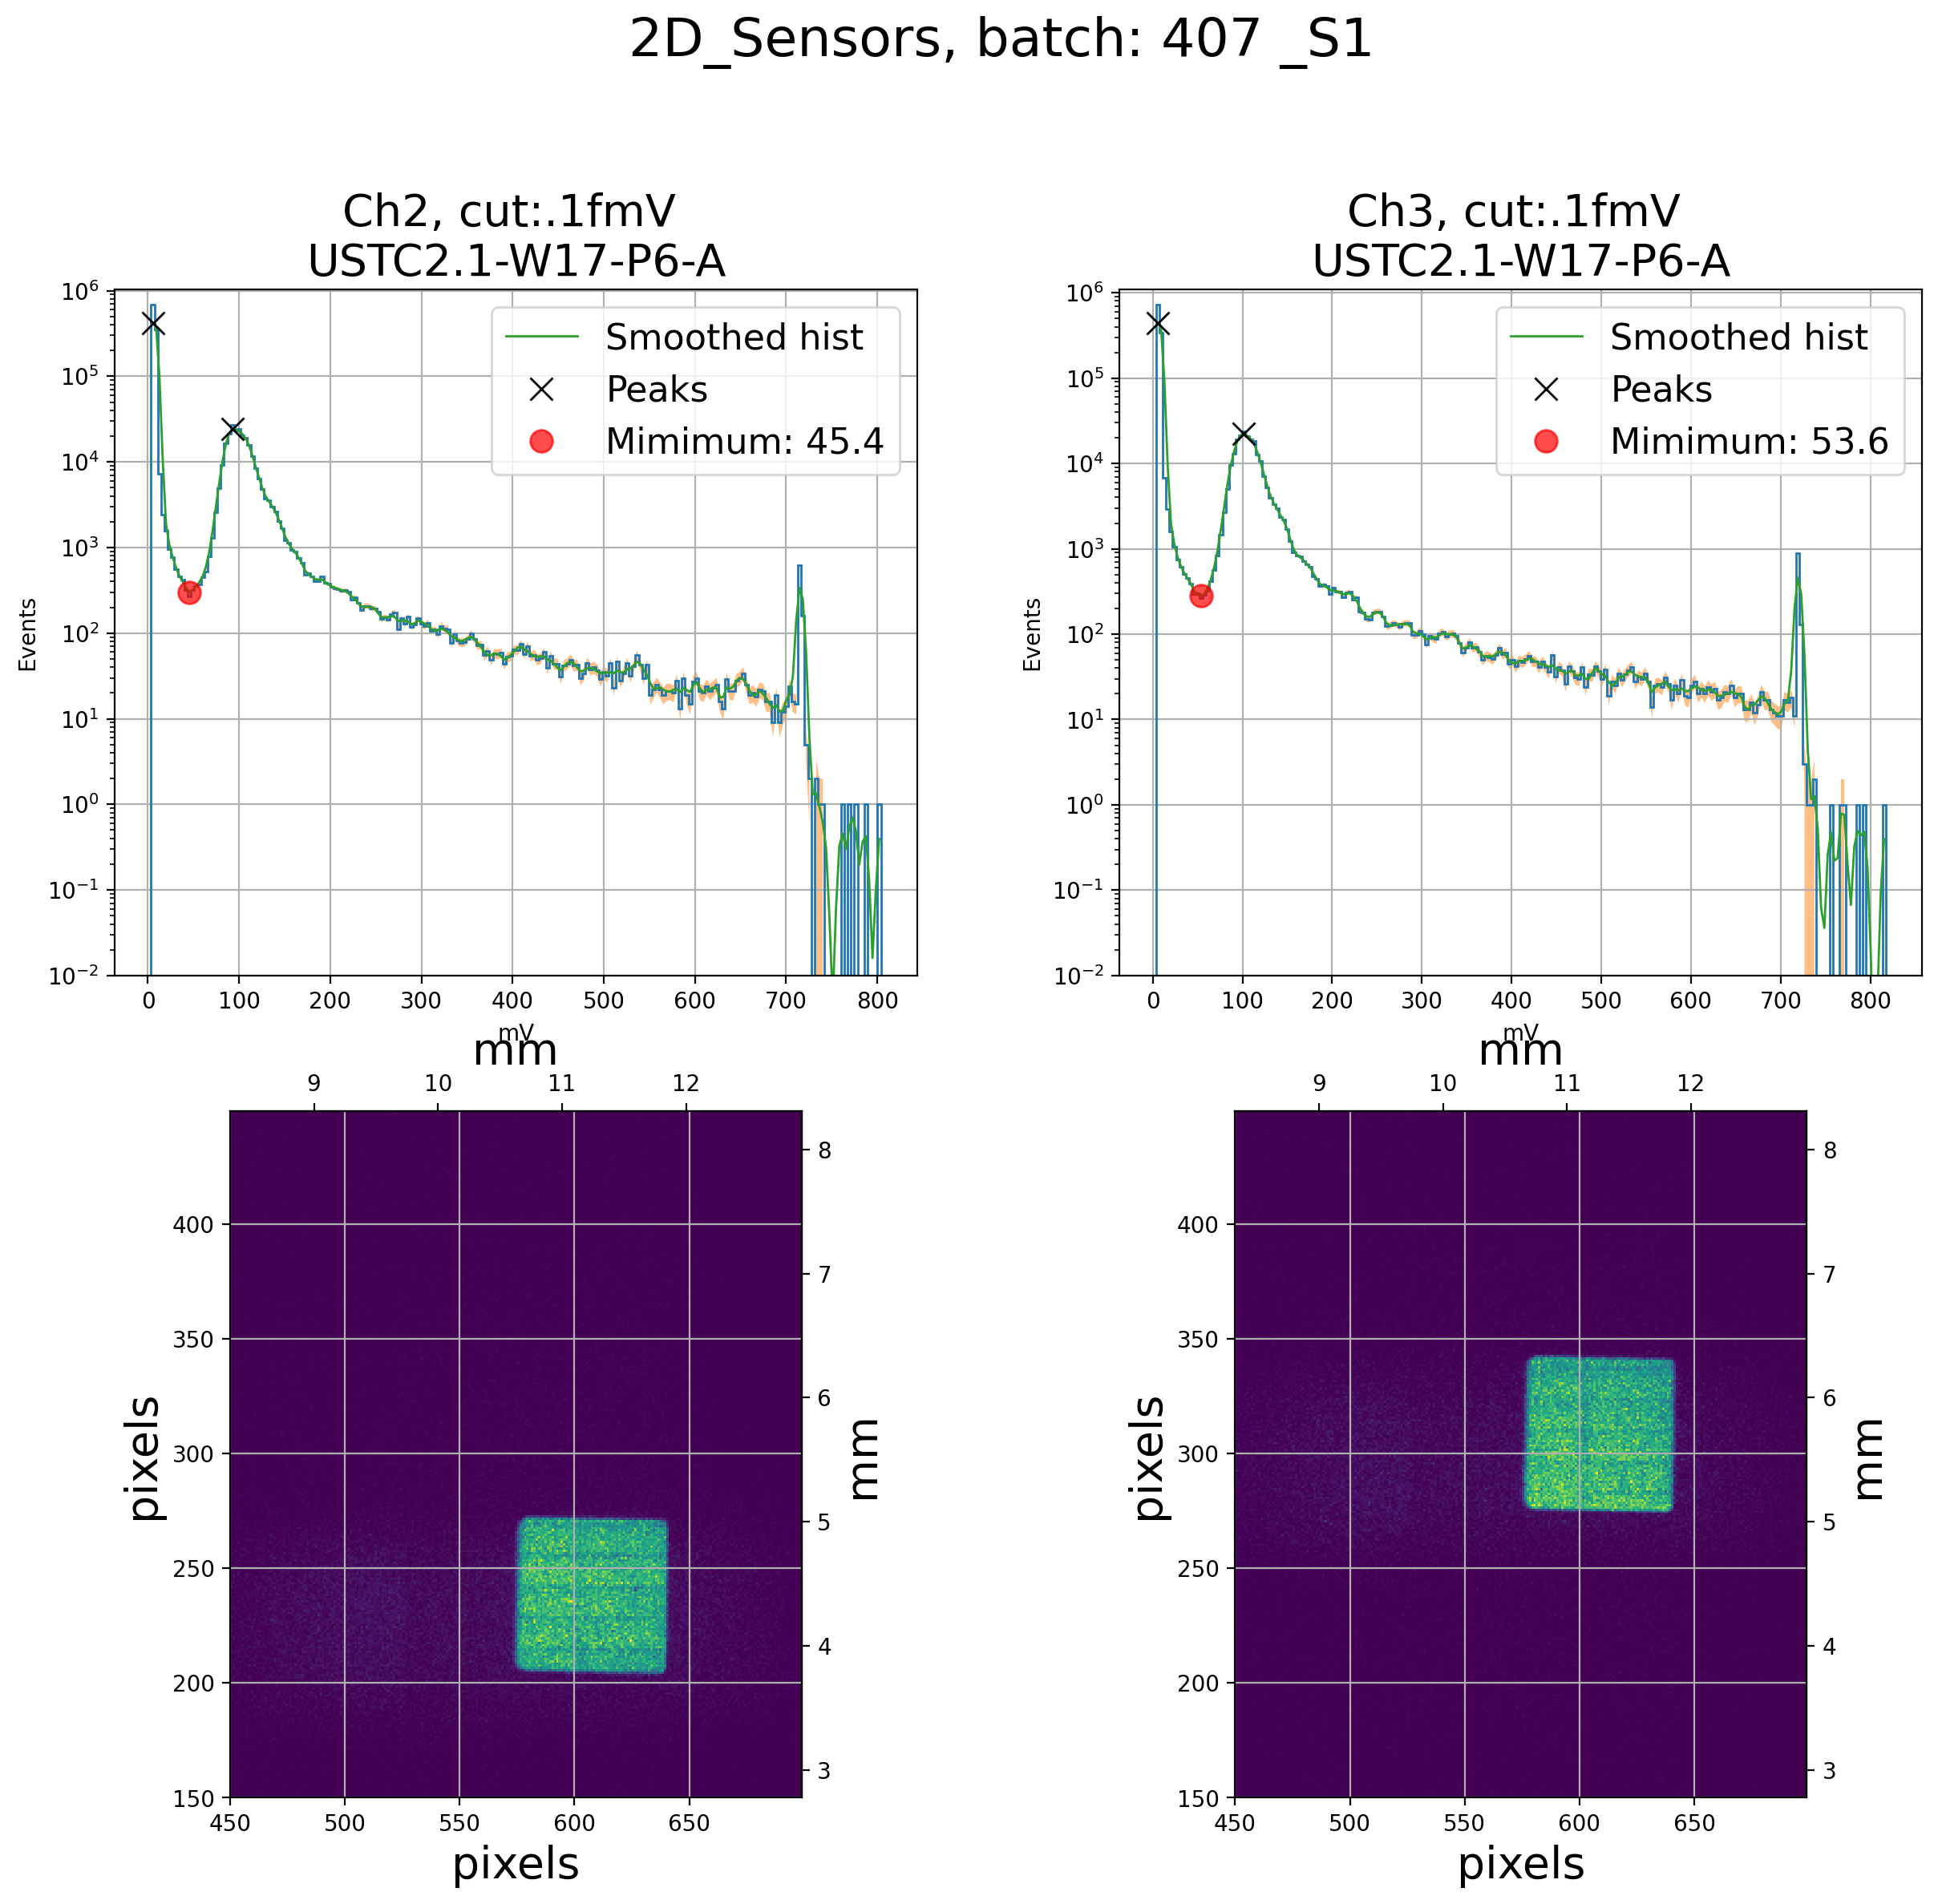

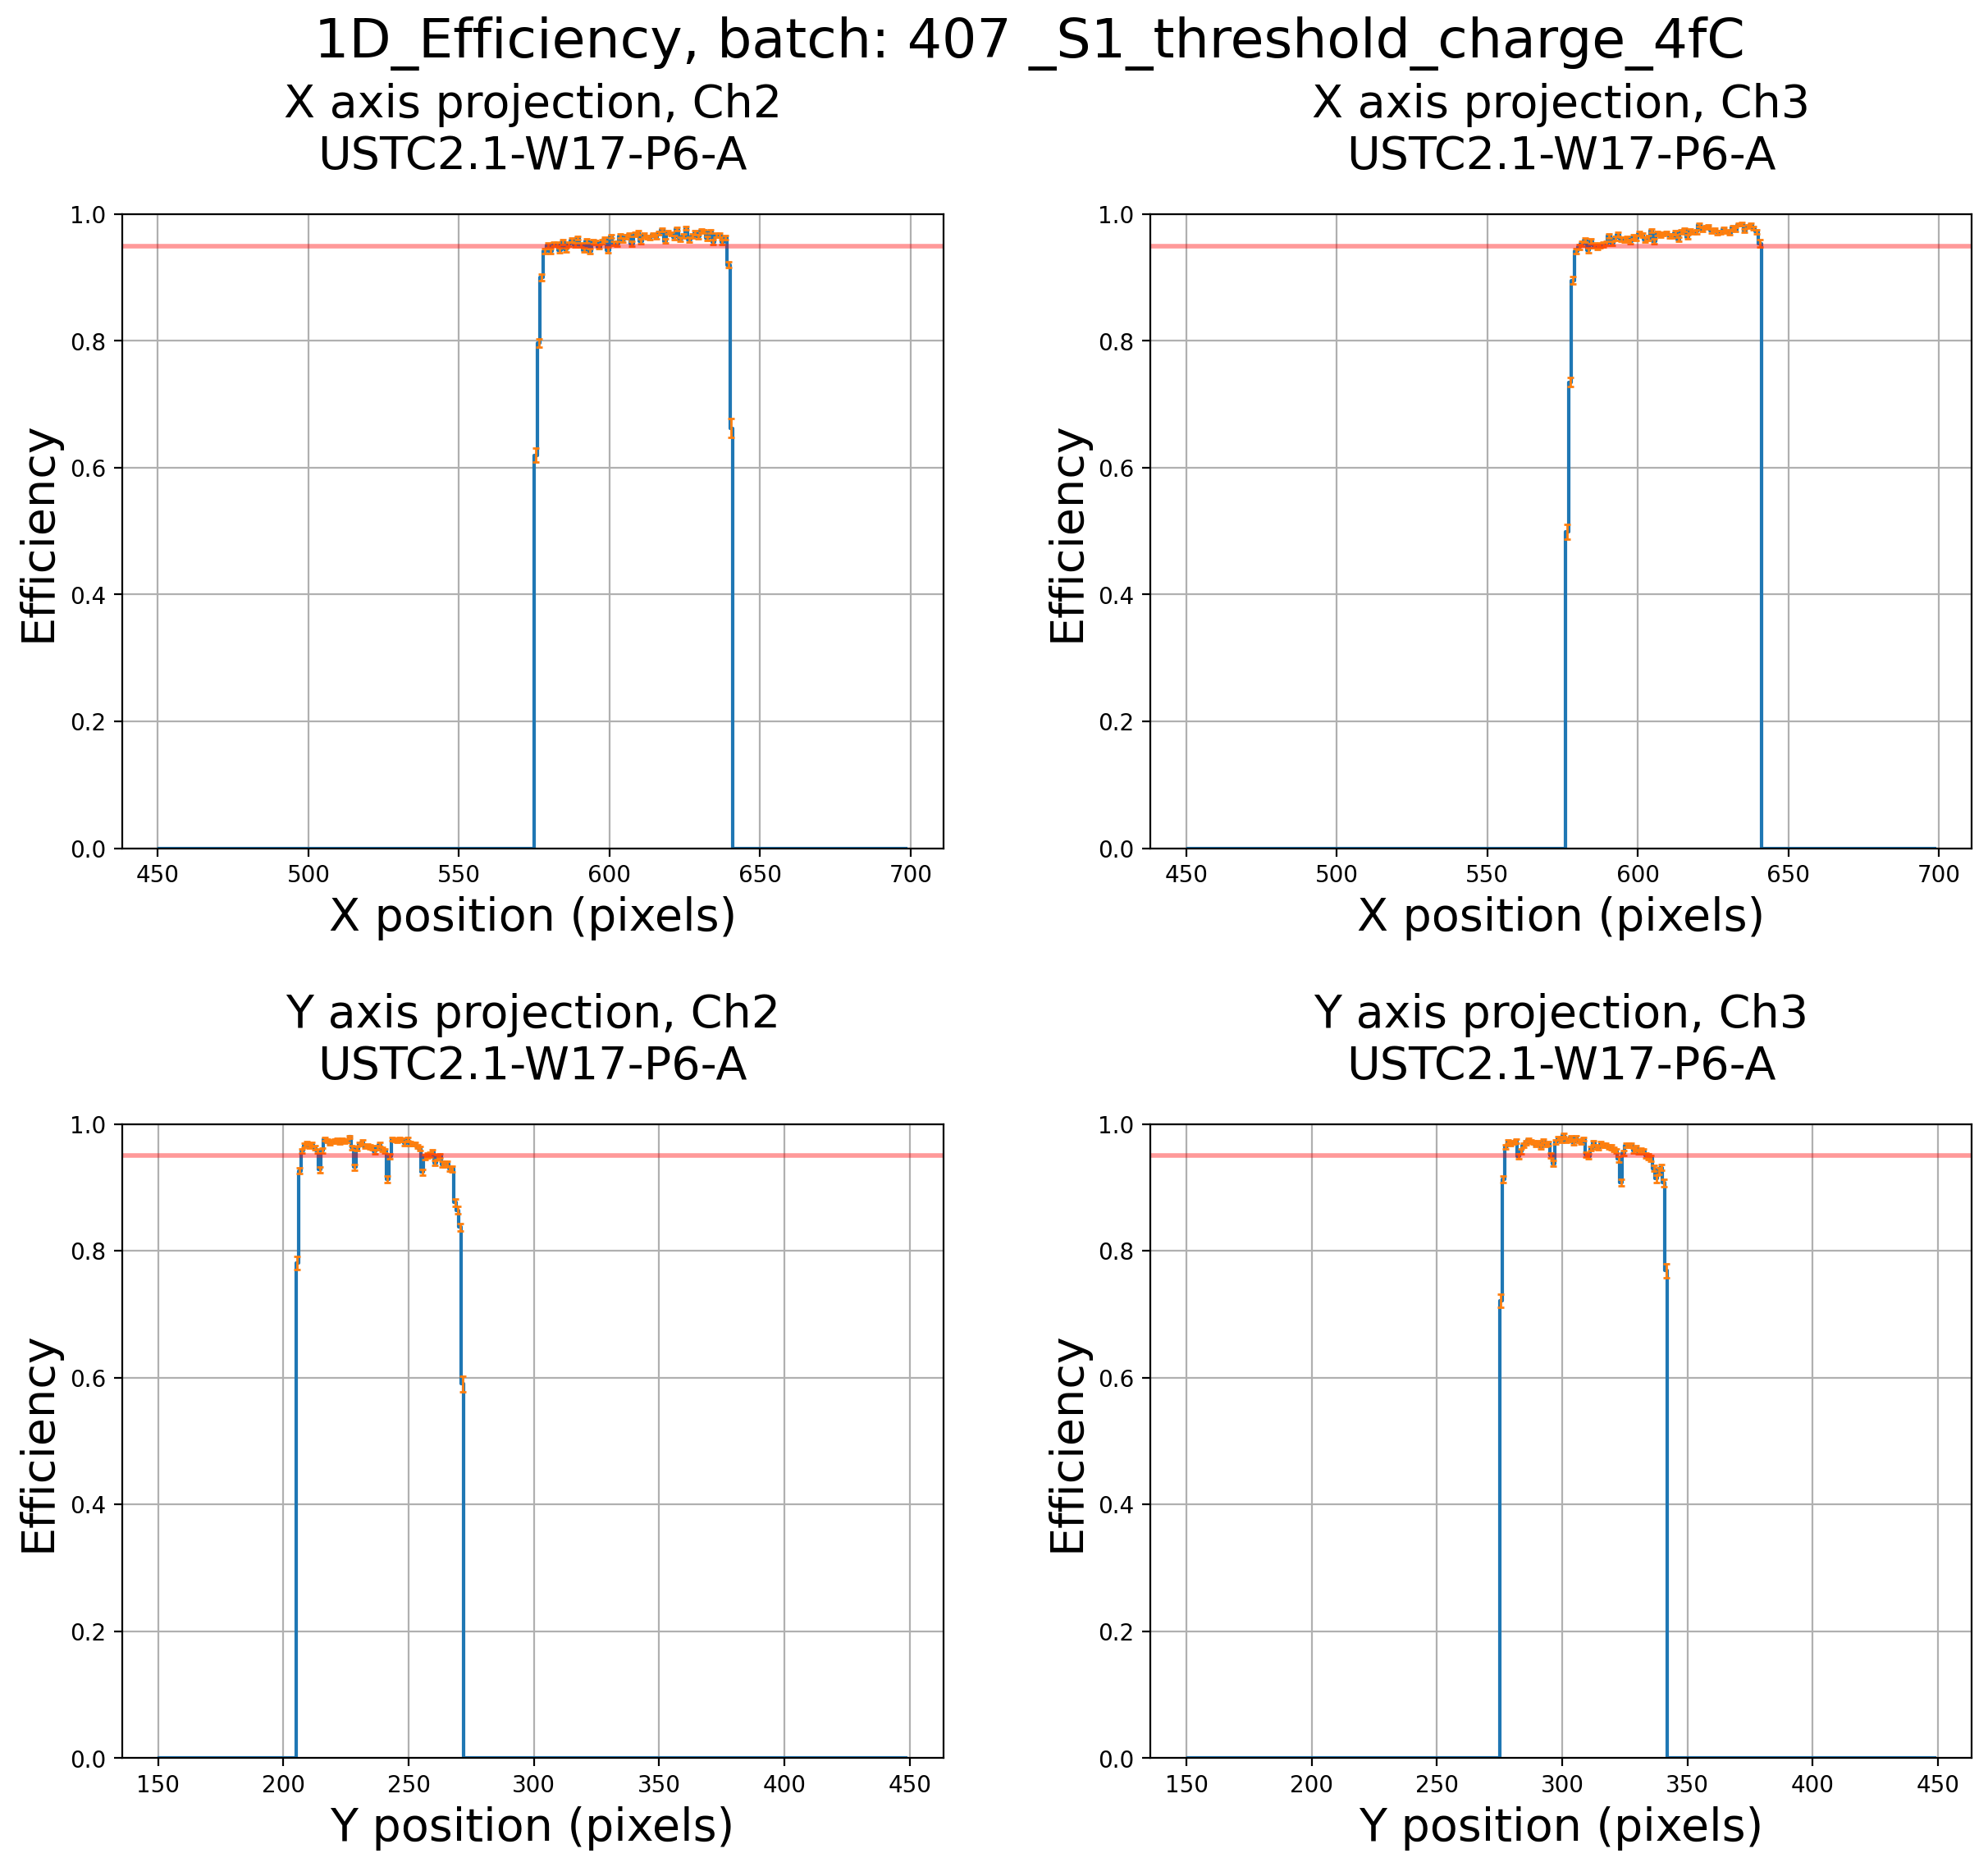

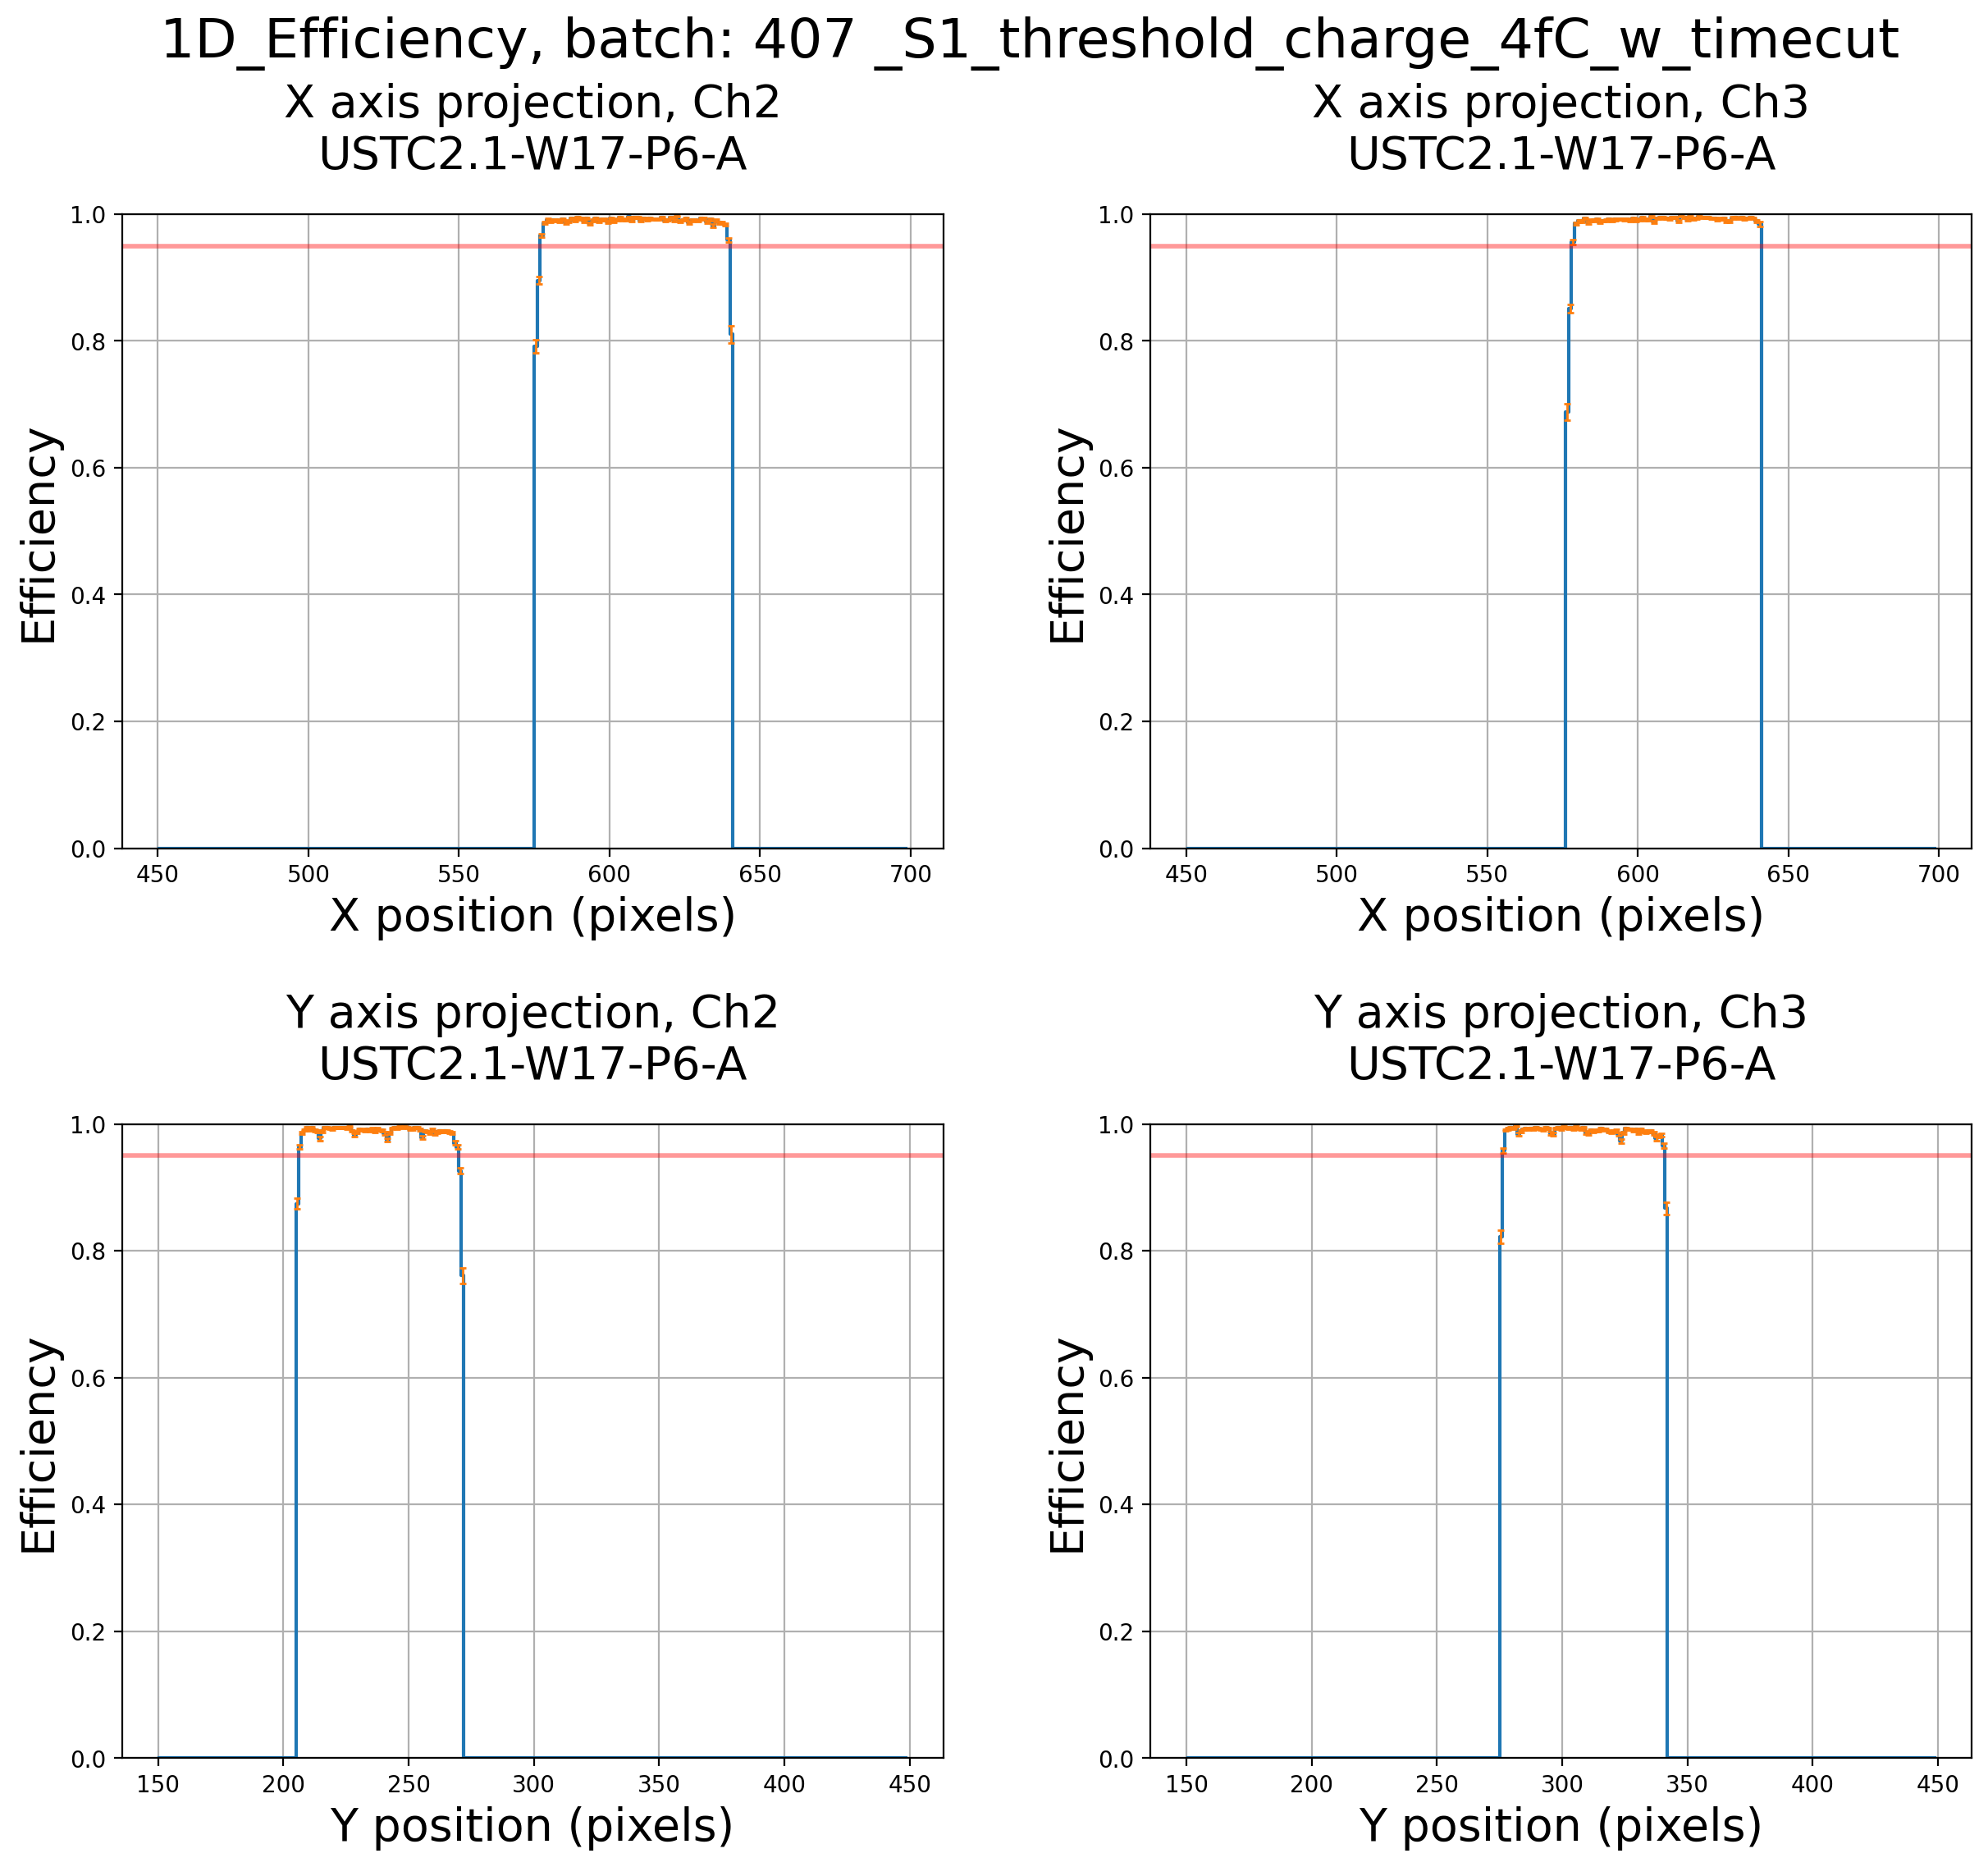

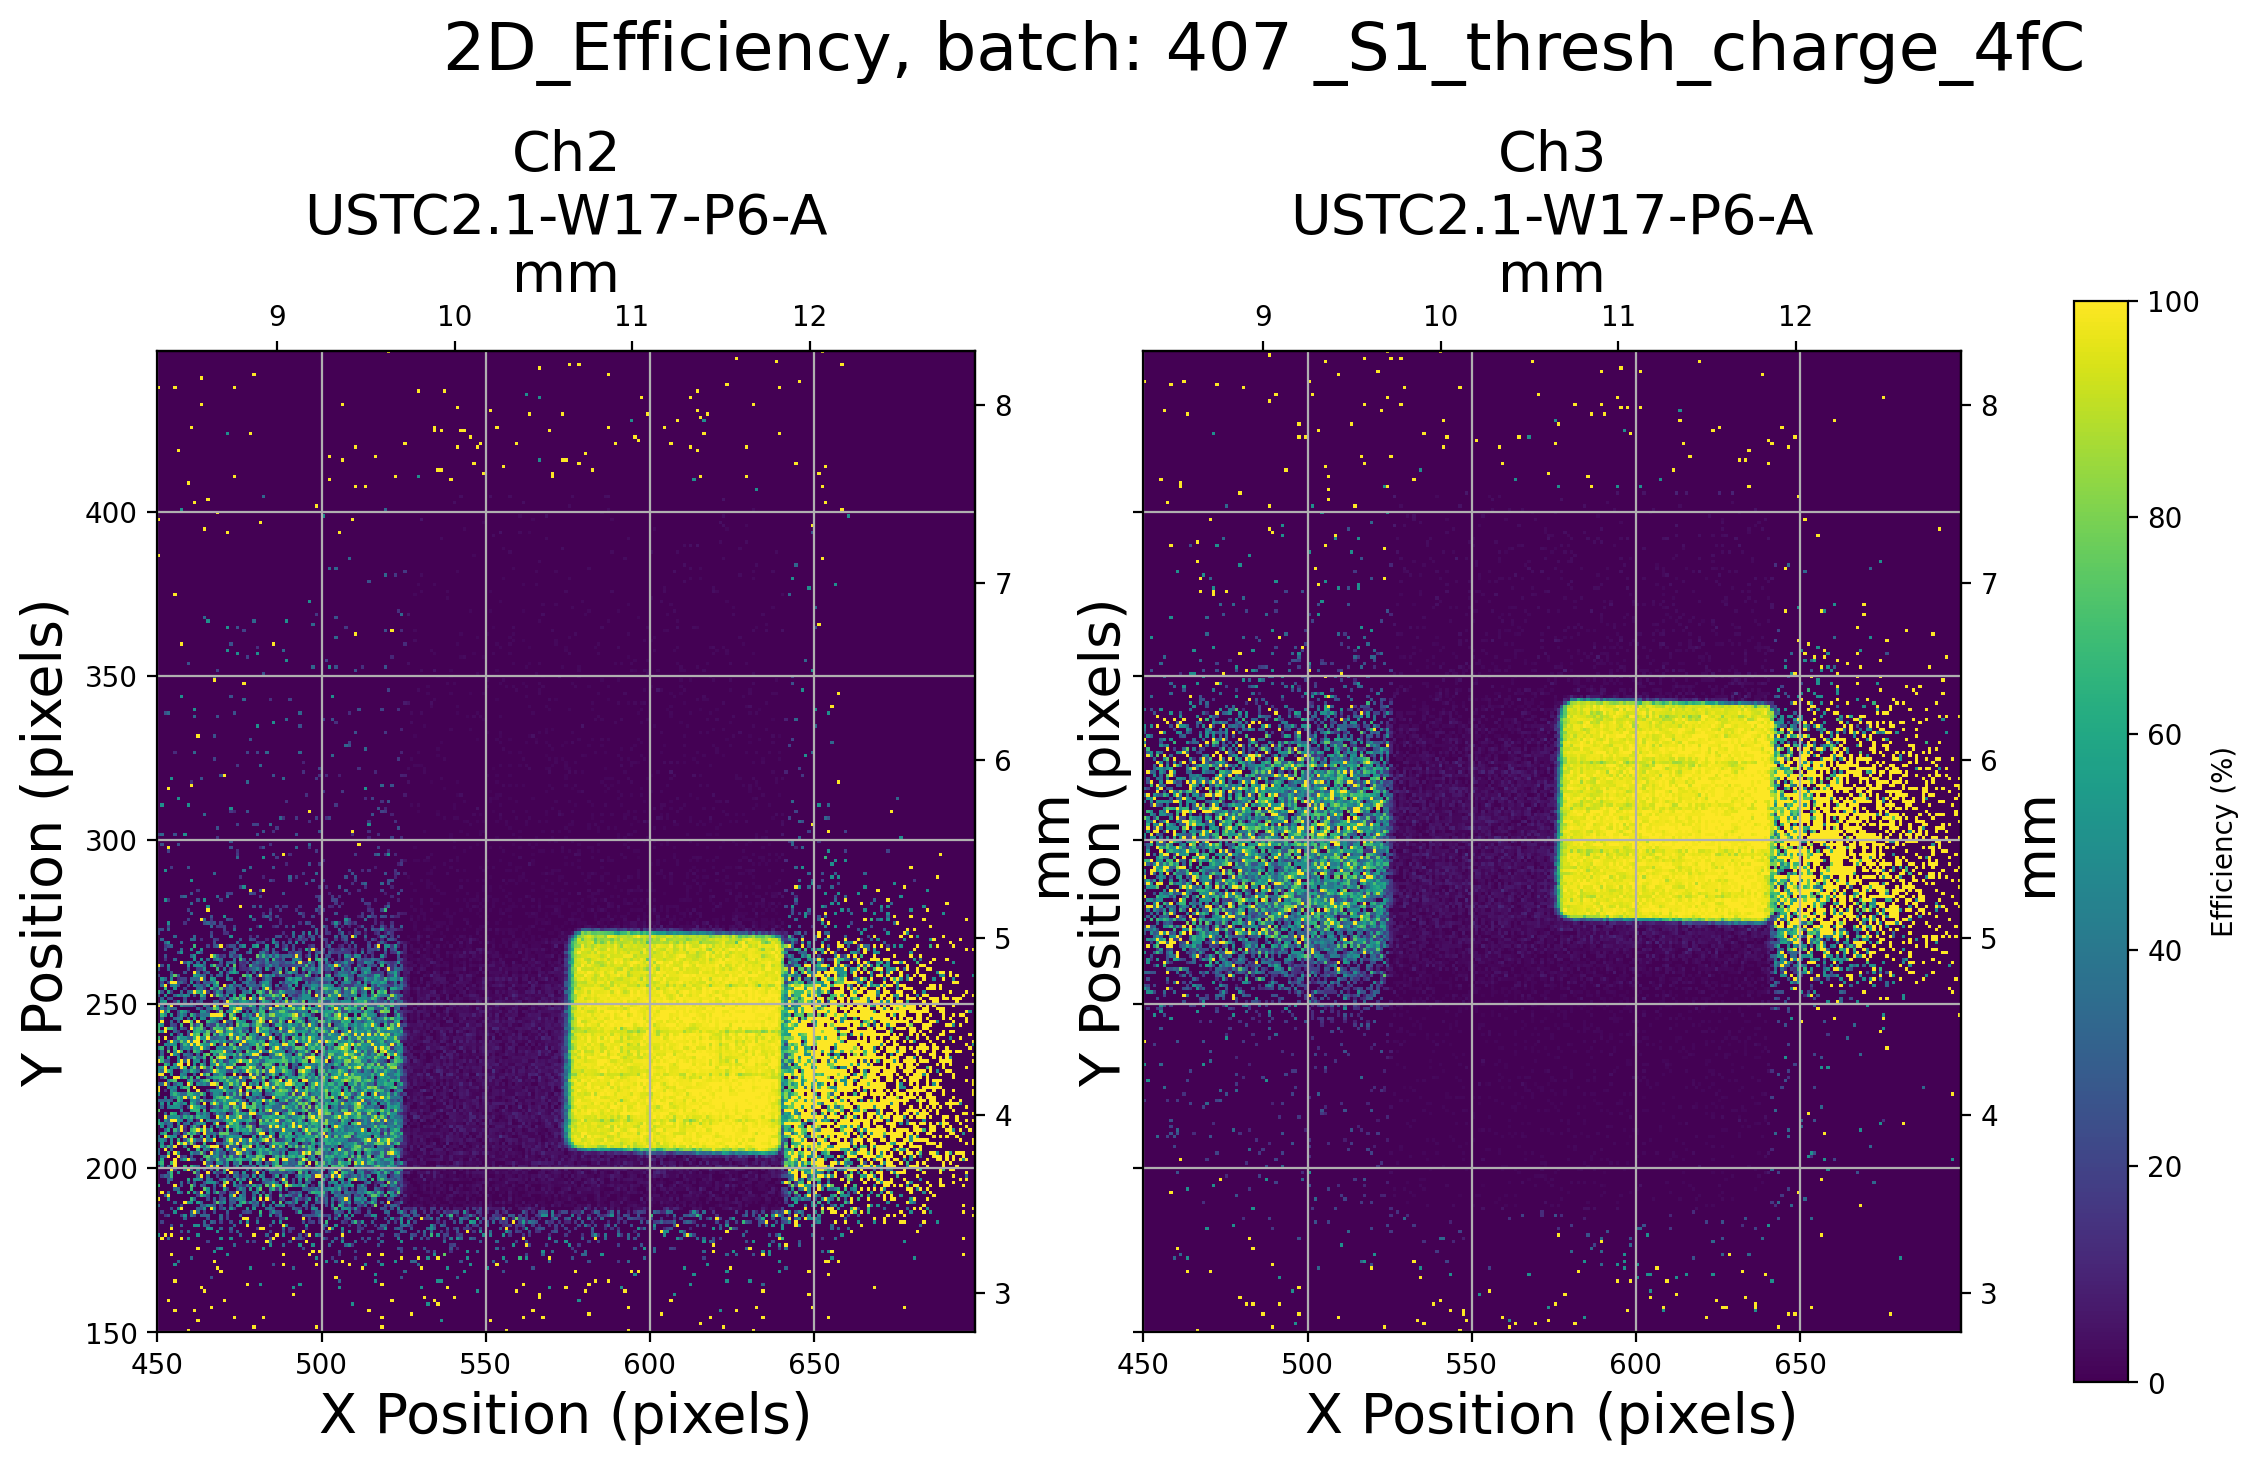

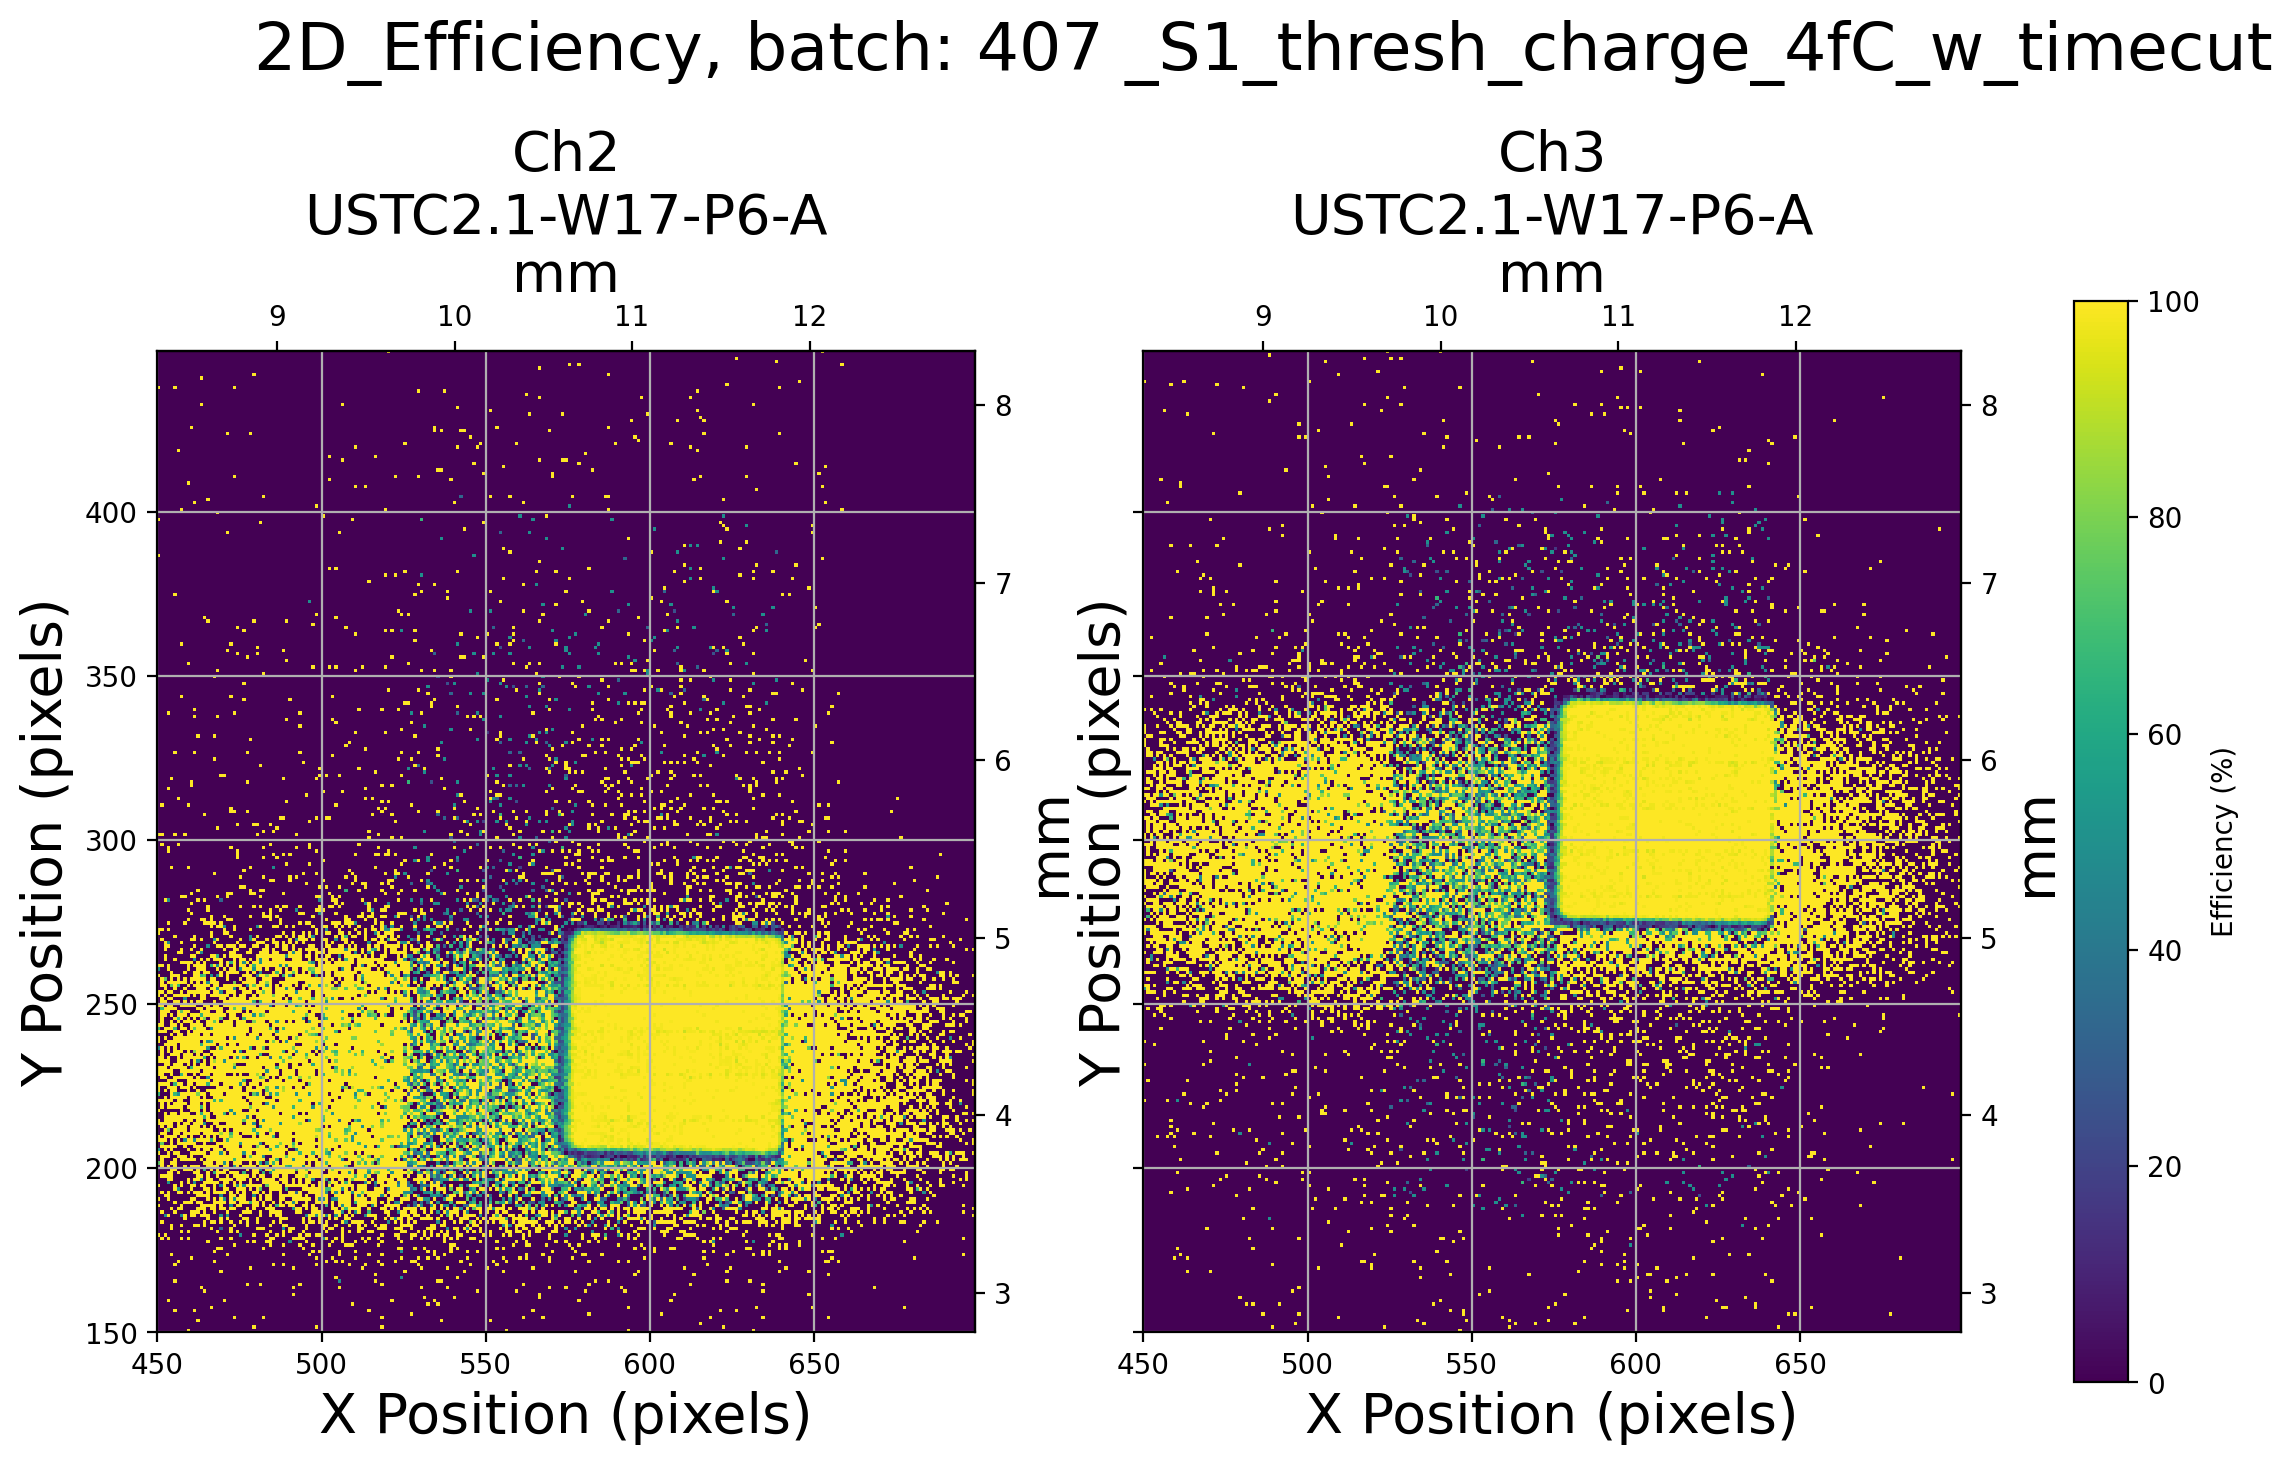

Batch:407, Scope:S1, Channel:Ch2
Batch:407, Scope:S1, Channel:Ch3
DUT_1
DUT_2


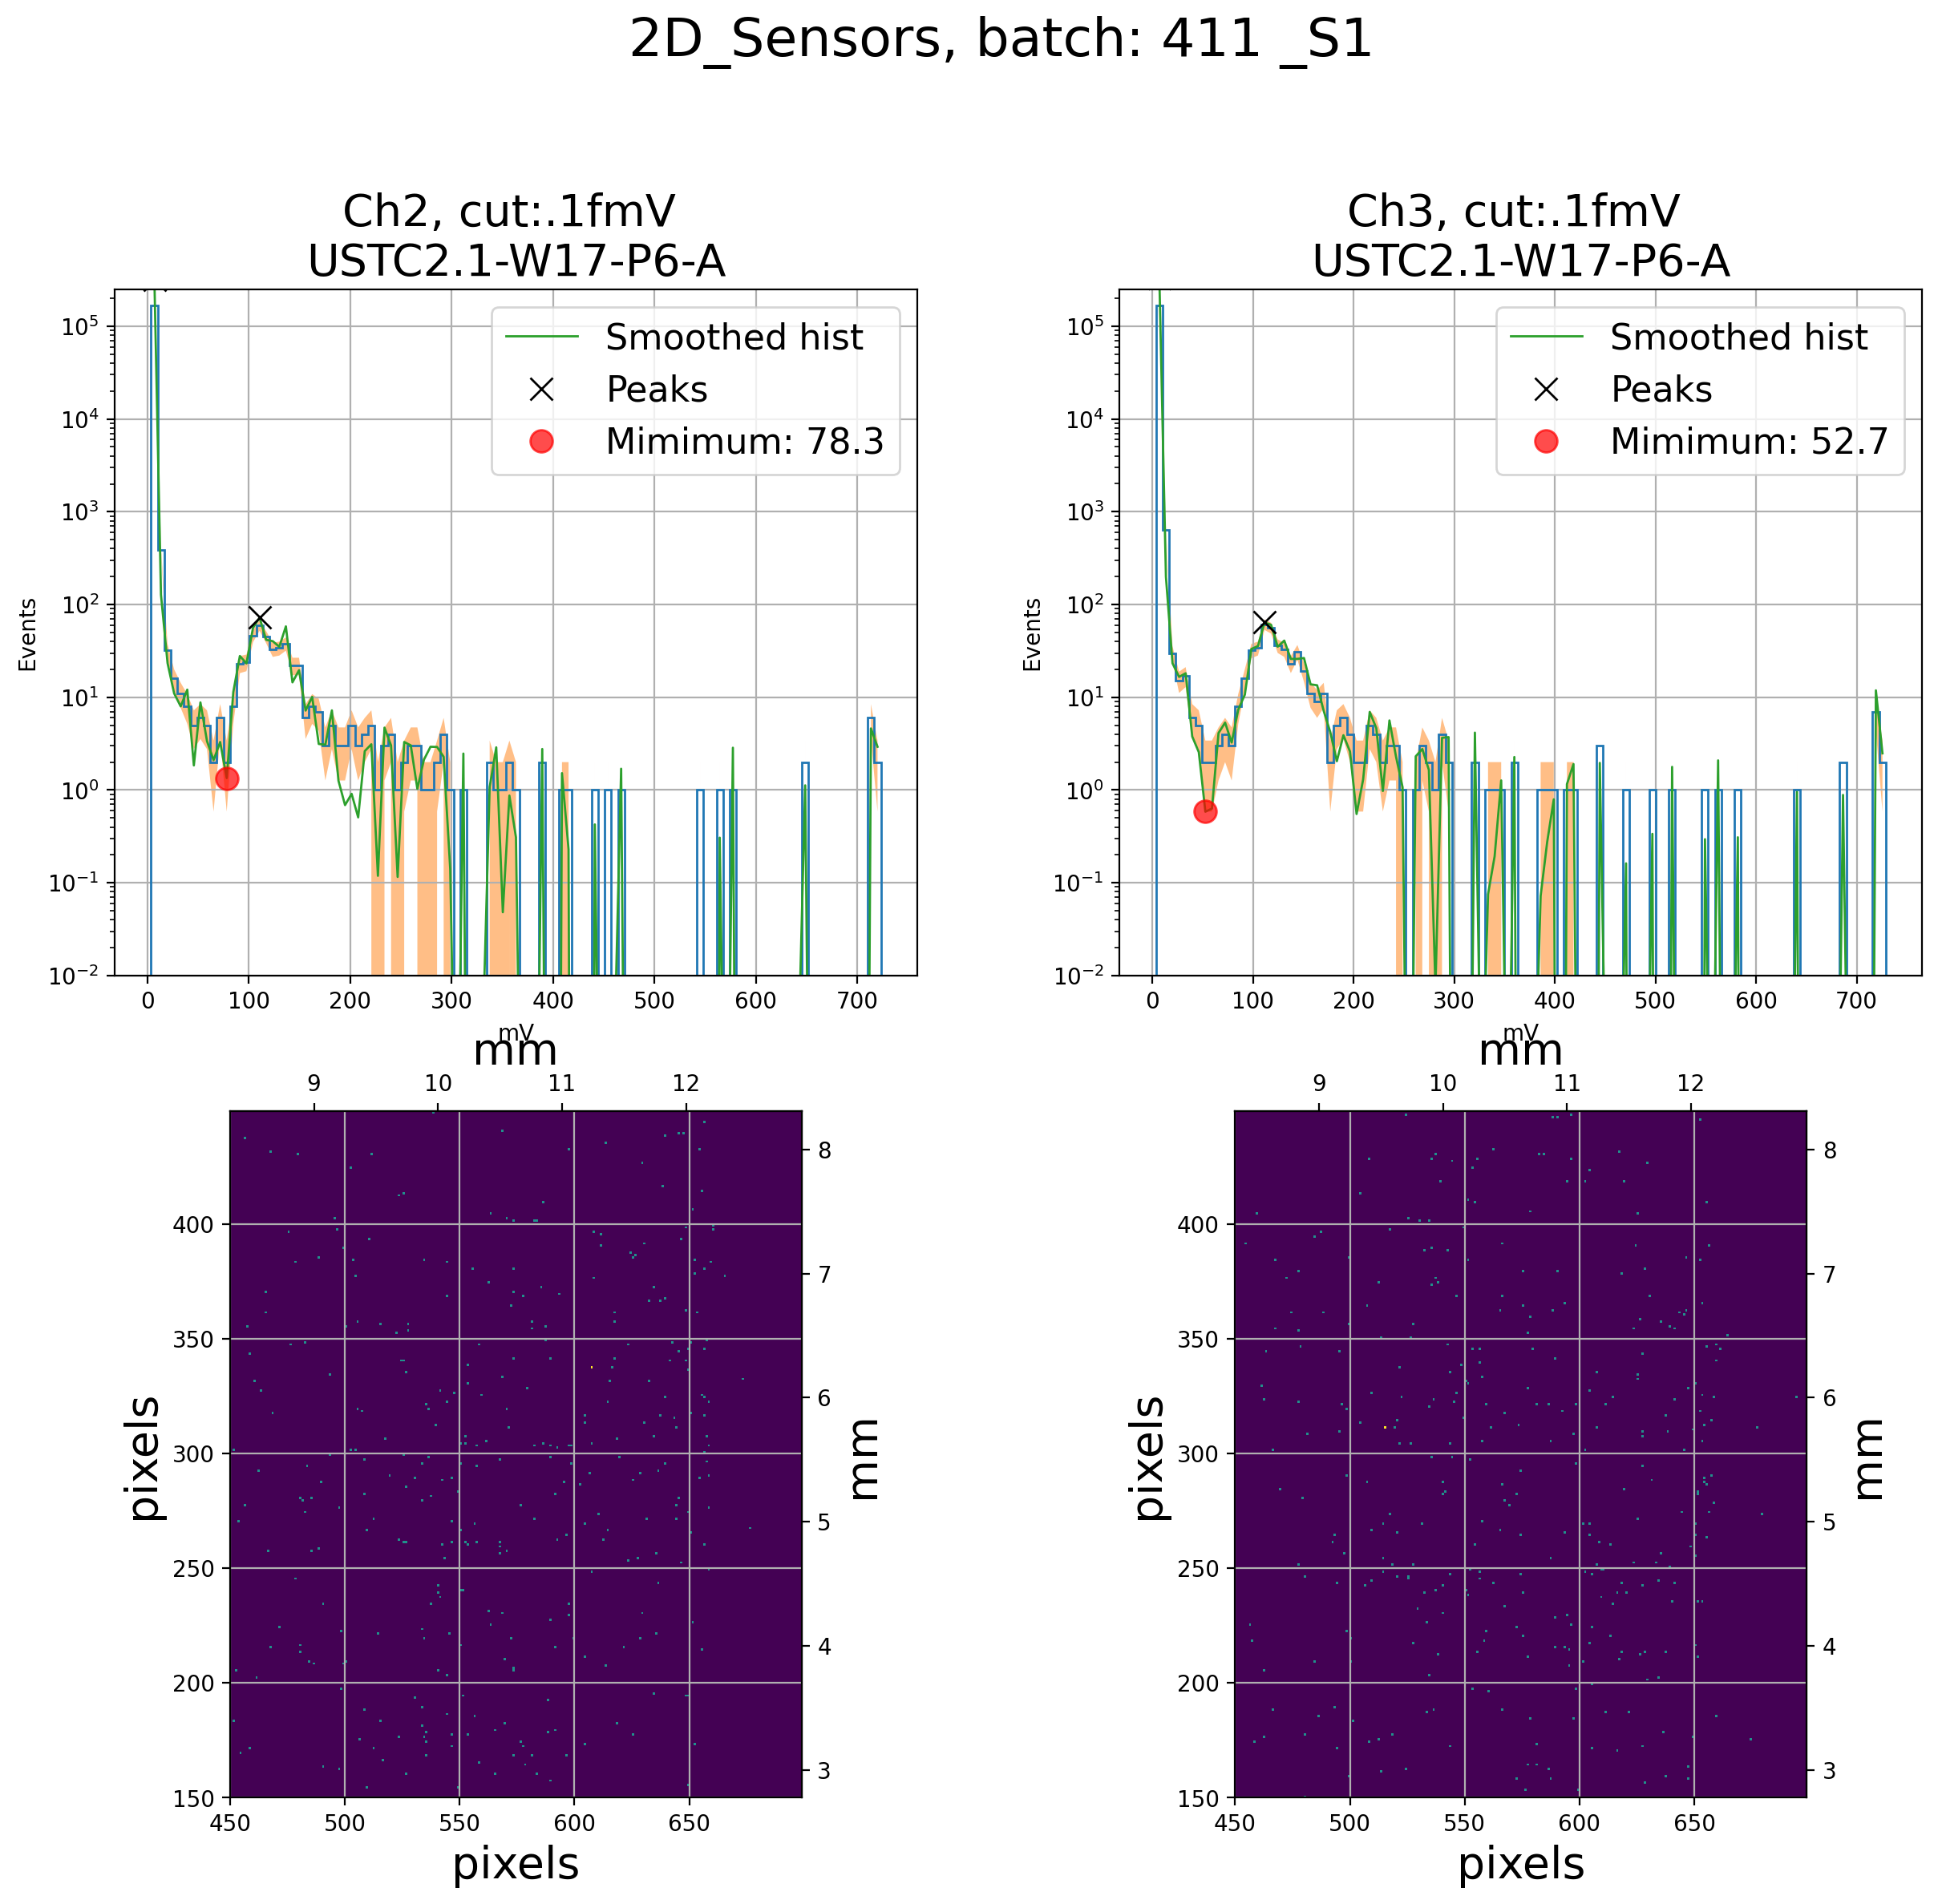

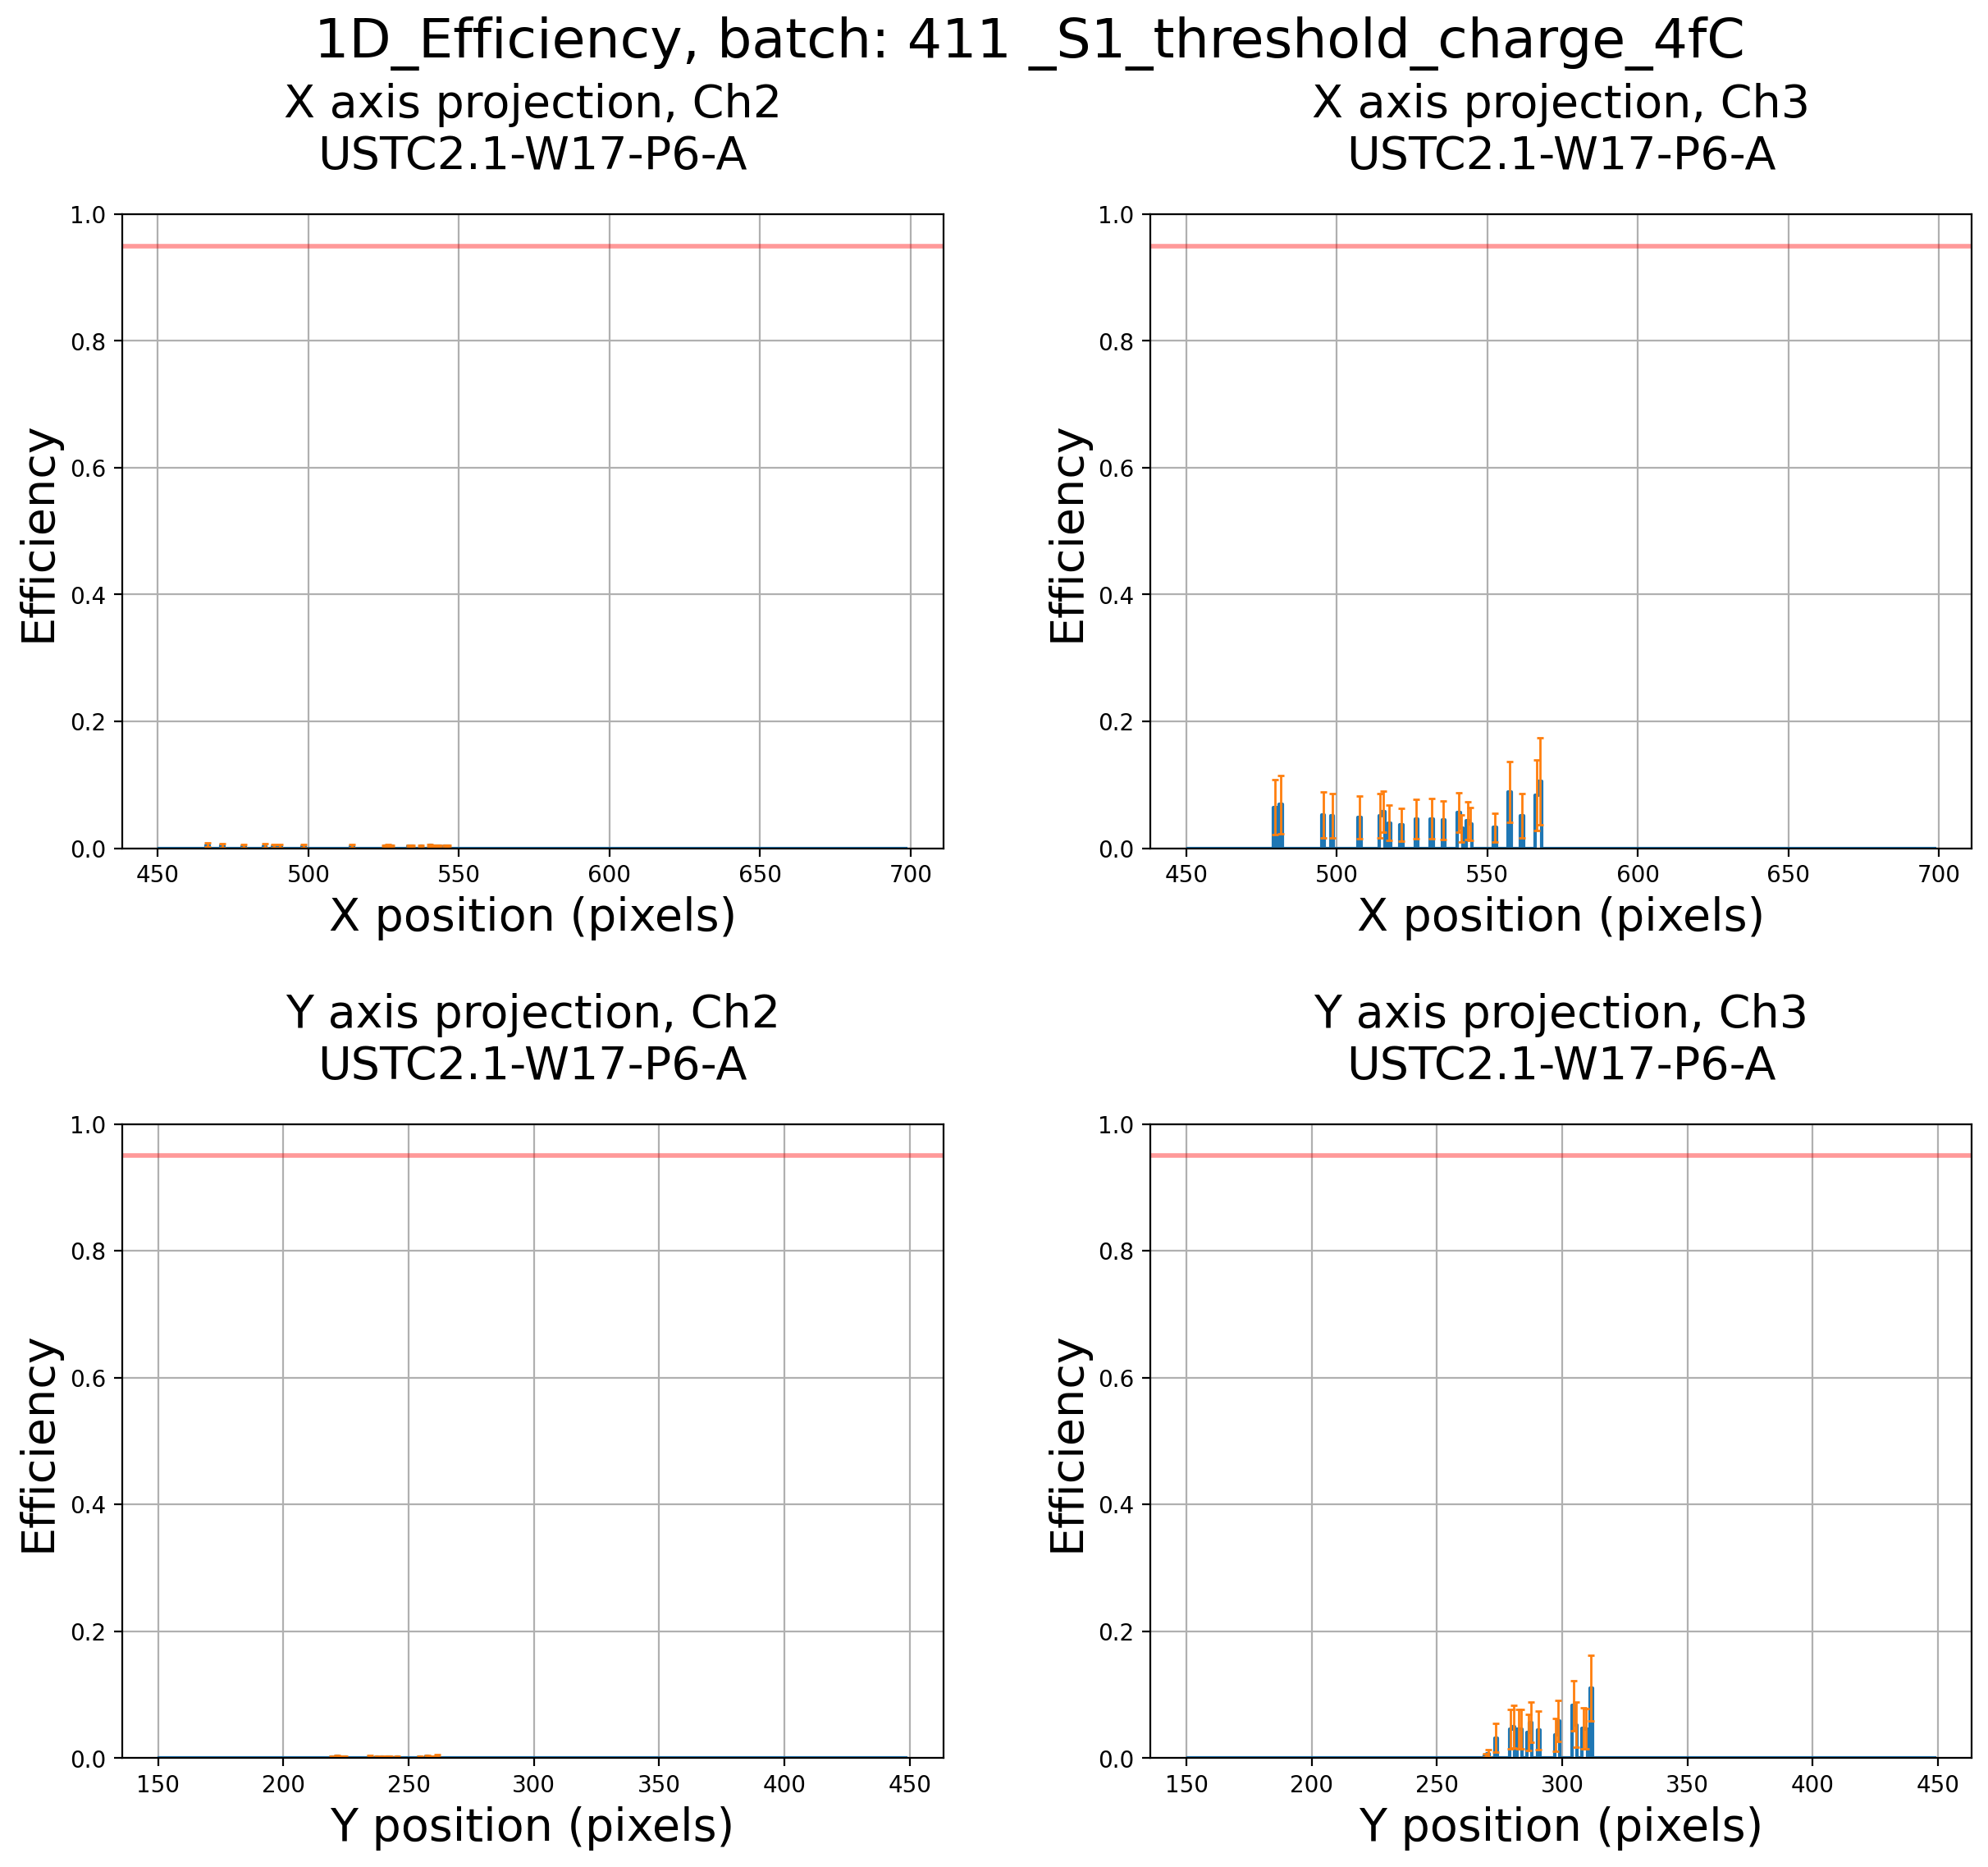

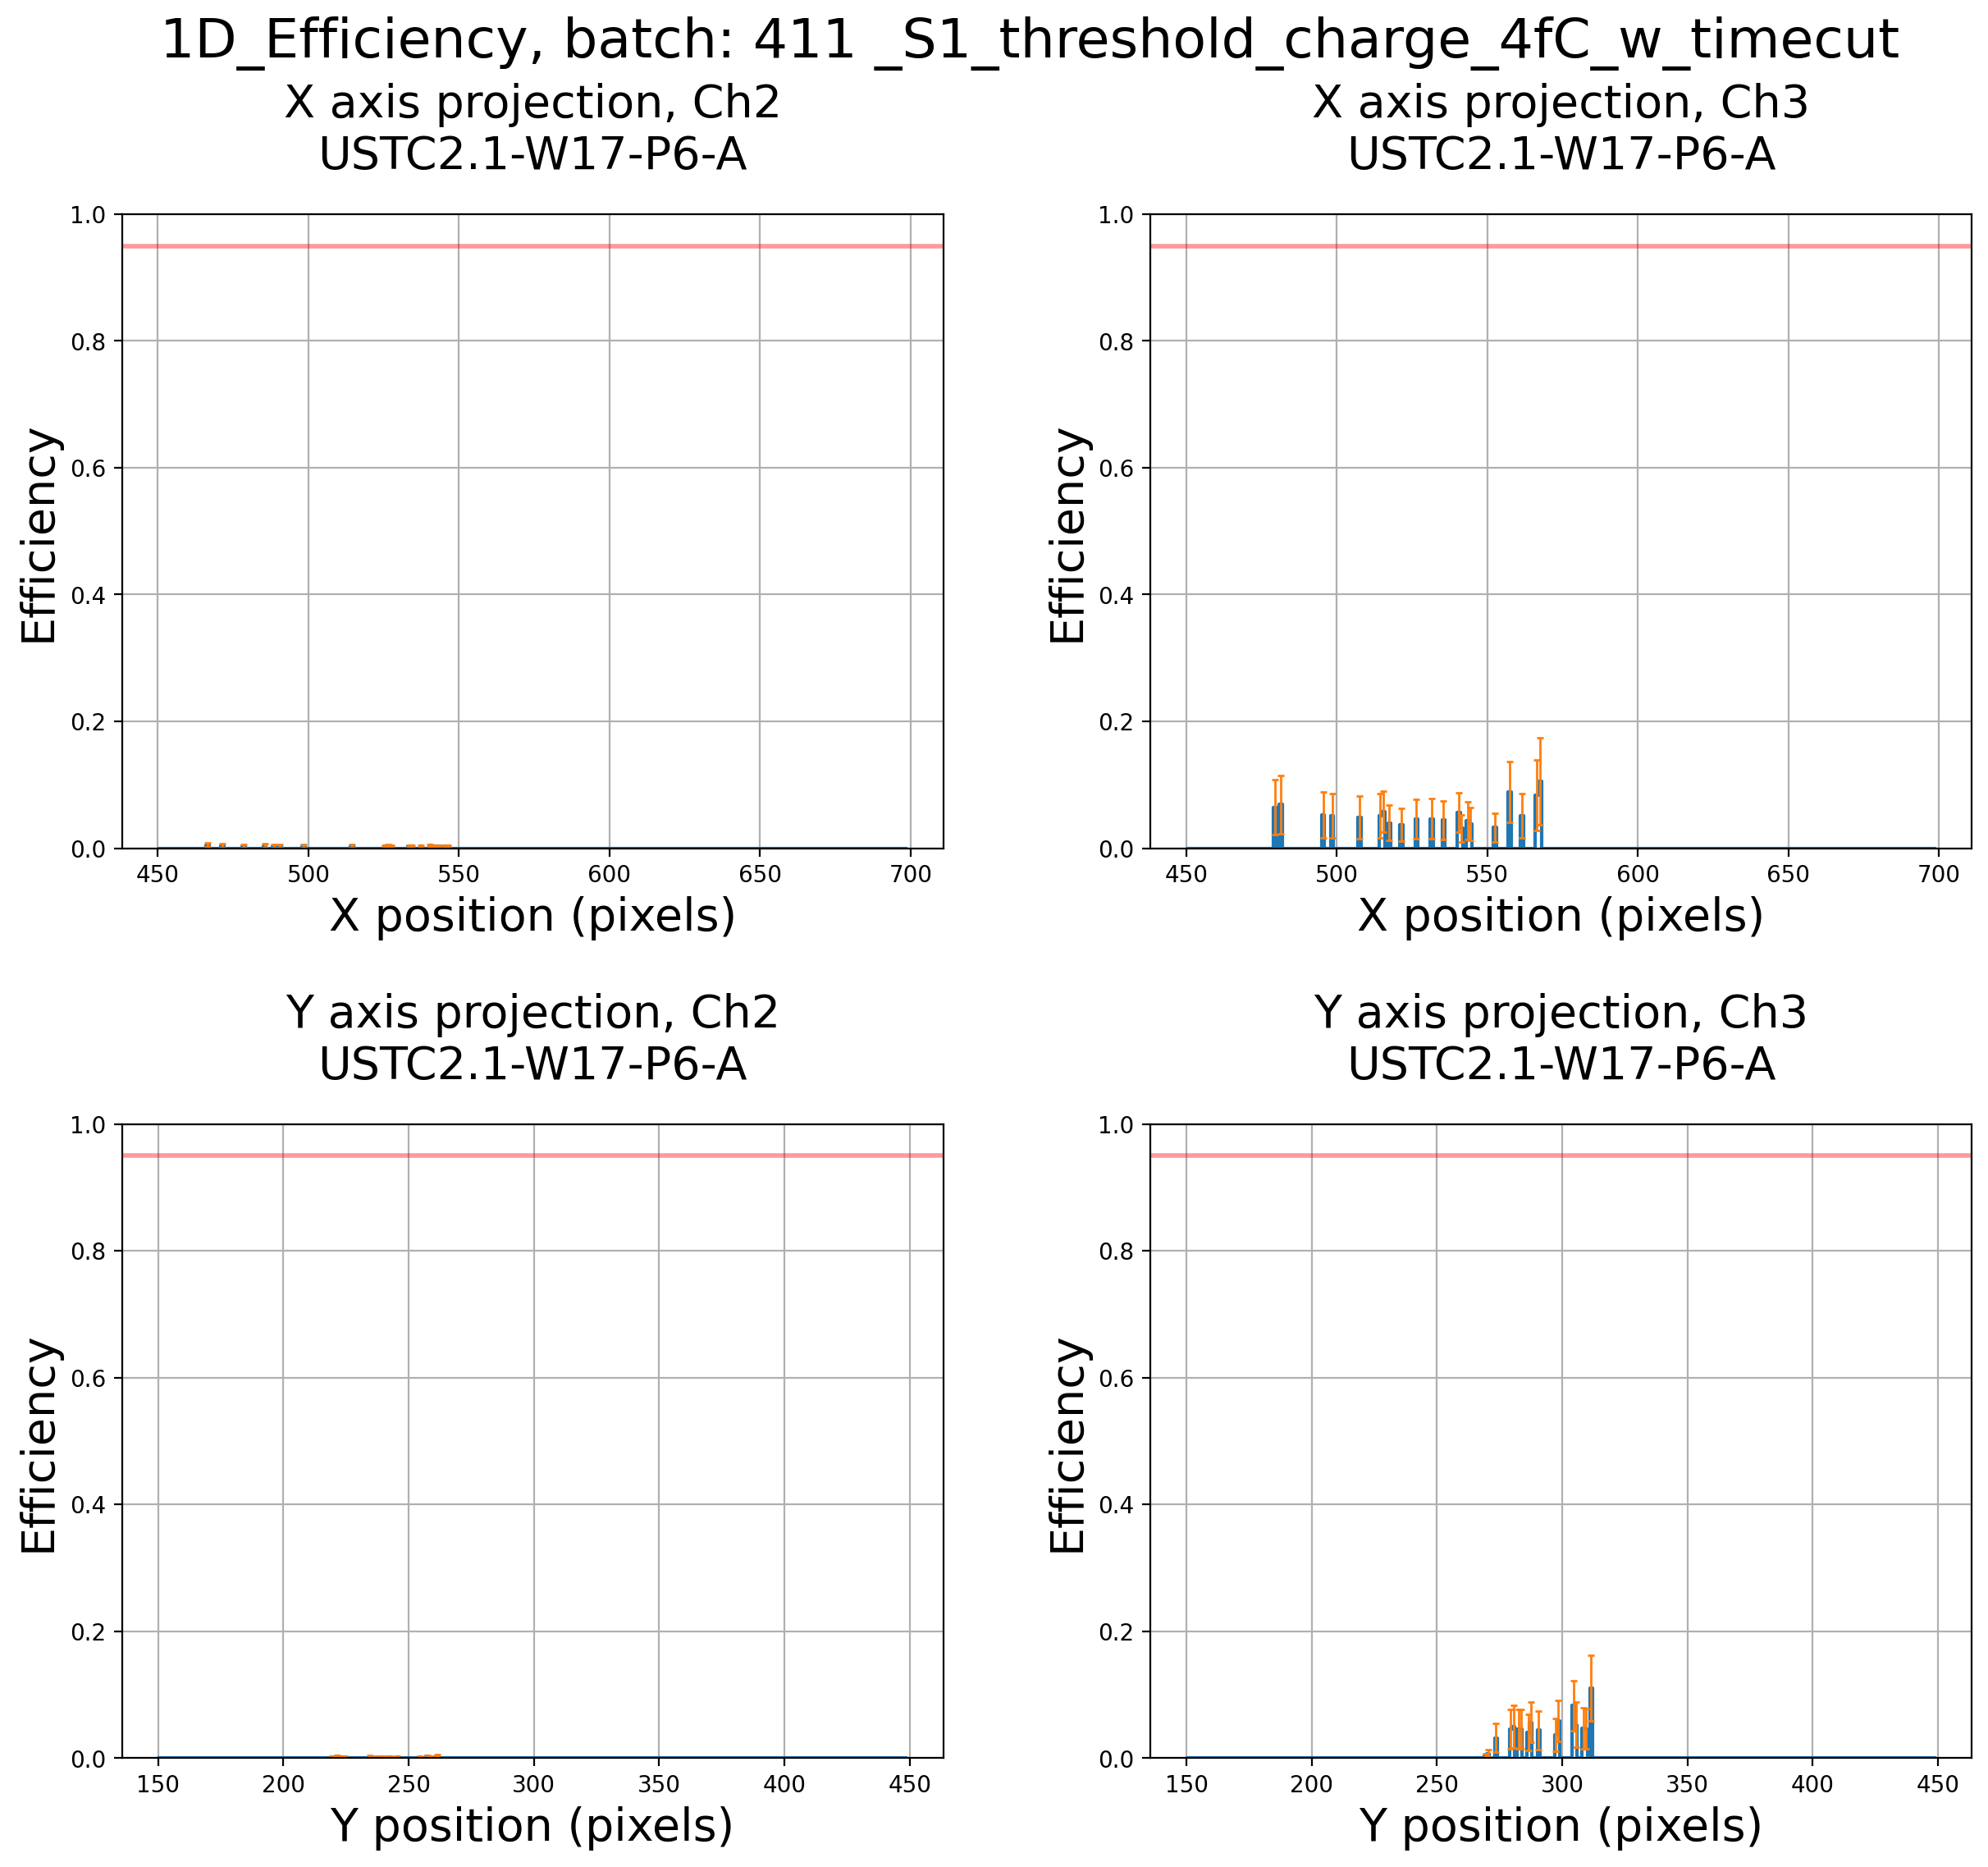

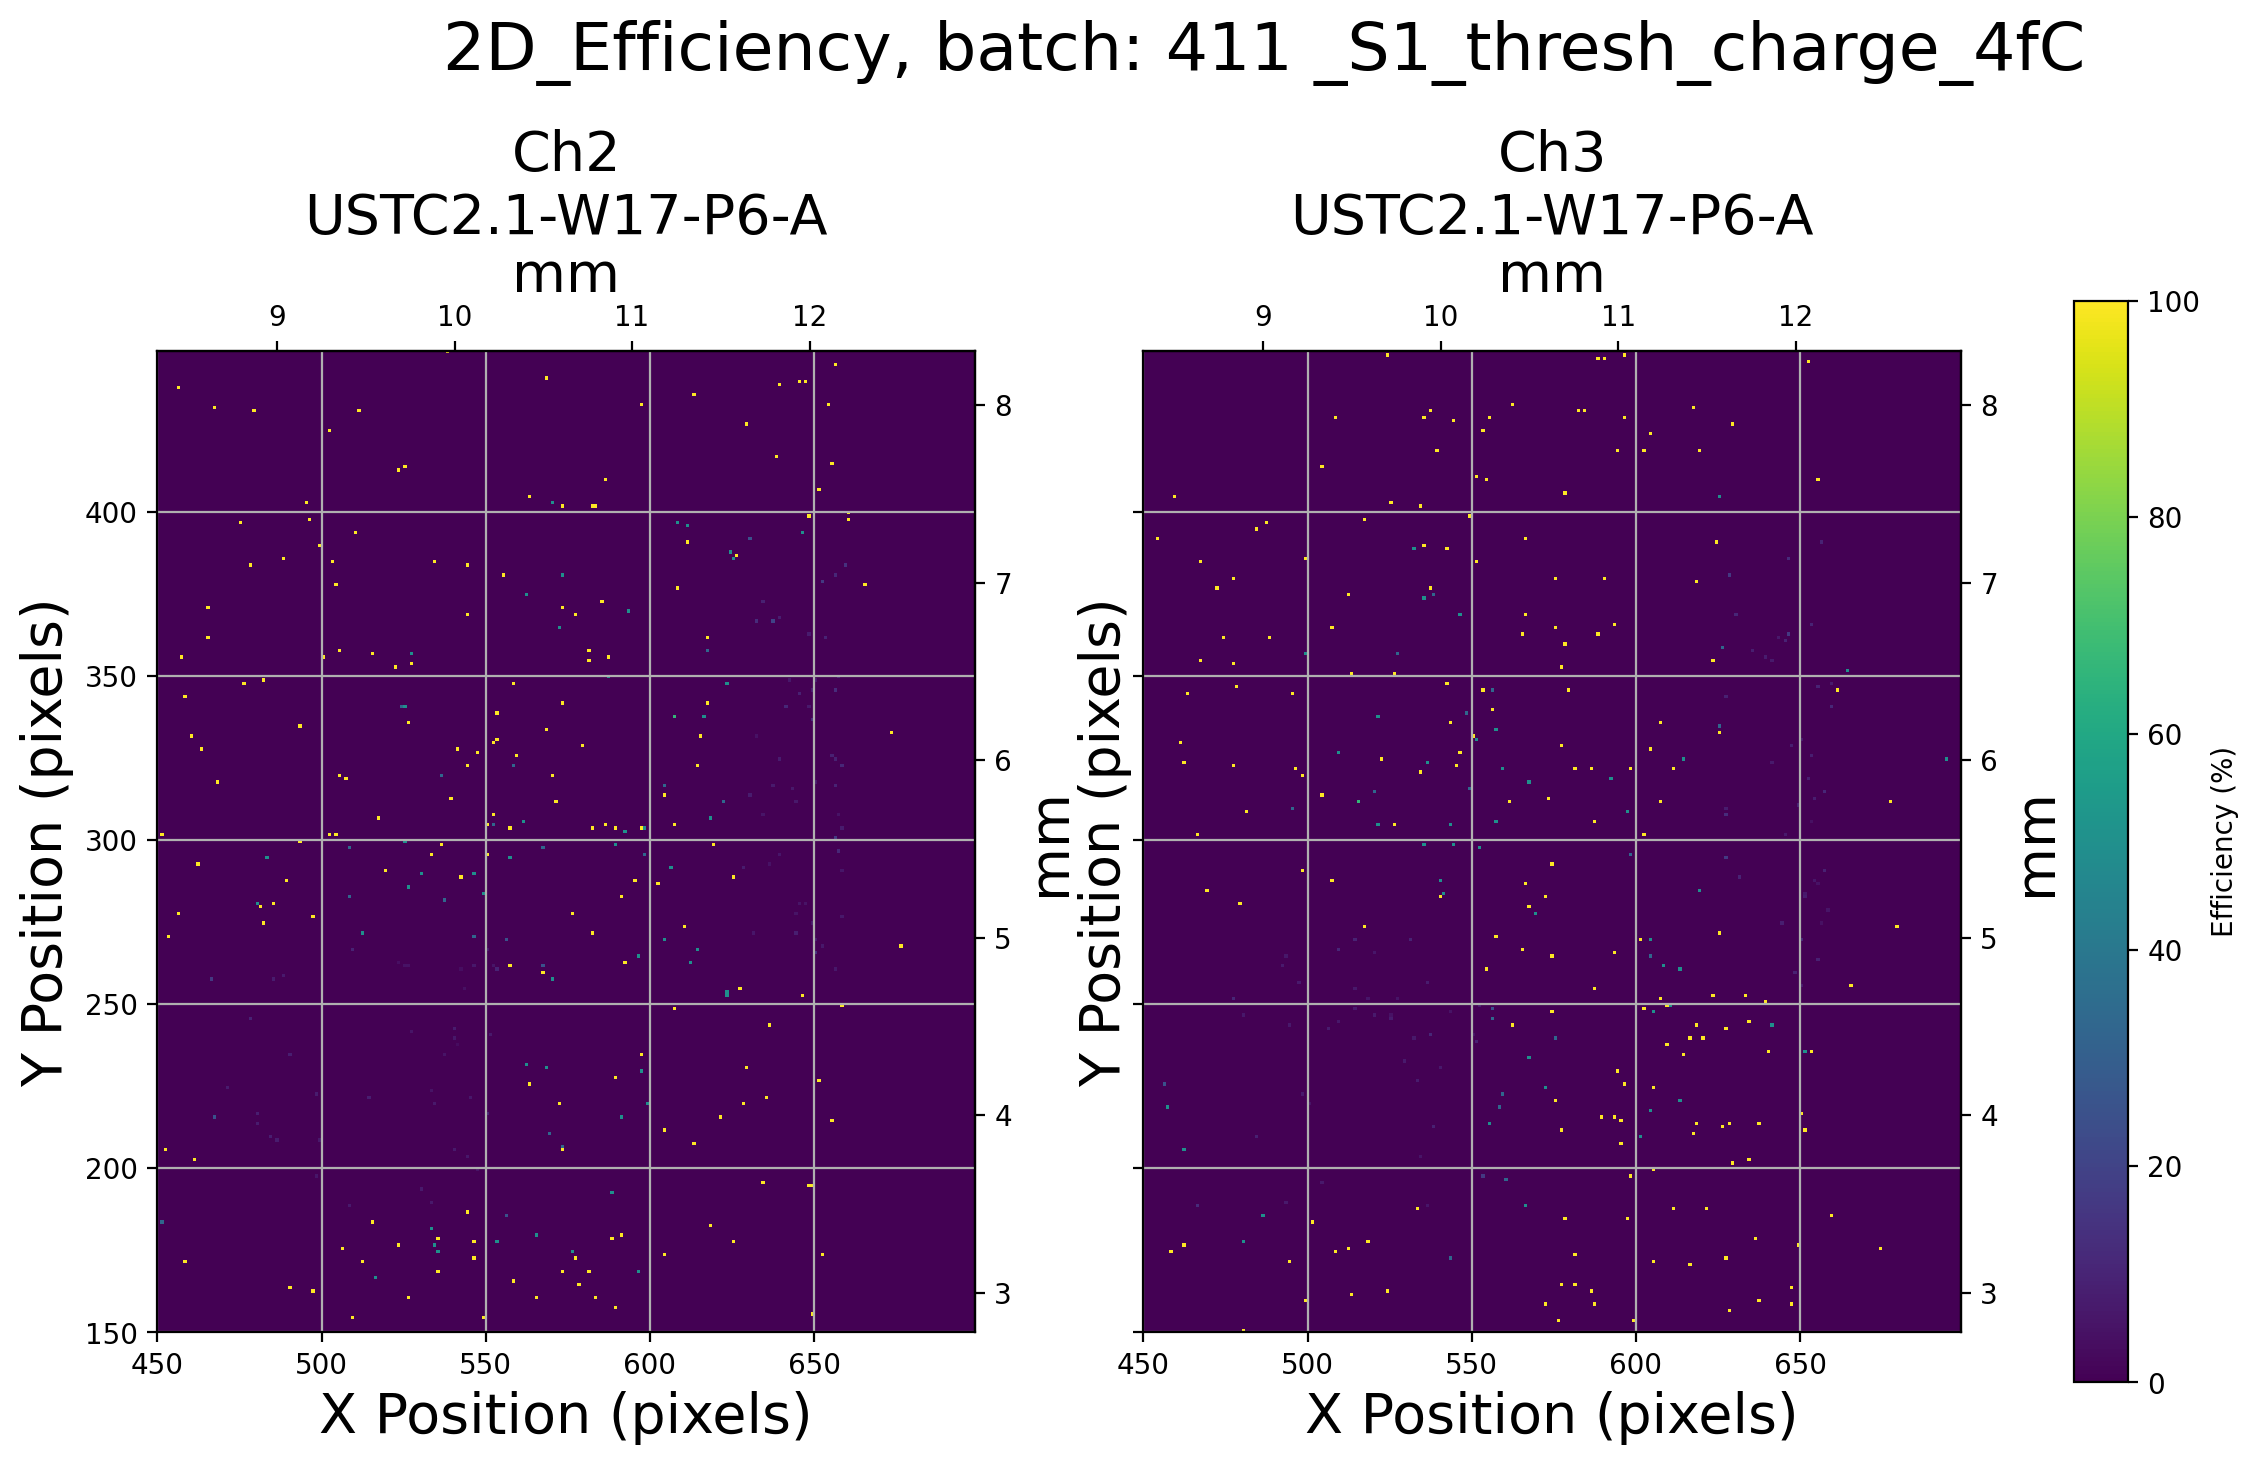

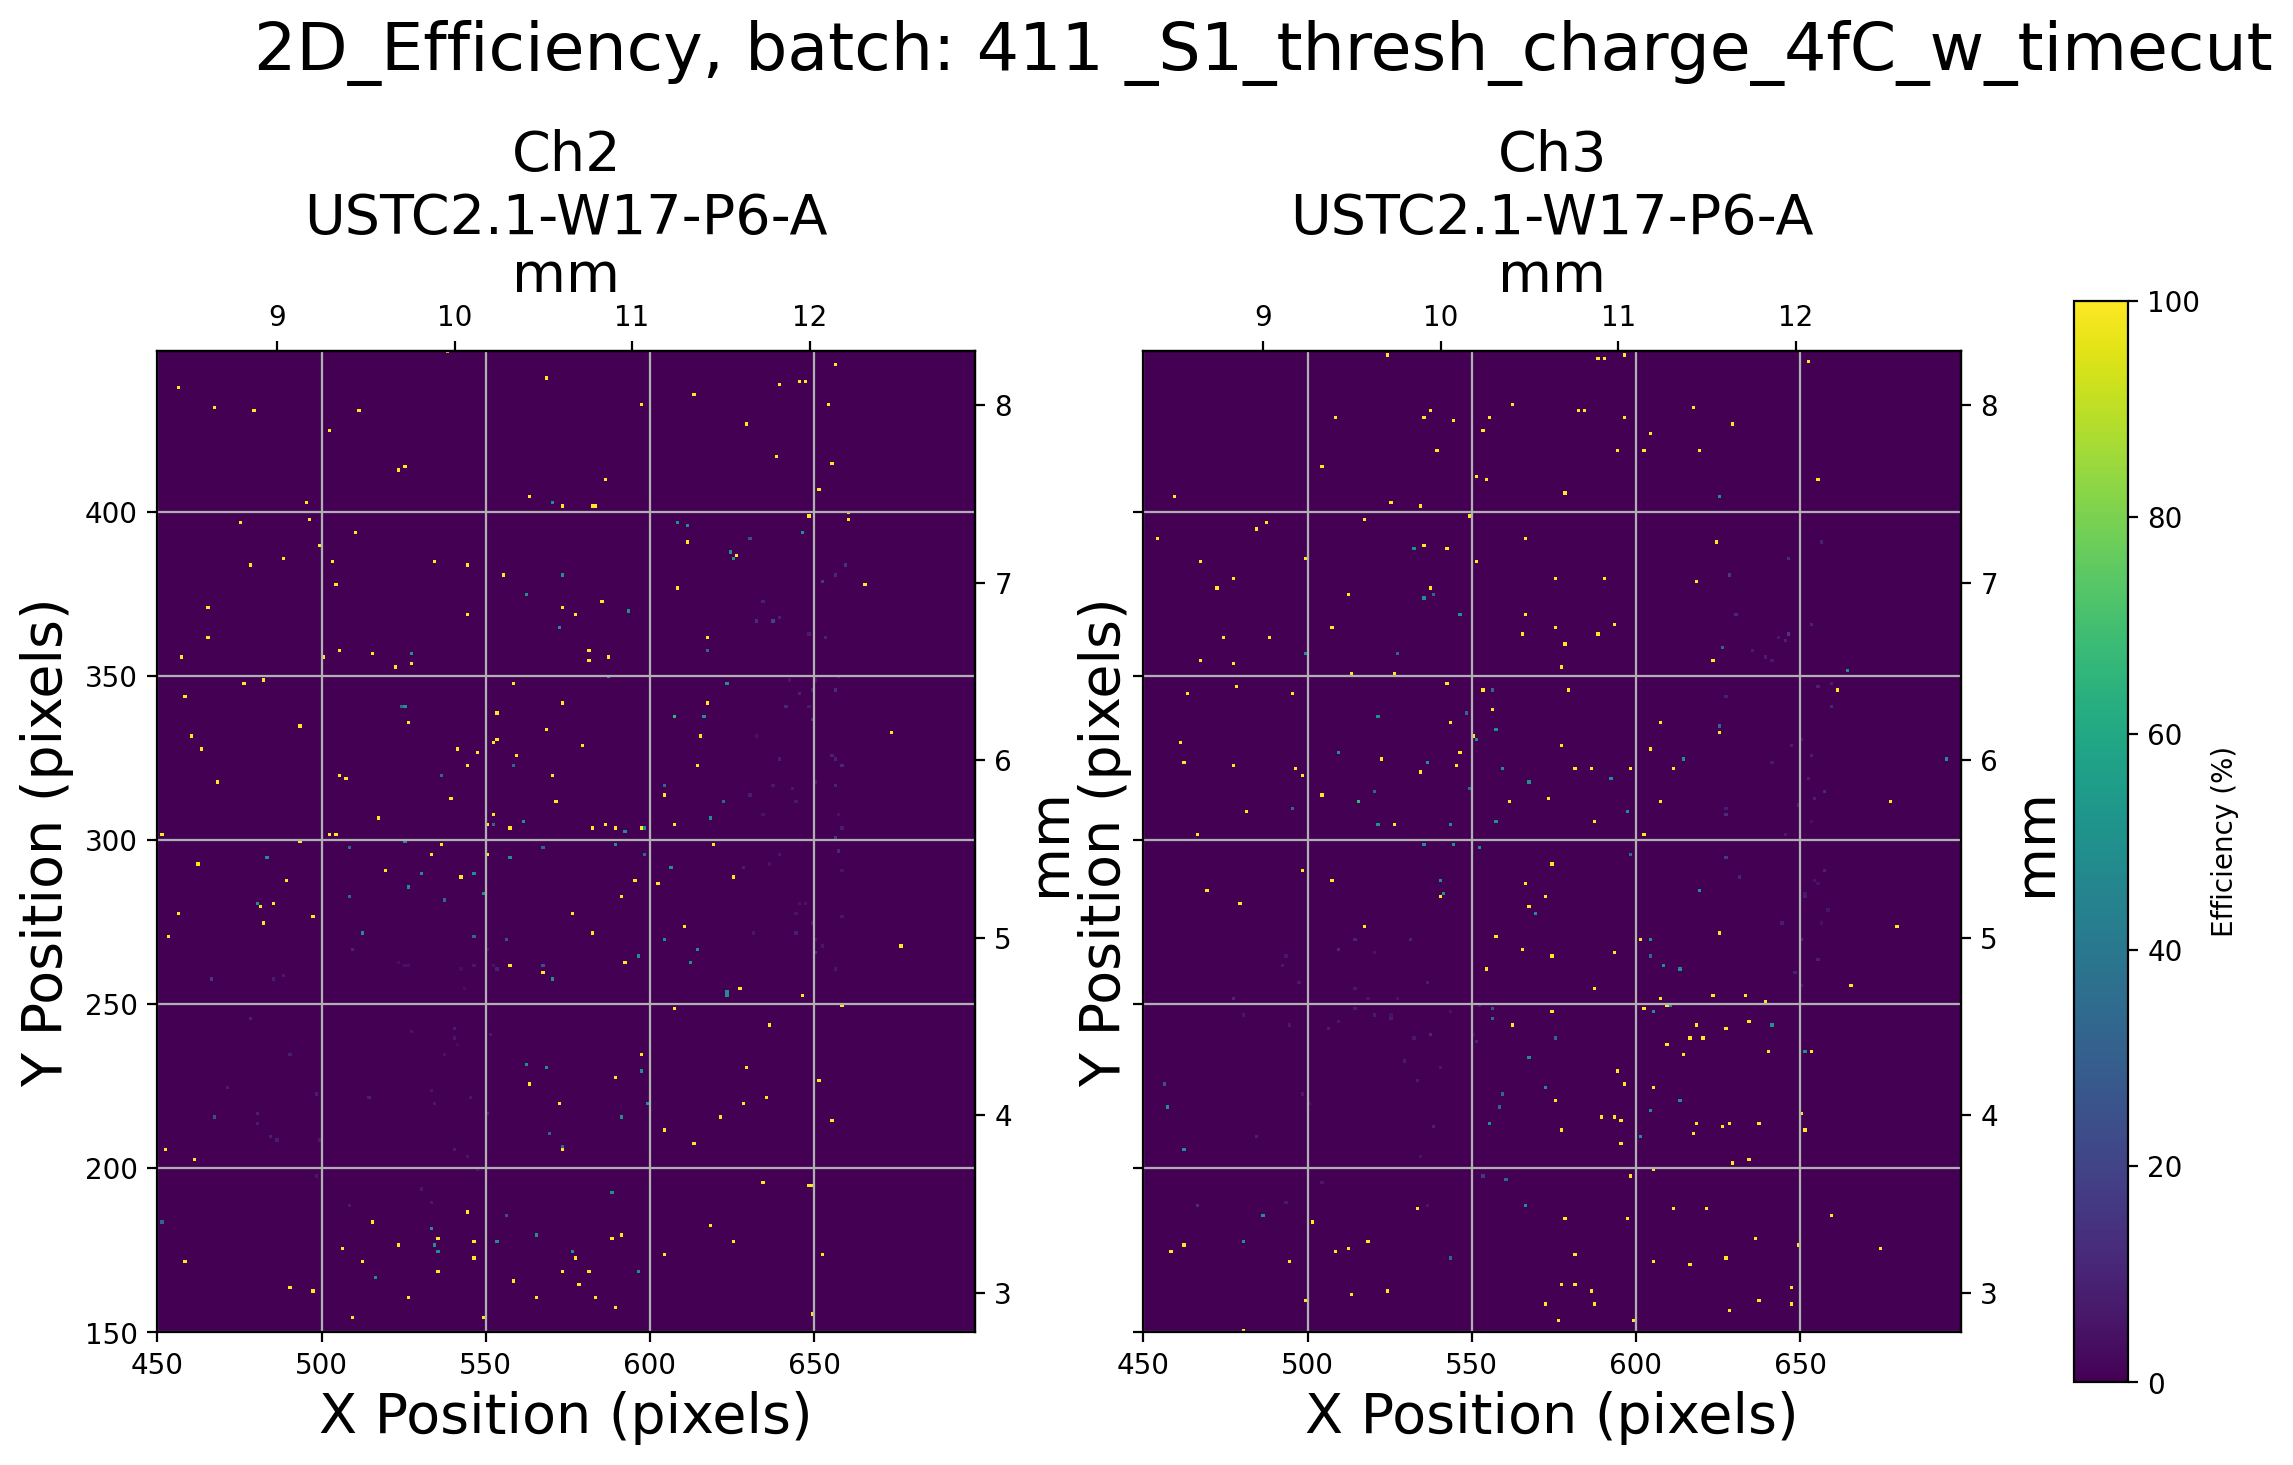

Batch:411, Scope:S1, Channel:Ch2


Batch:411, Scope:S1, Channel:Ch3


ValueError: Length mismatch: Expected axis has 0 elements, new values have 1 elements

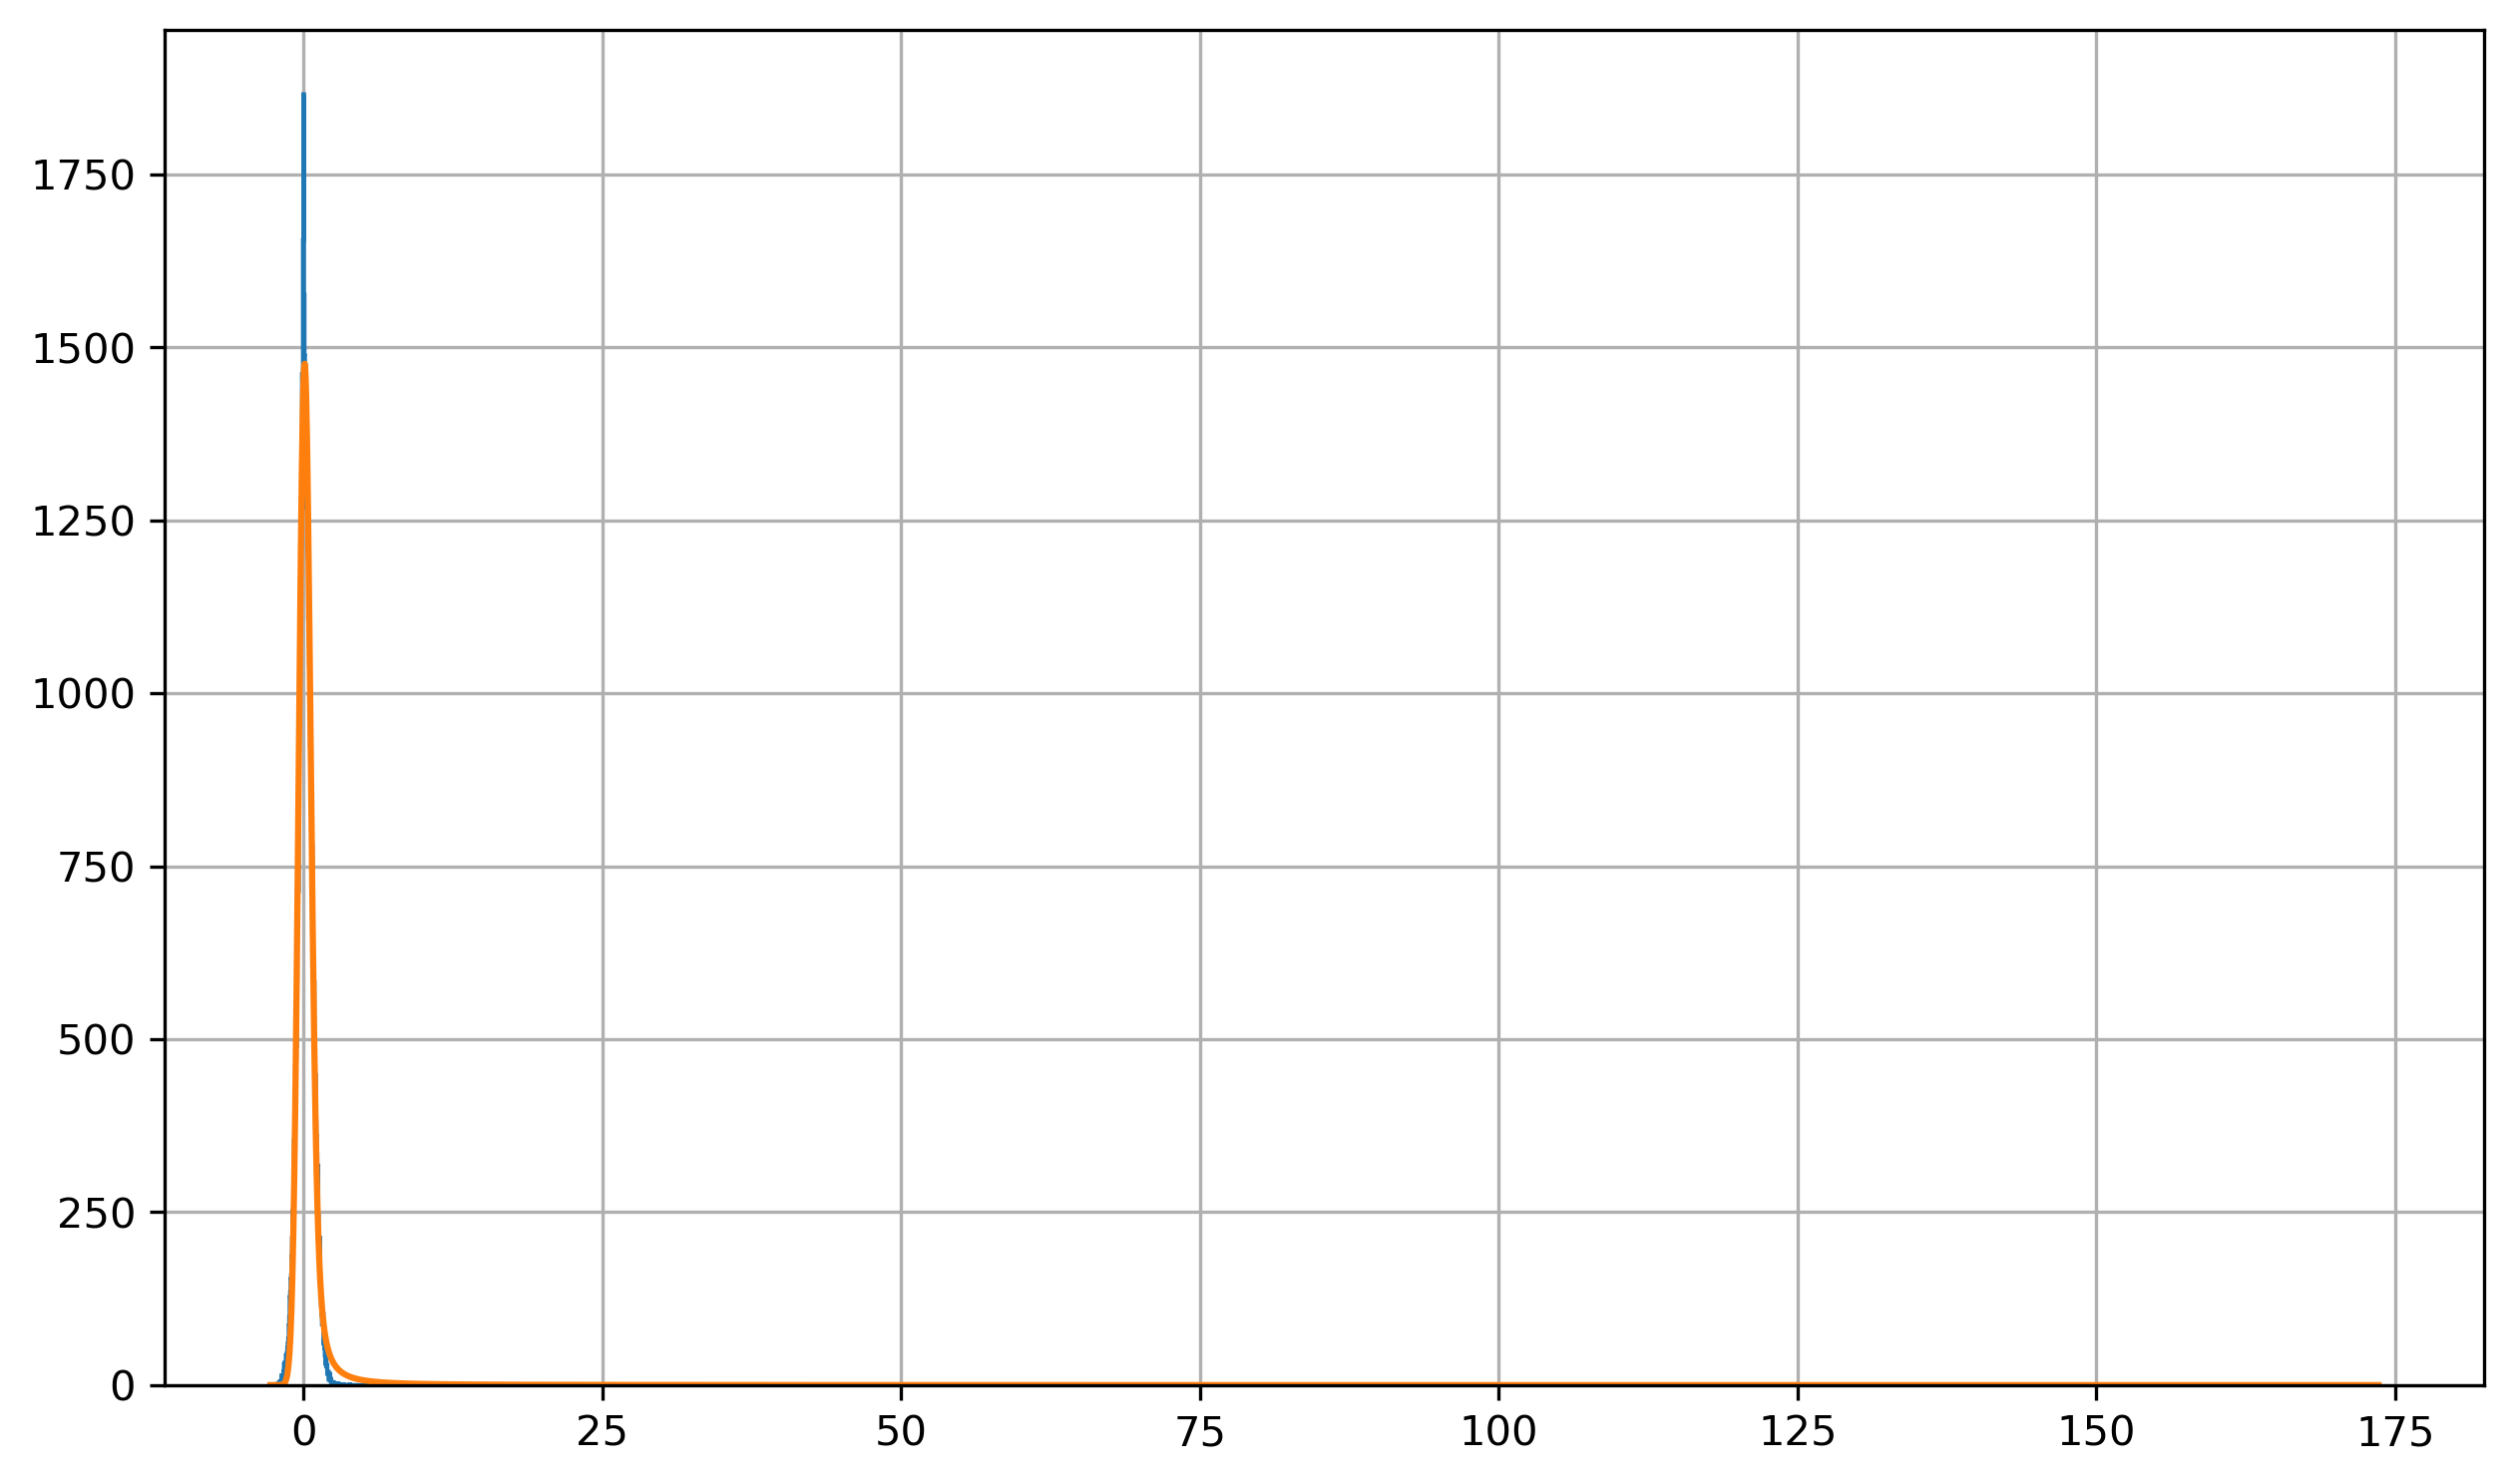

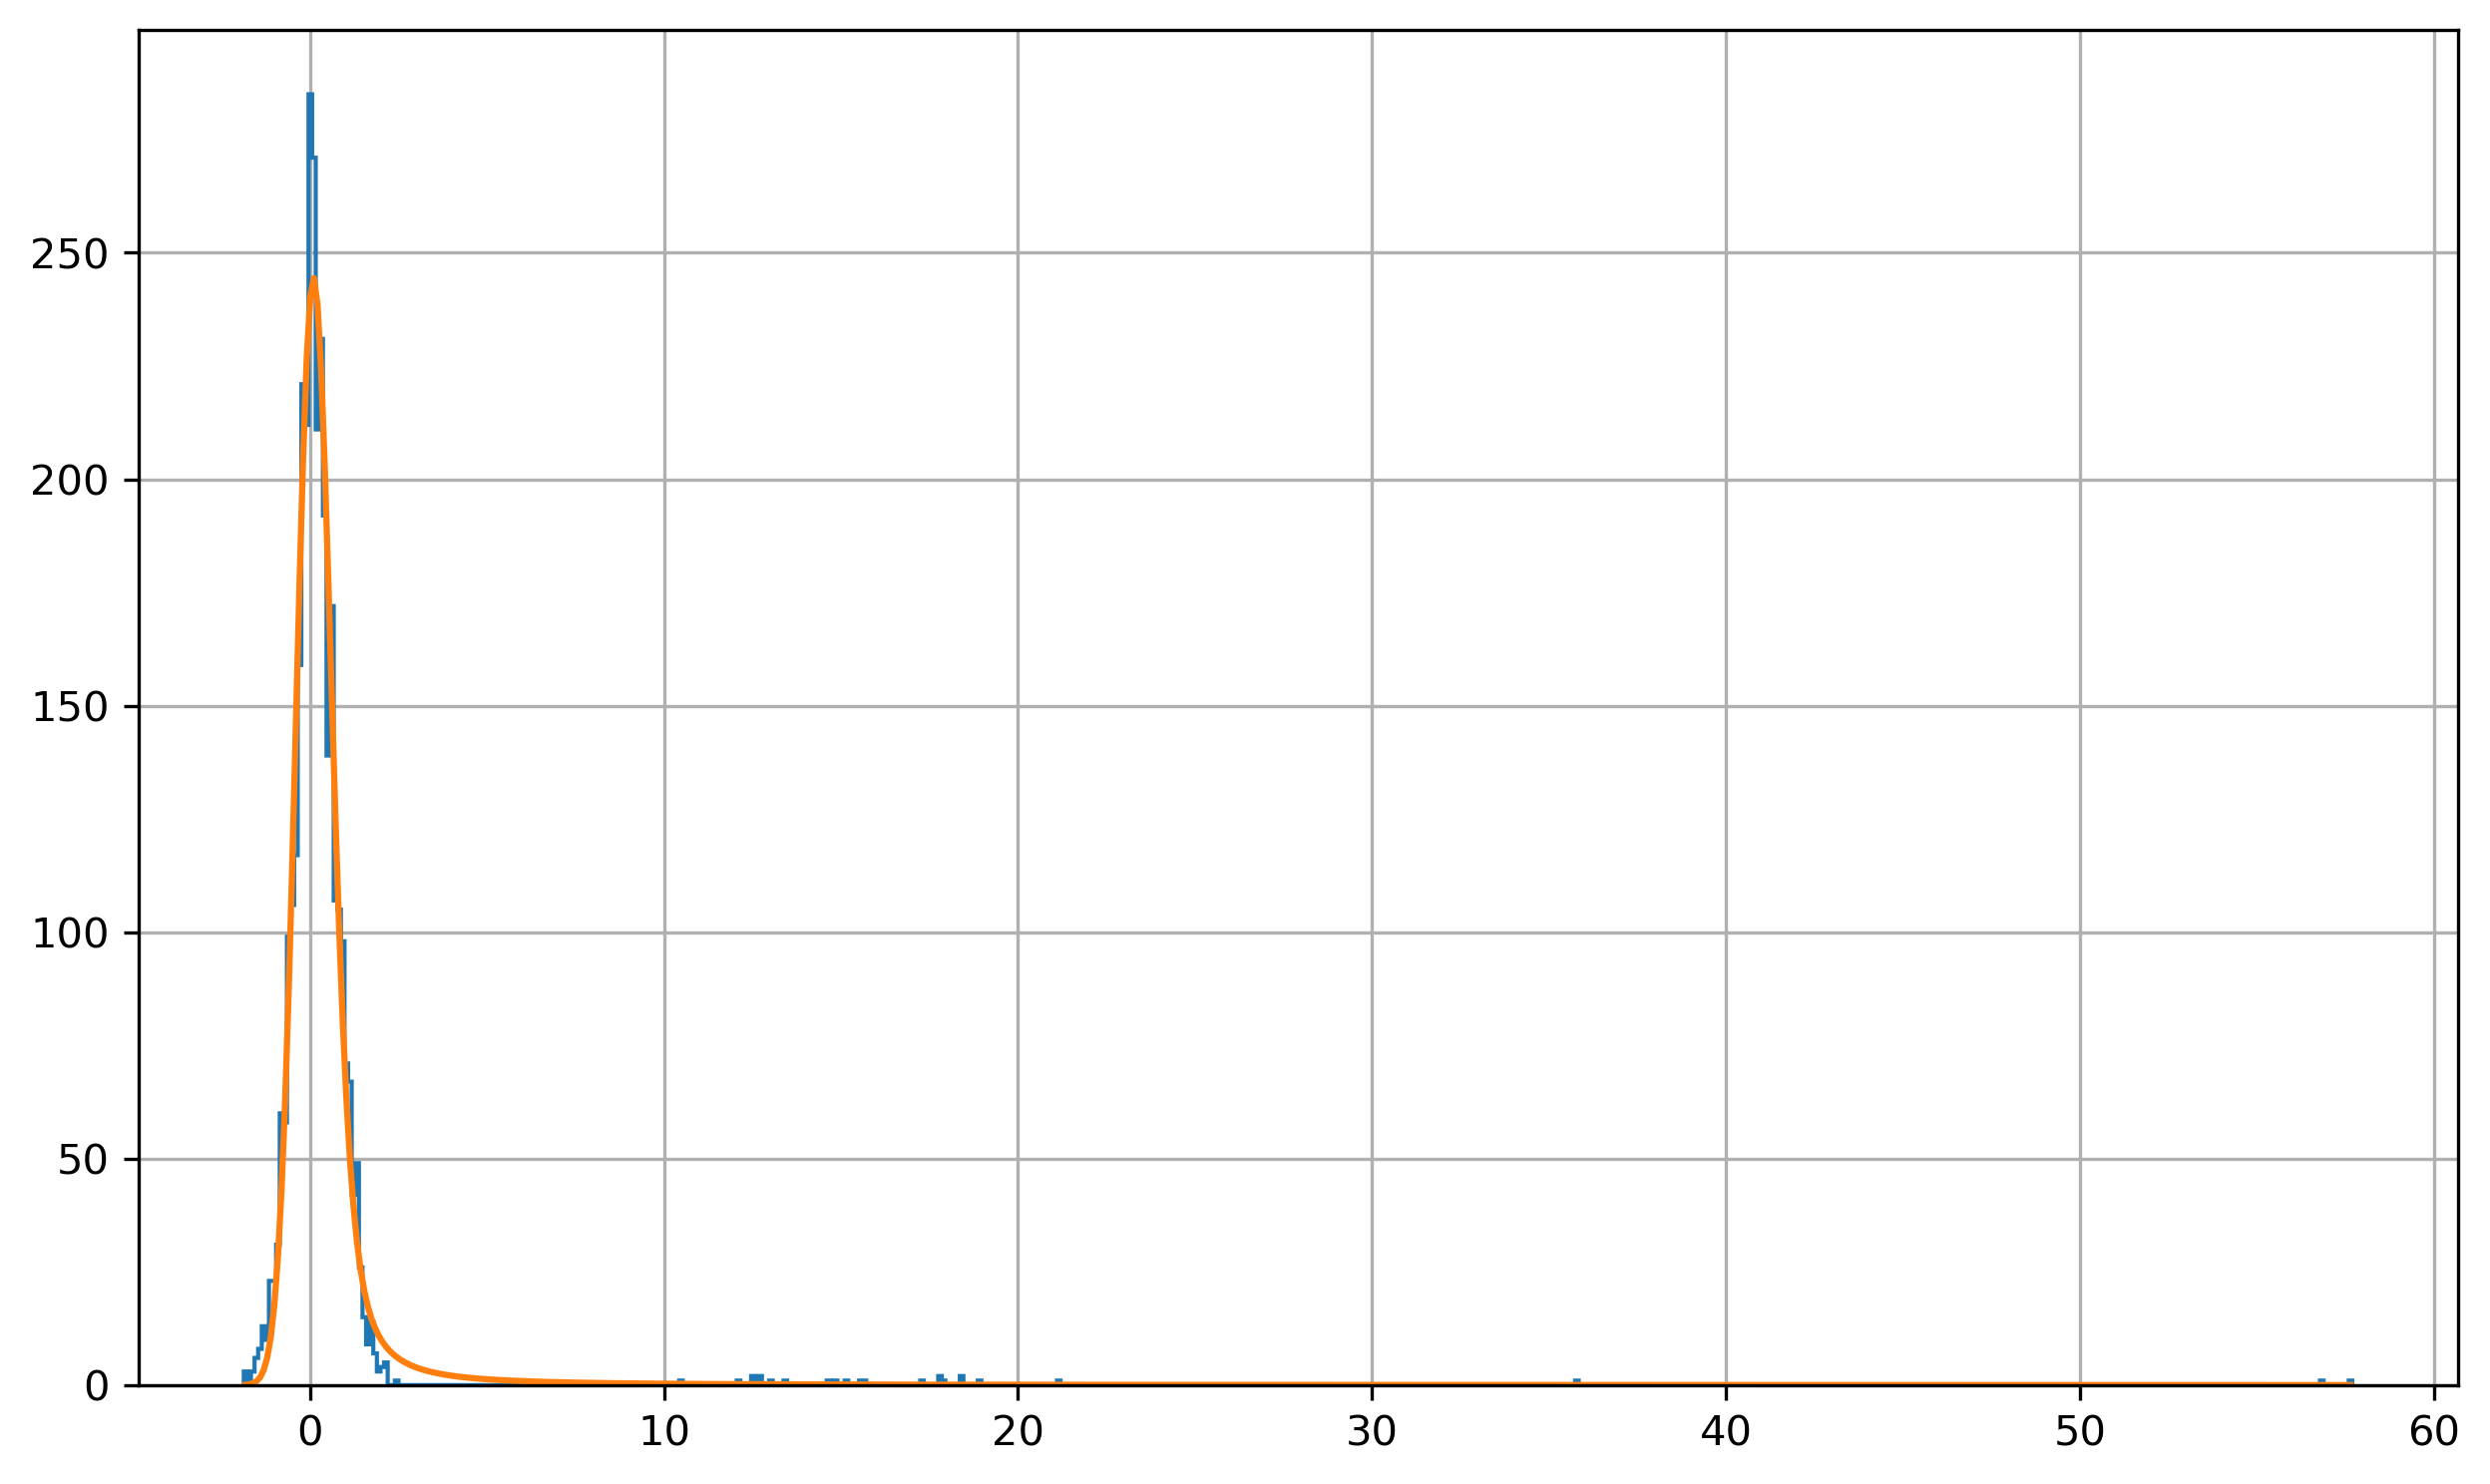

In [29]:
DUTs = (1,2)
binning_method = 'rice'
threshold_charge = 4 #fC
charge = []
charge_sigma = []
voltage = []

SAVE = True
save_path = f'../various plots/USTC_room_temp/'
if not os.path.isdir(save_path):
    os.mkdir(save_path)

for this_batch in df_analyis.index.levels[0]: ### batches
    for S in df_analyis.index.levels[1]:        ### scopes
        df = load_batch(this_batch,S)
        mins = [find_min_btw_peaks(df[f"pulseHeight_{i}"], bins='rice', plot=False) for i in DUTs]
        time_cut = [time_mask(df, i, bins=5000, plot=False)[0] for i in DUTs]
        geometry_cut = [geometry_mask(df, bins1, bins_find_min='rice',DUT_number=i) for i in DUTs]
        pulseheight_cut = [df[f'pulseHeight_{i}']>mins[i-1] for i in DUTs]
        ### PLOTTING
        #     print(f'angle: {dict_of_batches[this_batch].angle}°', f'temperature:{dict_of_batches[this_batch].tempA}°C')
        plot(df, "2D_Sensors", dict_of_batches[this_batch], S, bins=bins1, bins_find_min=binning_method,
             n_DUT=DUTs, savefig=SAVE, savefig_path=save_path, savefig_details=f'_{S}', fmt='jpg')

        plot(df, "1D_Efficiency", dict_of_batches[this_batch], S, threshold_charge=threshold_charge, geometry_cut=True,
                        bins=bins1, bins_find_min=binning_method, n_DUT=DUTs, savefig=SAVE, savefig_path=save_path, savefig_details=f'_{S}_threshold_charge_{threshold_charge}fC')

        plot(df, "1D_Efficiency", dict_of_batches[this_batch], S, threshold_charge=threshold_charge, geometry_cut=True, mask=time_cut,
                        bins=bins1, bins_find_min=binning_method, n_DUT=DUTs, savefig=SAVE, savefig_path=save_path, savefig_details=f'_{S}_threshold_charge_{threshold_charge}fC_w_timecut')

        plot(df, "2D_Efficiency", dict_of_batches[this_batch], S, threshold_charge=threshold_charge, geometry_cut=False,
                        bins=bins1, bins_find_min=binning_method, n_DUT=DUTs, savefig=SAVE, savefig_path=save_path, savefig_details=f'_{S}_thresh_charge_{threshold_charge}fC')

        plot(df, "2D_Efficiency", dict_of_batches[this_batch], S, threshold_charge=threshold_charge, geometry_cut=False, mask=time_cut,
                        bins=bins1, bins_find_min=binning_method, n_DUT=DUTs, savefig=SAVE, savefig_path=save_path, savefig_details=f'_{S}_thresh_charge_{threshold_charge}fC_w_timecut')

        for ch in df_analyis.index.levels[2]:      ### channels
            ### EXTRACTING DATA
            match ch:
                case 'Ch1': dut=-1
                case 'Ch2': dut=1
                case 'Ch3': dut=2
                case 'Ch4': dut=3
                case other: logging.error("wrong channel name")
            print(f"Batch:{this_batch}, Scope:{S}, Channel:{ch}")
            transimpedance = dict_of_batches[this_batch].S[S].channels[ch].transimpedance
            param, covar = charge_fit(df, dut=dut, mask=np.logical_and(time_cut[dut-1],geometry_cut[dut-1]), transimpedance=transimpedance)
            charge.append(param[0])
#             charge_sigma.append(param[2])
            voltage.append(dict_of_batches[this_batch].S[S].channels[ch].voltage)
    

In [ ]:
df_analyis['charge'] = charge
df_analyis['voltage'] = voltage
# df_analyis['charge_sigma'] = charge_sigma
idx=pd.IndexSlice

### select one value from the index channel
df_analyis.loc[idx[:,:,'Ch2'],['charge']] ### DATAFRAME  
df_analyis.loc[idx[:,:,'Ch2']]['charge']  ### SERIES
display(df_analyis)

In [ ]:
df_analyis.loc[idx[:,:,'Ch2']]['charge'].to_numpy()

In [ ]:
### no errorbar
S = 'S1'
fig, ax = plt.subplots(figsize=(10,8), dpi=300)
for ch in ['Ch2','Ch3']:
    ax.plot(np.array(df_analyis.loc[idx[:,:,ch]]['voltage']),np.array(df_analyis.loc[idx[:,:,ch]]['charge']),
           'x', markersize=10, label=f"{ch}, sensor: {dict_of_batches[this_batch].S[S].channels[ch].name}")
ax.set_title(f"""Voltage vs charge plot ({key_to_study})
MCP voltage: {dict_of_batches[this_batch].S[S].channels['Ch1'].voltage} V""", fontsize=20)
ax.set_xlabel("Voltage [V]")
ax.set_ylabel("Charge [fC]")
ax.grid('--')
ax.legend(fontsize=16)

fig.savefig(f"../various plots/USTC_room_temp/voltage_vs_charge_{key_to_study}.svg")


TypeError: langau() takes at least 1 positional argument (0 given)

In [ ]:
# _,my_bins,_,fig,ax = plot_histogram(df['pulseHeight_1'],bins='rice')
# plot_histogram(df['pulseHeight_1'].loc[df['charge_1']>4], bins=my_bins, fig_ax=(fig,ax))
# plot_histogram(df['pulseHeight_1'].loc[time_cuts[0]], bins=my_bins, fig_ax=(fig,ax))
# ax.semilogy()

In [ ]:
S = 'S1'
time_cuts = [time_mask(df, dut, bins=5000, plot=False)[0] for dut in (1,2)]
other_info = [time_mask(df, dut, bins=5000, plot=False)[1] for dut in (1,2)]
# time_cuts.insert(0,None)
plot(df, "2D_Tracks", dict_of_batches[this_batch], S, bins=bins1, n_DUT=[1,2], mask=time_cuts,
    savefig=True, savefig_details='_with_time_cut',fmt='jpg')

In [ ]:
plot(df, "2D_Efficiency", dict_of_batches[this_batch], S, bins=bins1, n_DUT=[1,2], threshold_charge=4,
     mask=time_cuts)

In [ ]:
fig,ax = plot(df, "1D_Efficiency", dict_of_batches[this_batch], S, bins=bins1, n_DUT=[1,2], threshold_charge=4,
             mask=time_cuts, geometry_cut=True)


In [ ]:

print('Angled')
for batch_number,S,ch in USTC_dict['angled']:
    print('Batch', batch_number, 'MCP voltage:', dict_of_batches[batch_number].S[S].channels['Ch1'].voltage)
    print('sensor angle:',dict_of_batches[batch_number].angle)
#     df = load_batch(batch_number, S)
    

## Charge plot

In [ ]:
this_batch = 301
this_scope = 'S1'
df = load_batch(this_batch, this_scope)


In [ ]:
mins = [find_min_btw_peaks(df[f"pulseHeight_{i}"], bins='rice', plot=False) for i in DUTs]

In [ ]:
### make it into an interactive plot???? mmm.. not really working
### I should probably add it to plot()
DUTs = [1,2,3]
xlim = (-10e3,0)

fig, axes = plt.subplots(figsize=(8*len(DUTs),8), ncols=len(DUTs), dpi=150)#, sharey=True )
for i,dut in enumerate(DUTs):

    info = time_mask(df, dut, bins=10000, plot=False)[1]
    left_base, right_base = info['left_base'], info['right_base']
    
    pulse_cut = mins[i]
    time_array = np.array(df[f'timeCFD50_{dut}']-df[f'timeCFD20_0'])
    pulseheight_array = np.array(df[f'pulseHeight_{dut}'])
    axes[i].plot(time_array, pulseheight_array, '.', markersize=0.8)
    
    axes[i].set_xlim(xlim)
    ylim = axes[i].get_ylim()
    
    total = len(time_array)/100  ### so I get percentage directly
    axes[i].annotate(f"%.3f"%(len(time_array[np.logical_and(time_array<left_base, pulseheight_array<pulse_cut)])/total)+"%", ((xlim[0]+left_base)/2, -25), fontsize=16)
    axes[i].annotate(f"%.3f"%(len(time_array[np.logical_and(time_array>right_base, pulseheight_array<pulse_cut)])/total)+"%", ((right_base+xlim[1])/2, -25), fontsize=16)
    axes[i].annotate(f"%.3f"%(len(time_array[np.logical_and(np.logical_and(time_array>left_base, time_array<right_base), pulseheight_array<pulse_cut)])/total)+"%", ((right_base+left_base)/2, -25), fontsize=16)

    axes[i].annotate(f"%.3f"%(len(time_array[np.logical_and(time_array<left_base, pulseheight_array>pulse_cut)])/total)+"%", ((xlim[0]+left_base)/2, (pulse_cut+ylim[1])/2), fontsize=16)
    axes[i].annotate(f"%.3f"%(len(time_array[np.logical_and(time_array>right_base, pulseheight_array>pulse_cut)])/total)+"%", ((right_base+xlim[1])/2, (pulse_cut+ylim[1])/2+20), fontsize=16)
    axes[i].annotate(f"%.3f"%(len(time_array[np.logical_and(np.logical_and(time_array>left_base, time_array<right_base), pulseheight_array>pulse_cut)])/total)+"%", ((right_base+left_base)/2, (pulse_cut+ylim[1])/2+50), fontsize=16)

    axes[i].axhline(pulse_cut,color='r', label="PulseHeight cut value: %.1f mV"%pulse_cut)
    axes[i].axvline(left_base, color='g', alpha=.9, label="Time cut: %.0fps$<\Delta t<$ %.0fps"%(left_base, right_base))
    axes[i].axvline(right_base, color='g', alpha=.9)
    axes[i].set_xlabel(f"$\Delta t$ [ps] (DUT {dut} - MCP)", fontsize=16)
    axes[i].set_ylabel(f"PulseHeight [mV]", fontsize=16)
    axes[i].grid('-')
#     axes[i].set_xlim(-7e3,-4e3)
    axes[i].legend(fontsize=16, loc='upper center', framealpha=0)
    axes[i].set_title(f"Sensor: {sensors_list[this_batch][this_scope][f'Ch{dut+1}']}", fontsize=16)
    
for ax in axes:
    ax.sharey(axes[0])

fig.suptitle(f"PulseHeight vs $\Delta t$ \t Batch:{this_batch} {this_scope} ", fontsize=24)
fig.savefig(f"../various plots/pulseHeight_vs_deltat_{this_batch}_{this_scope}_{DUTs}.jpg") ### svg is way too big

### Plotting three different cuts (pulseHeight, geometric and time) and comparing them with each other
and now fitting with the charge too

In [ ]:
DO_FIT = True
### colors   0   1   2   3     4      5         6
colormap = ['k','r','g','b','cyan','yellow','magenta']
color_geo, color_pulse, color_time = 'magenta', 'cyan', 'yellow'

transimpedance = [dict_of_batches[this_batch].S[this_scope].get_sensor(f'ch{dut+1}').transimpedance for dut in DUTs]
time_cuts = [time_mask(df, dut, bins=5000, plot=False)[0] for dut in DUTs]
geo_cuts = [geometry_mask(df, bins=bins1, bins_find_min='rice', DUT_number=dut) for dut in DUTs]
pulse_cuts = [df[f'pulseHeight_{dut}']>mins[dut-1] for dut in DUTs]
dut = 2

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(3*9,8), dpi=200)
for i in range(3):
    hist,my_bins,_,_,_ = plot_histogram(df[f'charge_{dut}']/transimpedance[dut-1], bins='auto',
                                          color=colormap[0], label=f"Ch{dut+1} no cut",
                                          fig_ax=(fig,axes[i]))
bins_centers = (my_bins[1:]+my_bins[:-1])/2
bins_centers = bins_centers.astype(np.float64)
legend_text = []
### --------------------------------
hist_time_cut,_,_,_,_ = plot_histogram(df[f'charge_{dut}'].loc[time_cuts[dut-1]]/transimpedance[dut-1], bins=my_bins,
                                       histtype='stepfilled', color=color_time, alpha=1, label=f"Ch{dut+1} time cut",
                                       fig_ax=(fig,axes[0]))

hist_geo_cut,_,_,_,_ = plot_histogram(df[f'charge_{dut}'].loc[geo_cuts[dut-1]]/transimpedance[dut-1], bins=my_bins,
                                       histtype='stepfilled', color=color_geo, alpha=0.5, label=f"Ch{dut+1} geo cut",
                                       fig_ax=(fig,axes[0]))

hist_geo_time_cut,_,_,_,_ = plot_histogram(df[f'charge_{dut}'].loc[np.logical_and(geo_cuts[dut-1],time_cuts[dut-1])]/transimpedance[dut-1], bins=my_bins,
                                       histtype='step', color=colormap[1], alpha=1, label=f"Ch{dut+1} geo and time cut",
                                       fig_ax=(fig,axes[0]))

if DO_FIT:
    param, covariance = curve_fit(pylandau.langau, bins_centers, hist_geo_time_cut, p0=(10,1,1,np.max(hist_geo_time_cut)))
    axes[0].plot(bins_centers, pylandau.langau(bins_centers, *param),color='k', label="Landau*Gaussian fit")
    legend_text.append("MPV: %.2f, $\eta$: %.2f, $\sigma$: %.2f" %(param[0],param[1], param[2])) # only two decimals

### --------------------------------
hist_geo_cut,_,_,_,_ = plot_histogram(df[f'charge_{dut}'].loc[geo_cuts[dut-1]]/transimpedance[dut-1], bins=my_bins,
                                       histtype='stepfilled', color=color_geo, alpha=1, label=f"Ch{dut+1} geo cut",
                                       fig_ax=(fig,axes[1]))

hist_pulse_cut,_,_,_,_ = plot_histogram(df[f'charge_{dut}'].loc[pulse_cuts[dut-1]]/transimpedance[dut-1], bins=my_bins,
                                       histtype='stepfilled', color=color_pulse, alpha=0.5, label=f"Ch{dut+1} pulse cut",
                                       fig_ax=(fig,axes[1]))

hist_geo_pulse_cut,_,_,_,_ = plot_histogram(df[f'charge_{dut}'].loc[np.logical_and(geo_cuts[dut-1],pulse_cuts[dut-1])]/transimpedance[dut-1], bins=my_bins,
                                       histtype='step', color=colormap[3], alpha=1, label=f"Ch{dut+1} geo and pulse cut",
                                       fig_ax=(fig,axes[1]))
if DO_FIT:
    param, covariance = curve_fit(pylandau.langau, bins_centers, hist_geo_pulse_cut, p0=(10,1,1,np.max(hist_geo_pulse_cut)))
    axes[1].plot(bins_centers, pylandau.langau(bins_centers, *param), color='k', label="Landau*Gaussian fit")
    legend_text.append("MPV: %.2f, $\eta$: %.2f, $\sigma$: %.2f" %(param[0],param[1], param[2])) # only two decimals

### --------------------------------

hist_time_cut,_,_,_,_ = plot_histogram(df[f'charge_{dut}'].loc[time_cuts[dut-1]]/transimpedance[dut-1], bins=my_bins,
                                       histtype='stepfilled', color=color_time, alpha=1, label=f"Ch{dut+1} time cut",
                                       fig_ax=(fig,axes[2]))

hist_pulse_cut,_,_,_,_ = plot_histogram(df[f'charge_{dut}'].loc[pulse_cuts[dut-1]]/transimpedance[dut-1], bins=my_bins,
                                       histtype='stepfilled', color=color_pulse, alpha=.7, label=f"Ch{dut+1} pulse cut",
                                       fig_ax=(fig,axes[2]))

hist_pulse_time_cut,_,_,_,_ = plot_histogram(df[f'charge_{dut}'].loc[np.logical_and(geo_cuts[dut-1],pulse_cuts[dut-1])]/transimpedance[dut-1], bins=my_bins,
                                       histtype='step', color=colormap[2], alpha=1, label=f"Ch{dut+1} pulse and time cut",
                                       fig_ax=(fig,axes[2]))

if DO_FIT:
    legend_text.append("MPV: %.2f, $\eta$: %.2f, $\sigma$: %.2f" %(param[0],param[1], param[2])) # only two decimals
    param, covariance = curve_fit(pylandau.langau, bins_centers, hist_pulse_time_cut, p0=(10,1,1,np.max(hist_pulse_time_cut)))
    axes[2].plot(bins_centers, pylandau.langau(bins_centers, *param), color='k', label="Landau*Gaussian fit")

for i in range(3):
    axes[i].semilogy()
    axes[i].set_xlim(-10,50)
    axes[i].set_ylim(0.1,1e6)
    axes[i].set_xlabel("Charge [fC]", fontsize=16)
    axes[i].set_ylabel("Events (log)", fontsize=16)
    handles, labels = axes[i].get_legend_handles_labels()
    if DO_FIT: handles.append(mpatches.Patch(color='none', label=legend_text[i]))
    axes[i].legend(handles=handles, fontsize=16);
    
fig.suptitle(f"Charge plot batch:{this_batch}, {this_scope}, Ch{dut+1} \n comparison between different cuts", fontsize=20)
fig.savefig(f"../various plots/Charge_plot_comparison_{this_batch}_{this_scope}_Ch{dut+1}.jpg")

In [14]:
dut = 1
charge_fit(df, dut=dut, mask=np.logical_and(geo_cuts[dut-1],pulse_cuts[dut-1]), transimpedance=transimpedance[dut-1], plot=False)

(array([4.87452716e+00, 4.64362848e-01, 1.30727487e+00, 3.68029239e+03]),
 array([[ 4.63475068e-06, -2.24878312e-06,  2.47317885e-06,
          4.48876617e-05],
        [-2.24878312e-06,  8.16338751e-06, -8.97797496e-06,
         -1.62947381e-04],
        [ 2.47317885e-06, -8.97797496e-06,  1.45929374e-05,
         -4.57337514e-03],
        [ 4.48876617e-05, -1.62947381e-04, -4.57337514e-03,
          1.21901192e+01]]))

### Now I really need to automatically calculate the charge

ValueError: Buffer dtype mismatch, expected 'double_t' but got 'float'

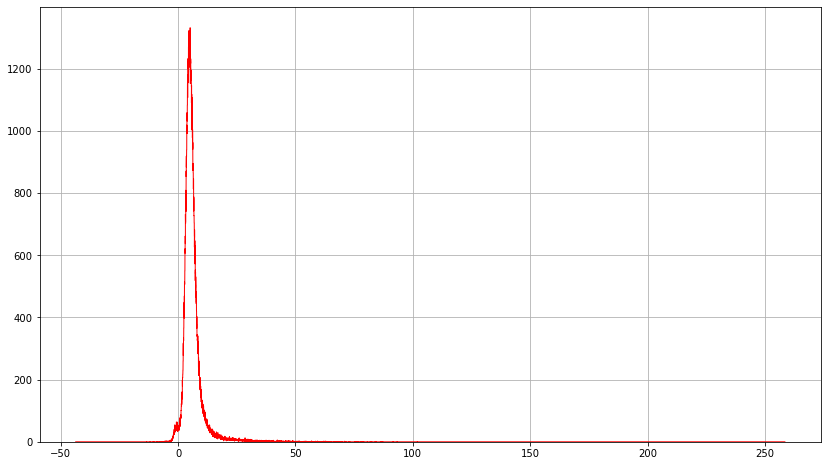

In [15]:
this_DUT = 1

fig, ax = plt.subplots(figsize=(14,8))
# ax.axvline(x=charge_threshold, color='r', label=f'threshold charge: {charge_threshold}fC')

hist_geo_time_cut,_,_,_,_ = plot_histogram((df[f'charge_{dut}'].loc[np.logical_and(geo_cuts[dut-1],time_cuts[dut-1])]/transimpedance[dut-1]), bins=my_bins,
                                       histtype='step', color=colormap[1], alpha=1, label=f"Ch{dut+1} geo and time cut",
                                       fig_ax=(fig,ax))

bins_centers = (my_bins[1:]+my_bins[:-1])/2
# bins_centers = bins_centers.astype(np.float64)

param, covariance = curve_fit(pylandau.langau, bins_centers, hist_geo_time_cut, p0=(5,1,1,np.max(hist_geo_time_cut)))
# print(param) 
ax.plot(bins_centers, pylandau.langau(bins_centers, *param), label="Landau*Gaussian fit")
ax.semilogy()

ax.set_xlim(-10, 50)
ax.set_ylim(0.1,1e6)
ax.set_xlabel("Charge [fC]", fontsize=20)
ax.set_ylabel("Events", fontsize=20)
ax.set_title(f"Charge distribution and Landau*Gaussian fit, Ch2", fontsize=24, y=1.05)
ax.grid('--')
legend_text = "MPV: %.2f, $\eta$: %.2f, $\sigma$: %.2f" %(param[0],param[1], param[2]) # only two decimals
handles, labels = ax.get_legend_handles_labels()
handles.append(mpatches.Patch(color='none', label=legend_text))
ax.legend(handles=handles, fontsize=20);
# fig.savefig(f"../various plots/Charge_distribution_fit_Ch2_{this_batch}.svg",bbox_inches='tight')
